In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import os
import inspect
import joblib

# Data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "svg"
pio.kaleido.scope.default_format = "svg"
from IPython.display import display, HTML
from statsmodels.graphics.mosaicplot import mosaic

# Statistics and math
import scipy.stats as stats
from scipy.stats import (
    ttest_ind, f_oneway, chi2_contingency, mannwhitneyu, pointbiserialr
)
from scipy.stats import chi2
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from math import pi

# Preprocessing and feature engineering
from sklearn.preprocessing import (
    QuantileTransformer, RobustScaler, OneHotEncoder, OrdinalEncoder,
    KBinsDiscretizer
)
from category_encoders import BinaryEncoder
import patsy
from BorutaShap import BorutaShap
import shap

# Model selection and evaluation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_score,
    HalvingRandomSearchCV
)
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, fbeta_score, cohen_kappa_score, average_precision_score,
    log_loss, matthews_corrcoef, brier_score_loss, make_scorer,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve,
    average_precision_score
)

# Machine learning models
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

# Pipeline and transformations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# Imbalance handling
from imblearn.combine import SMOTEENN

# Imputation
import miceforest as mf
from miceforest import mean_match_shap

# Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
# Set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set plotly template
plotly_template = 'simple_white'

# Loading the Data

In [3]:
# Load the Metabolic Syndrome dataset
data = pd.read_csv('/Users/williamjowens/Desktop/Datasets/metabolic_syndrome.csv')
data.head(10)

seqn  Age     Sex   Marital  Income   Race  WaistCirc   BMI  Albuminuria  \
0  62161   22    Male    Single  8200.0  White       81.0  23.3            0   
1  62164   44  Female   Married  4500.0  White       80.1  23.2            0   
2  62169   21    Male    Single   800.0  Asian       69.6  20.1            0   
3  62172   43  Female    Single  2000.0  Black      120.4  33.3            0   
4  62177   51    Male   Married     NaN  Asian       81.1  20.1            0   
5  62178   80    Male   Widowed   300.0  White      112.5  28.5            0   
6  62184   26    Male    Single  9000.0  Black       78.6  22.1            0   
7  62189   30  Female   Married  6200.0  Asian       80.2  22.4            0   
8  62191   70    Male  Divorced  1000.0  Black        NaN   NaN            1   
9  62195   35    Male       NaN  2500.0  Black       99.0  28.2            0   

   UrAlbCr  UricAcid  BloodGlucose  HDL  Triglycerides  MetabolicSyndrome  
0     3.88       4.9            92   41             84                  0  
1     8.55       4.5            82   28             56                  0  
2     5.07       5.4           107   43             78                  0  
3     5.22       5.0           104   73            141                  0  
4     8.13       5.0            95   43            126                  0  
5     9.79       4.8           105   47            100                  0  
6     9.21       5.4            87   61             40                  0  
7     8.78       6.7            83   48             91                  0  
8    45.67       5.4            96   35             75                  0  
9     2.21       6.7            94   46             86                  0

In [4]:
# Check the shape
print(f"There are {data.shape[0]} rows in the dataset.")
print(f"There are {data.shape[1]} columns in the dataset.")

There are 2401 rows in the dataset.
There are 15 columns in the dataset.


# Manipulating the Data

In [5]:
# Rename the columns to be more Pythonic
data.columns = data.columns.str.replace(r'(?<=[a-z])([A-Z])', r'_\1', regex=True).str.lower()
data.head(10)

seqn  age     sex   marital  income   race  waist_circ   bmi  albuminuria  \
0  62161   22    Male    Single  8200.0  White        81.0  23.3            0   
1  62164   44  Female   Married  4500.0  White        80.1  23.2            0   
2  62169   21    Male    Single   800.0  Asian        69.6  20.1            0   
3  62172   43  Female    Single  2000.0  Black       120.4  33.3            0   
4  62177   51    Male   Married     NaN  Asian        81.1  20.1            0   
5  62178   80    Male   Widowed   300.0  White       112.5  28.5            0   
6  62184   26    Male    Single  9000.0  Black        78.6  22.1            0   
7  62189   30  Female   Married  6200.0  Asian        80.2  22.4            0   
8  62191   70    Male  Divorced  1000.0  Black         NaN   NaN            1   
9  62195   35    Male       NaN  2500.0  Black        99.0  28.2            0   

   ur_alb_cr  uric_acid  blood_glucose  hdl  triglycerides  metabolic_syndrome  
0       3.88        4.9             92   41             84                   0  
1       8.55        4.5             82   28             56                   0  
2       5.07        5.4            107   43             78                   0  
3       5.22        5.0            104   73            141                   0  
4       8.13        5.0             95   43            126                   0  
5       9.79        4.8            105   47            100                   0  
6       9.21        5.4             87   61             40                   0  
7       8.78        6.7             83   48             91                   0  
8      45.67        5.4             96   35             75                   0  
9       2.21        6.7             94   46             86                   0

In [6]:
# Remove ID number
data.drop(columns=['seqn'], inplace=True)

In [7]:
# Shorten the target variable name
data.rename(columns={'metabolic_syndrome': 'metabolic_syn'}, inplace=True)

In [8]:
# Specify numeric and categorical features for datatype modification
continuous_list = ['age', 'income', 'waist_circ', 'bmi', 'ur_alb_cr', 'uric_acid', 'blood_glucose', 'hdl', 'triglycerides']
categorical_list = ['sex', 'marital', 'race', 'albuminuria']

# Convert specified columns to appropriate types
data[continuous_list] = data[continuous_list].astype('float')
data[categorical_list] = data[categorical_list].astype('category')

In [9]:
# Print number of unique values and datatypes
print("Unique Values and Datatypes:\n")
for col in data.columns:
    print(f"{col}:\nUnique Values: {data[col].nunique()}\nDatatype: {data[col].dtypes}\n")

Unique Values and Datatypes:

age:
Unique Values: 61
Datatype: float64

sex:
Unique Values: 2
Datatype: category

marital:
Unique Values: 5
Datatype: category

income:
Unique Values: 14
Datatype: float64

race:
Unique Values: 6
Datatype: category

waist_circ:
Unique Values: 635
Datatype: float64

bmi:
Unique Values: 322
Datatype: float64

albuminuria:
Unique Values: 3
Datatype: category

ur_alb_cr:
Unique Values: 1383
Datatype: float64

uric_acid:
Unique Values: 88
Datatype: float64

blood_glucose:
Unique Values: 187
Datatype: float64

hdl:
Unique Values: 93
Datatype: float64

triglycerides:
Unique Values: 345
Datatype: float64

metabolic_syn:
Unique Values: 2
Datatype: int64



In [10]:
# Print categorical feature distributions
print("Categorical Feature Distributions:\n")
for col in data[categorical_list].columns:
    print(f"{data[col].value_counts()}\n")

Categorical Feature Distributions:

sex
Female    1211
Male      1190
Name: count, dtype: int64

marital
Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: count, dtype: int64

race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: count, dtype: int64

albuminuria
0    2089
1     254
2      58
Name: count, dtype: int64



In [11]:
# Refactor the race variable
data['race'] = data['race'].replace({'Hispanic': 'HispanicOrLatino', 'MexAmerican': 'HispanicOrLatino'})

In [12]:
# Print number of missing values for each feature
print("Missing Values per Feature:\n")
for col in data.columns:
    print(f"{col}: {data[col].isnull().sum()}")
print("\n")
print(f"Total Missing Values:\n {data.isnull().sum().sum()}")

Missing Values per Feature:

age: 0
sex: 0
marital: 208
income: 117
race: 0
waist_circ: 85
bmi: 26
albuminuria: 0
ur_alb_cr: 0
uric_acid: 0
blood_glucose: 0
hdl: 0
triglycerides: 0
metabolic_syn: 0


Total Missing Values:
 436


In [13]:
# Target class distribution
print(f"Number of observations per class:\n{data['metabolic_syn'].value_counts()}")

Number of observations per class:
metabolic_syn
0    1579
1     822
Name: count, dtype: int64


In [14]:
# Lists of the numeric and categorical features
continuous_features = ['age', 'income', 'waist_circ', 'bmi', 'ur_alb_cr', 'uric_acid', 'blood_glucose', 'hdl', 'triglycerides']
ordinal_features = ['albuminuria']
binary_features = ['sex']
nominal_features = ['marital', 'race']
categorical_features = ordinal_features + binary_features + nominal_features

In [15]:
# Save cleaned dataset - missing values retained intentionally
clean_data = data
clean_data.to_csv('/Users/williamjowens/Desktop/Datasets/clean_data_metabolic_syndrome.csv', index=False)

# Exploring the Data

## Descriptive Statistics

In [16]:
# Get descriptive statistics for continuous features
describe_df = data[continuous_features].describe()

# Get the Range
range_df = (data[continuous_features].max() - data[continuous_features].min()).to_frame().T
range_df.index = ['range']

# Get the Skew
skew_df = data[continuous_features].skew().to_frame().T
skew_df.index = ['skew']

# Combine them
describe_plus_df = pd.concat([describe_df, range_df, skew_df], axis=0)

# Display the DataFrame
print("Descriptive Statistics for Continuous Features:\n")
describe_plus_df

Descriptive Statistics for Continuous Features:



age       income   waist_circ          bmi    ur_alb_cr  \
count  2401.000000  2284.000000  2316.000000  2375.000000  2401.000000   
mean     48.691795  4005.253940    98.307254    28.702189    43.626131   
std      17.632852  2954.032186    16.252634     6.662242   258.272829   
min      20.000000   300.000000    56.200000    13.400000     1.400000   
25%      34.000000  1600.000000    86.675000    24.000000     4.450000   
50%      48.000000  2500.000000    97.000000    27.700000     7.070000   
75%      63.000000  6200.000000   107.625000    32.100000    13.690000   
max      80.000000  9000.000000   176.000000    68.700000  5928.000000   
range    60.000000  8700.000000   119.800000    55.300000  5926.600000   
skew      0.134018     0.613143     0.634634     1.122344    13.291163   

         uric_acid  blood_glucose          hdl  triglycerides  
count  2401.000000    2401.000000  2401.000000    2401.000000  
mean      5.489046     108.247813    53.369429     128.125364  
std       1.439358      34.820657    15.185537      95.322477  
min       1.800000      39.000000    14.000000      26.000000  
25%       4.500000      92.000000    43.000000      75.000000  
50%       5.400000      99.000000    51.000000     103.000000  
75%       6.400000     110.000000    62.000000     150.000000  
max      11.300000     382.000000   156.000000    1562.000000  
range     9.500000     343.000000   142.000000    1536.000000  
skew      0.471024       3.766413     1.082828       4.462779

In [17]:
# Function to show descriptive statistics
def describe_table(describe_df):
    """
    Plots a table with the descriptive statistics of the DataFrame.
    """
    # Transpose the DataFrame to make the measures the columns
    describe_df = describe_df.T

    # Format the numerical values
    formatted_df = describe_df.applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x).reset_index()

    # Rename the '50%' column to 'Median' and 'index' to 'Feature'
    formatted_df.rename(columns={'50%': 'Median', 'index': 'Feature'}, inplace=True)
    formatted_df.columns = [col.capitalize() for col in formatted_df.columns]

    # Generate table with Plotly
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(formatted_df.columns),
                    align='center',
                    fill_color='midnightblue',
                    font=dict(color='white', size=15)),
        cells=dict(values=[formatted_df[col] for col in formatted_df.columns],
                   fill_color='gainsboro',
                   align='center',
                   font=dict(size=10.5),
                   height=30))])

    # Update the layout of the figure
    fig.update_layout(title={
        'text': f"<b>Descriptive Statistics</b>"},
                      template=plotly_template,
                      height=400, width=1000,
                      margin=dict(t=50))

    # Display the figure
    fig.show()

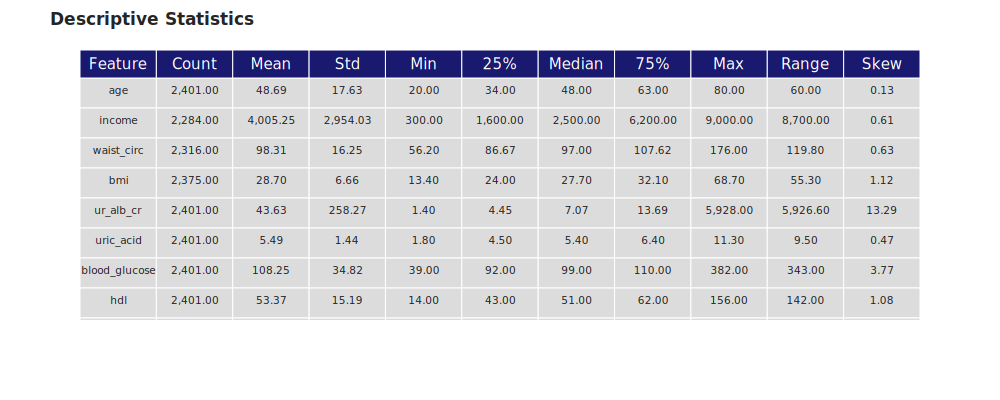

In [18]:
# Get the descriptive statistics table
describe_table(describe_plus_df)

In [19]:
# Get the descriptive statistics for categorical features
describe_df_categorical = data[categorical_features].describe()

# Display the DataFrame
print("Descriptive Statistics for Categorical Features:\n")
describe_df_categorical

Descriptive Statistics for Categorical Features:



albuminuria     sex  marital   race
count          2401    2401     2193   2401
unique            3       2        5      5
top               0  Female  Married  White
freq           2089    1211     1192    933

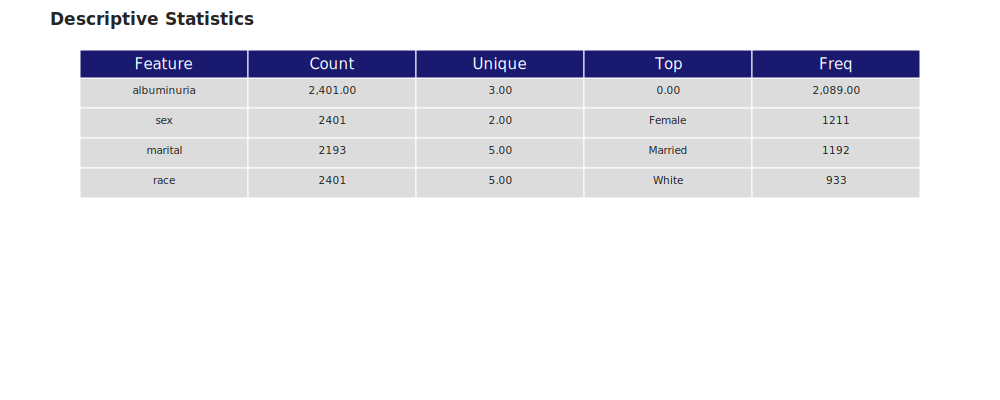

In [20]:
# Get the descriptive statistics table
describe_table(describe_df_categorical)

## Outlier Detection

In [21]:
# Function to detect outliers based on IQR Method
def calculate_outliers(df, feature_list):
    """
    Creates a DataFrame with the count of outliers for each feature.
    """
    outlier_counts = {}
    for feature in feature_list:
        # Calculate Q1
        Q1 = df[feature].quantile(0.25)
    
        # Calculate Q3
        Q3 = df[feature].quantile(0.75)
    
        # Calculate the IQR
        IQR = Q3 - Q1
    
        # Determine outliers using IQR
        outliers = df[(df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))]

        # Add the count
        outlier_counts[feature] = outliers[feature].count()

    # Convert to a DataFrame
    outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Number of Outliers'])
    outlier_df = outlier_df.sort_values(by='Number of Outliers', ascending=False)
    return outlier_df

In [22]:
# View outlier DataFrame
outlier_df = calculate_outliers(data, continuous_features)
outlier_df

Feature  Number of Outliers
4      ur_alb_cr                 332
6  blood_glucose                 220
8  triglycerides                 161
3            bmi                  67
7            hdl                  54
2     waist_circ                  44
5      uric_acid                  30
0            age                   0
1         income                   0

In [23]:
# Function to show the number of outliers per feature
def plot_outliers(outlier_df):
    """
    Plots the number of outliers for each feature.
    """
    fig = px.bar(
        outlier_df, 
        x='Feature', 
        y='Number of Outliers', 
        title='Number of Outliers per Feature',
        text='Number of Outliers'
    )
    
    # Update layout for width and height
    fig.update_layout(width=800, height=500)
    fig.show()

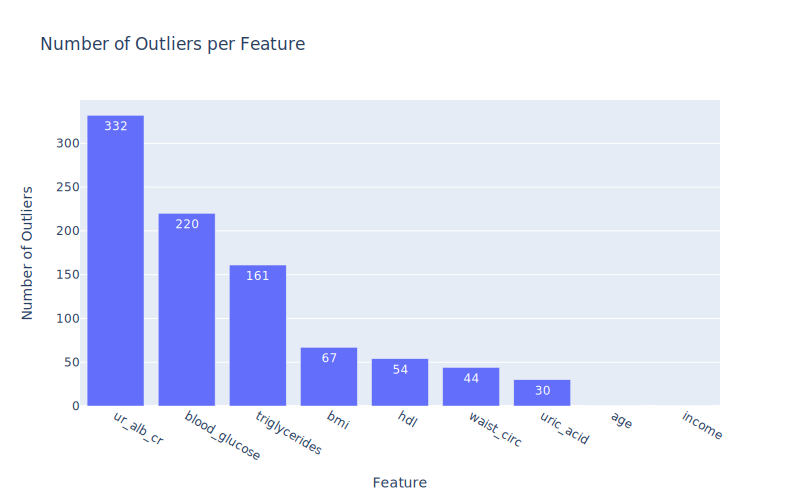

In [24]:
# Call the function
plot_outliers(outlier_df)

## Histograms

In [25]:
# Function to create histogram matrix
def plot_histogram_matrix(df, continuous_features_list):
    """
    Plots the histograms for each continuous feature.
    """
    num_cols = 2
    num_rows = (len(continuous_features_list) + 1) // num_cols
    
    fig = make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(continuous_features_list):
        row = i // num_cols + 1
        col = i % num_cols + 1
        
        fig.add_trace(
            go.Histogram(
                x=df[feature],
                name=feature
            ),
            row=row,
            col=col
        )

        fig.update_xaxes(title_text=feature, row=row, col=col)
        fig.update_yaxes(title_text='Frequency', row=row, col=col)
        fig.update_layout(
            title = f"<b>Histogram Matrix<br><sup>Continuous Features</sup></b>",
            showlegend=False)
    
        fig.update_layout(
            height=350*num_rows,
            width=1000,
            margin=dict(t=100, l=80),
            template=plotly_template)

    fig.show()

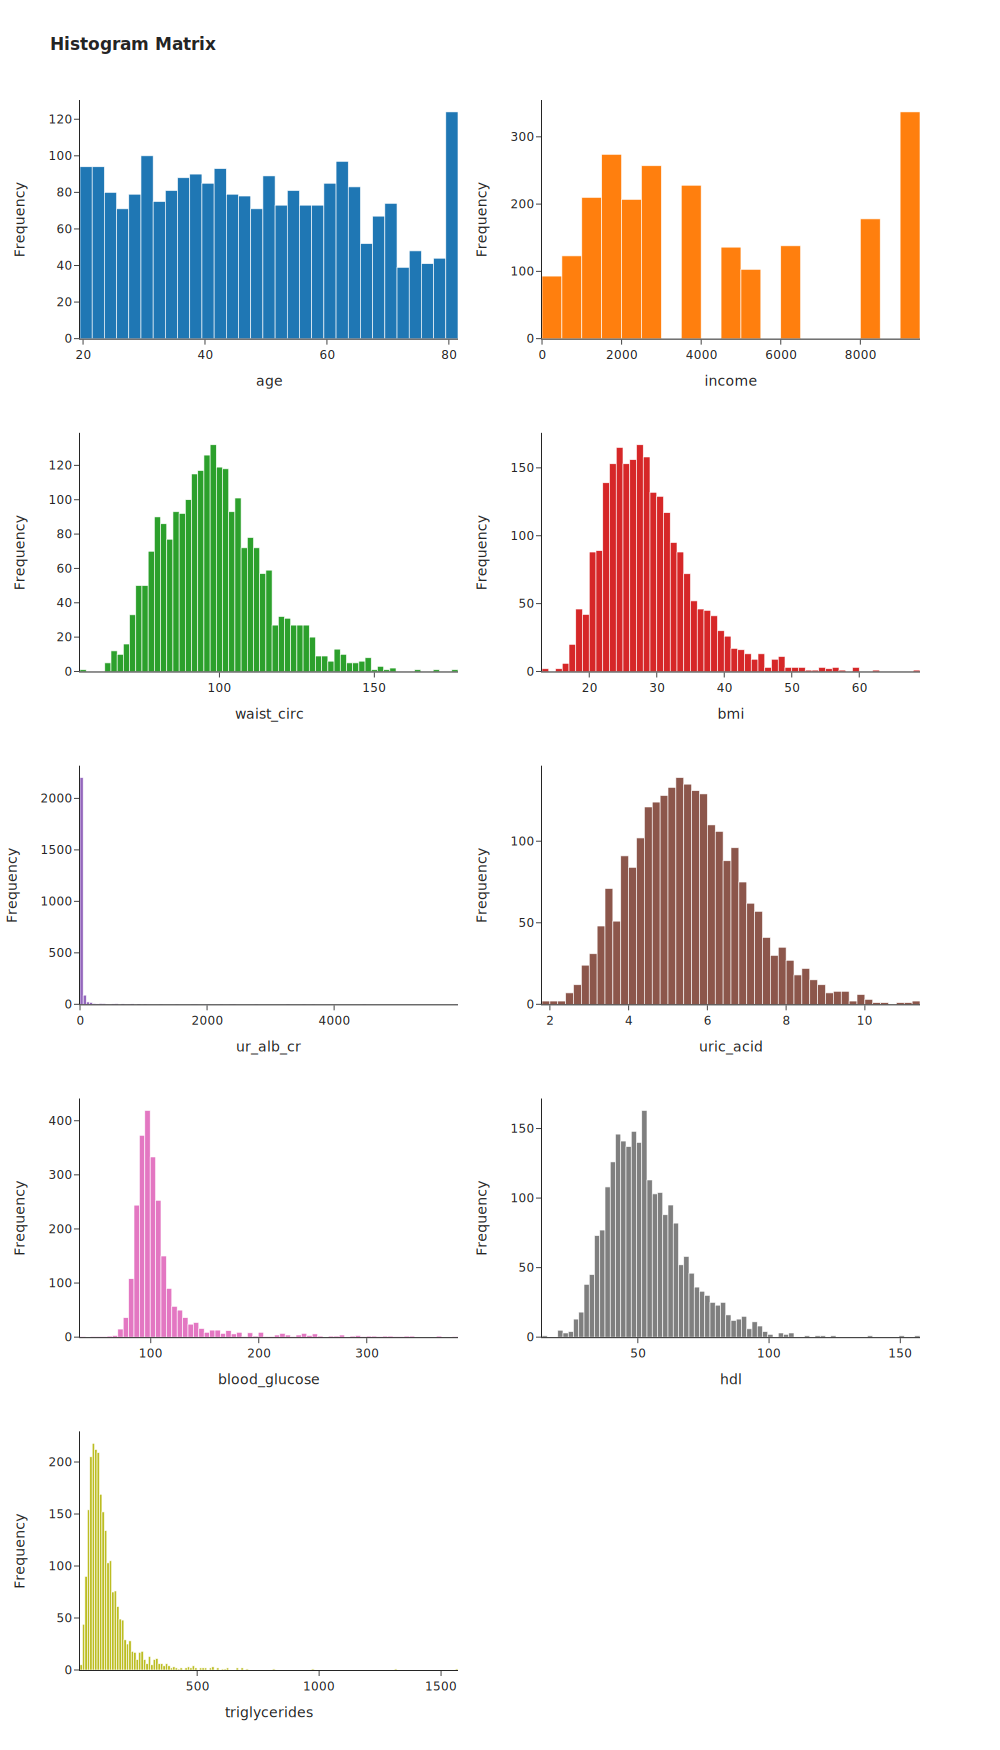

In [26]:
# Call the function
plot_histogram_matrix(data, continuous_features)

## Scatterplots

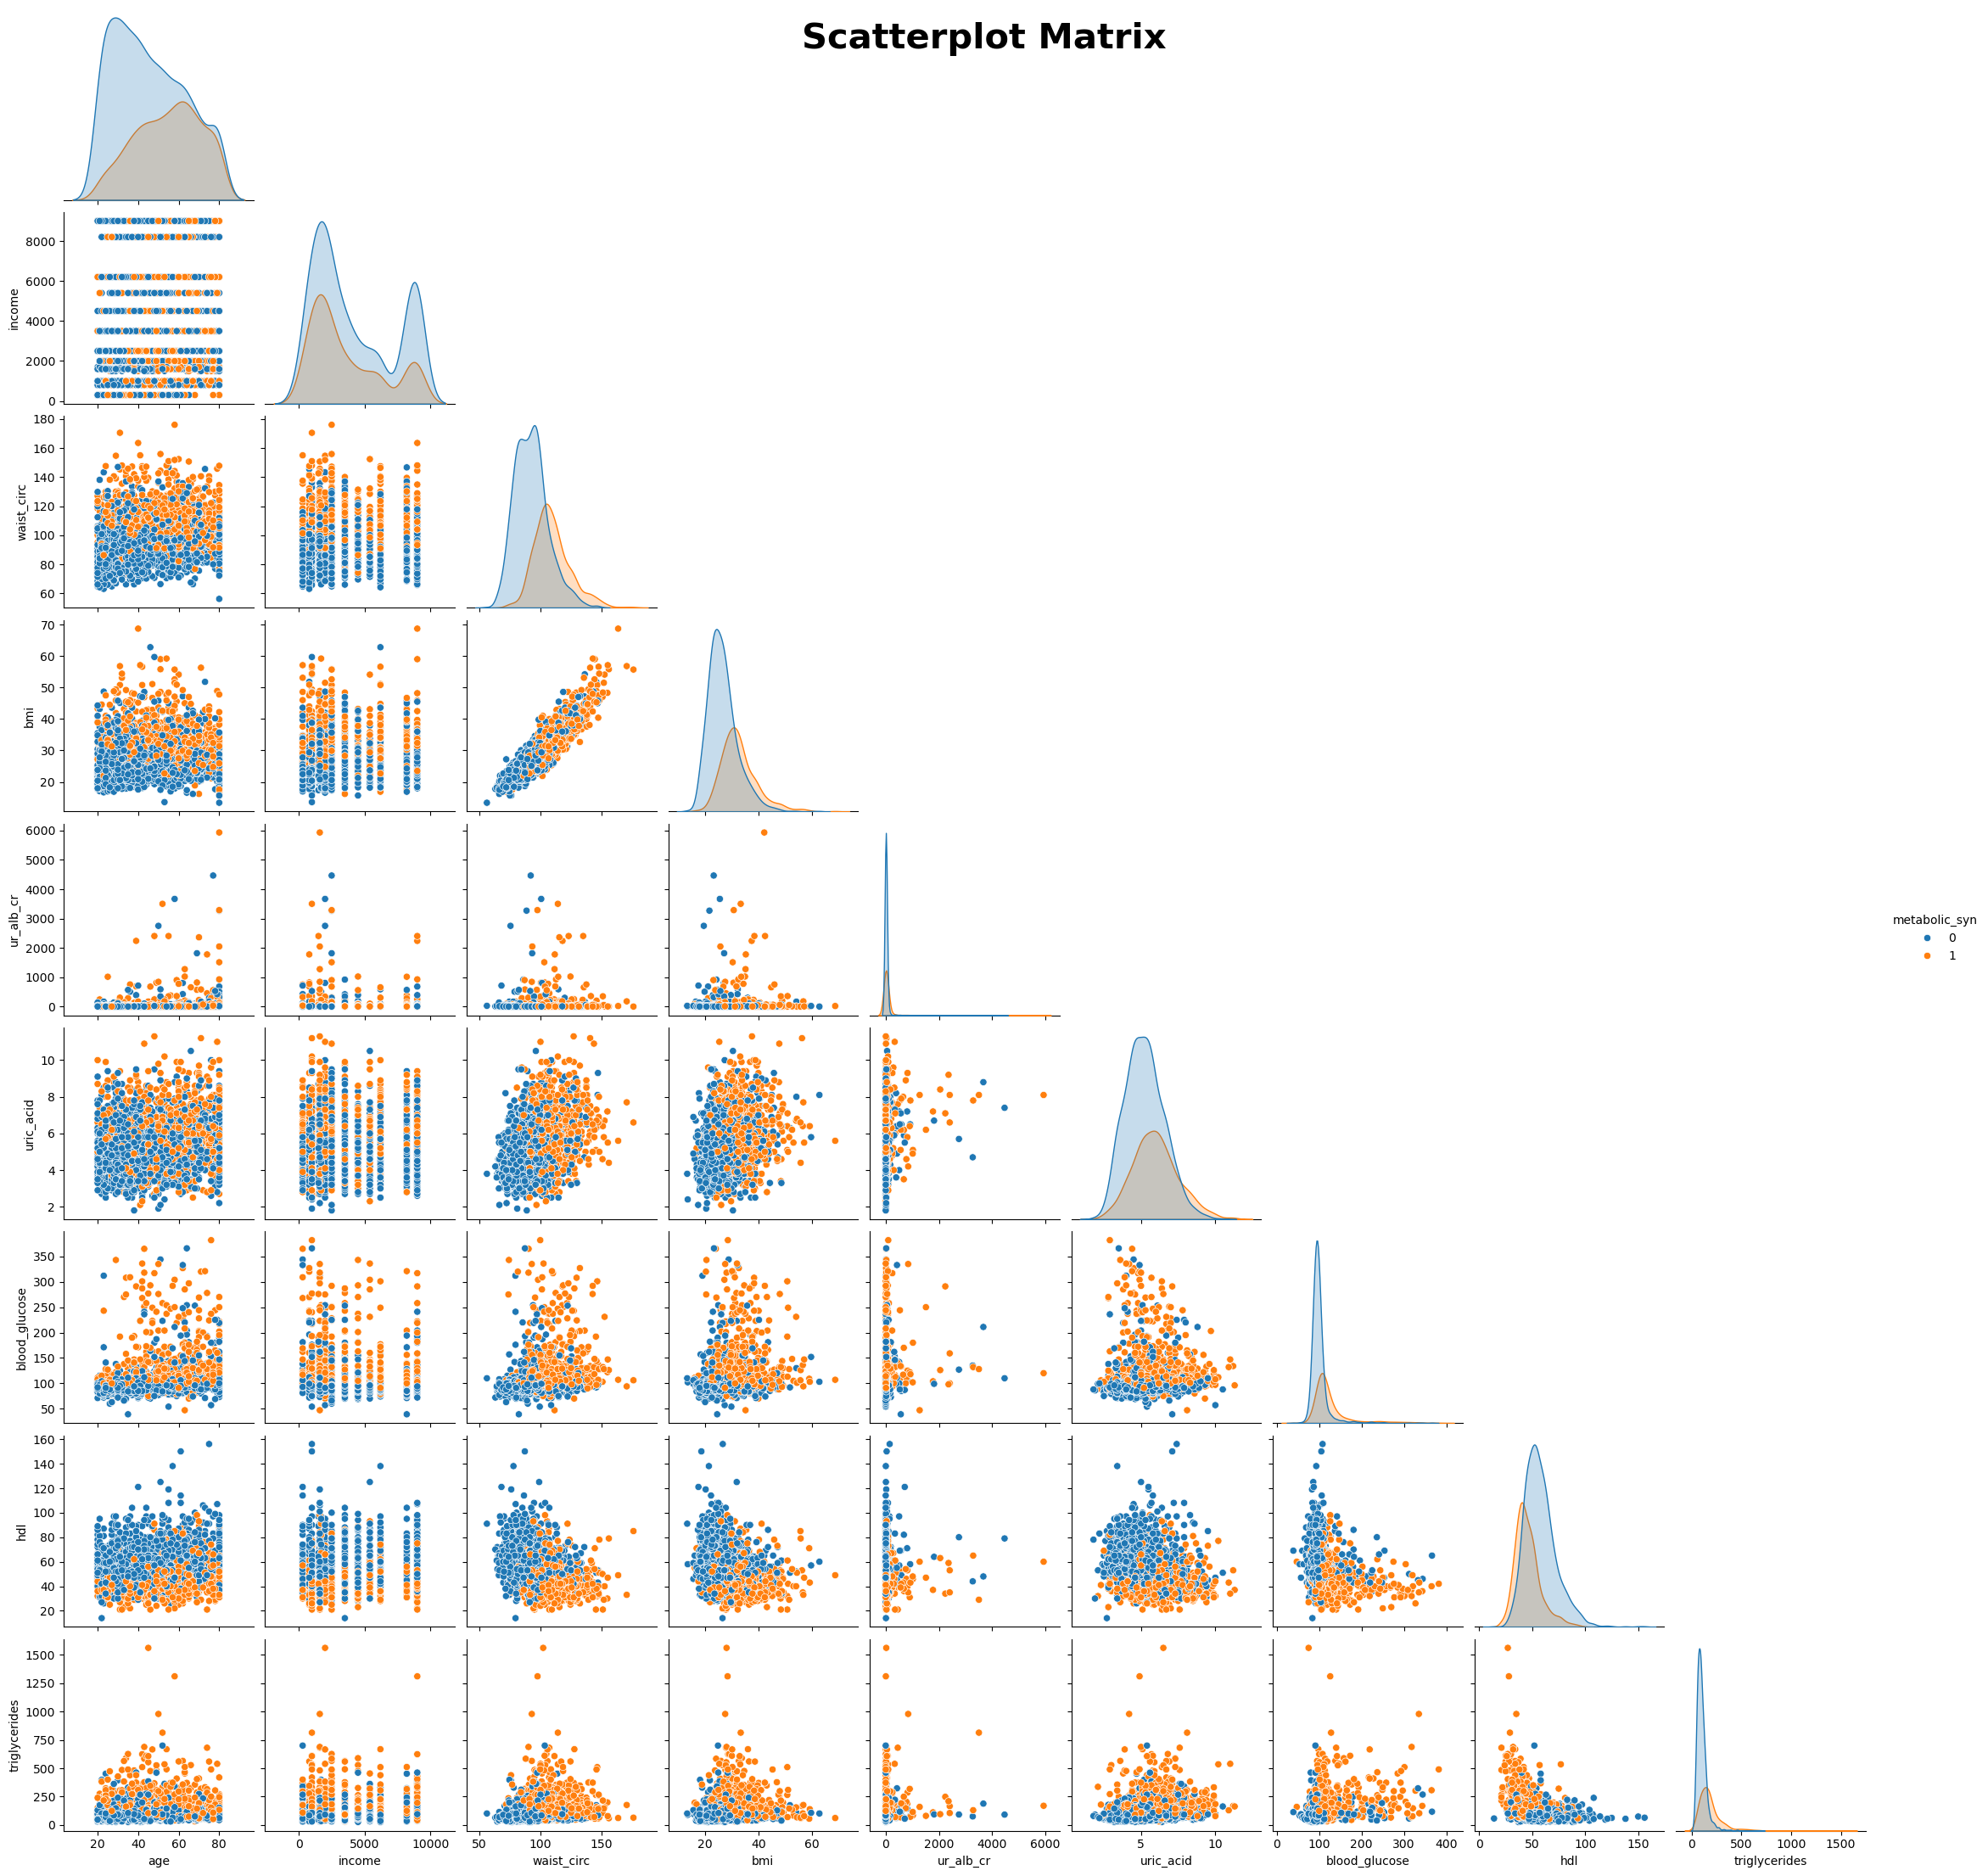

In [27]:
# Create scatterplot matrix for continuous features
scatterplot_matrix = sns.pairplot(data, vars=data[continuous_features], hue="metabolic_syn", corner=True)

# Add a title
plt.suptitle('Scatterplot Matrix', fontsize=30, fontweight='bold')

# Display the scatterplot matrix
plt.show()

## Boxplots

In [28]:
# Function to create boxplot matrix
def plot_boxplot_matrix(df, continuous_features_list):
    """
    Plots the boxplots for each continuous feature.
    """
    num_cols = 2
    num_rows = (len(continuous_features_list) + 1) // num_cols
    
    fig = make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(continuous_features_list):
        row = i // num_cols + 1
        col = i % num_cols + 1
        
        fig.add_trace(
            go.Box(
                x=df[feature],
                name=' '
            ),
            row=row,
            col=col
        )

        fig.update_xaxes(title_text=feature, row=row, col=col)
        fig.update_yaxes(title_text=' ', row=row, col=col)
        fig.update_layout(
            title = f"<b>Boxplot Matrix<br><sup>Continuous Features</sup></b>",
            showlegend=False)
    
        fig.update_layout(
            height=350*num_rows,
            width=1000,
            margin=dict(t=100, l=80),
            template=plotly_template)

    fig.show()

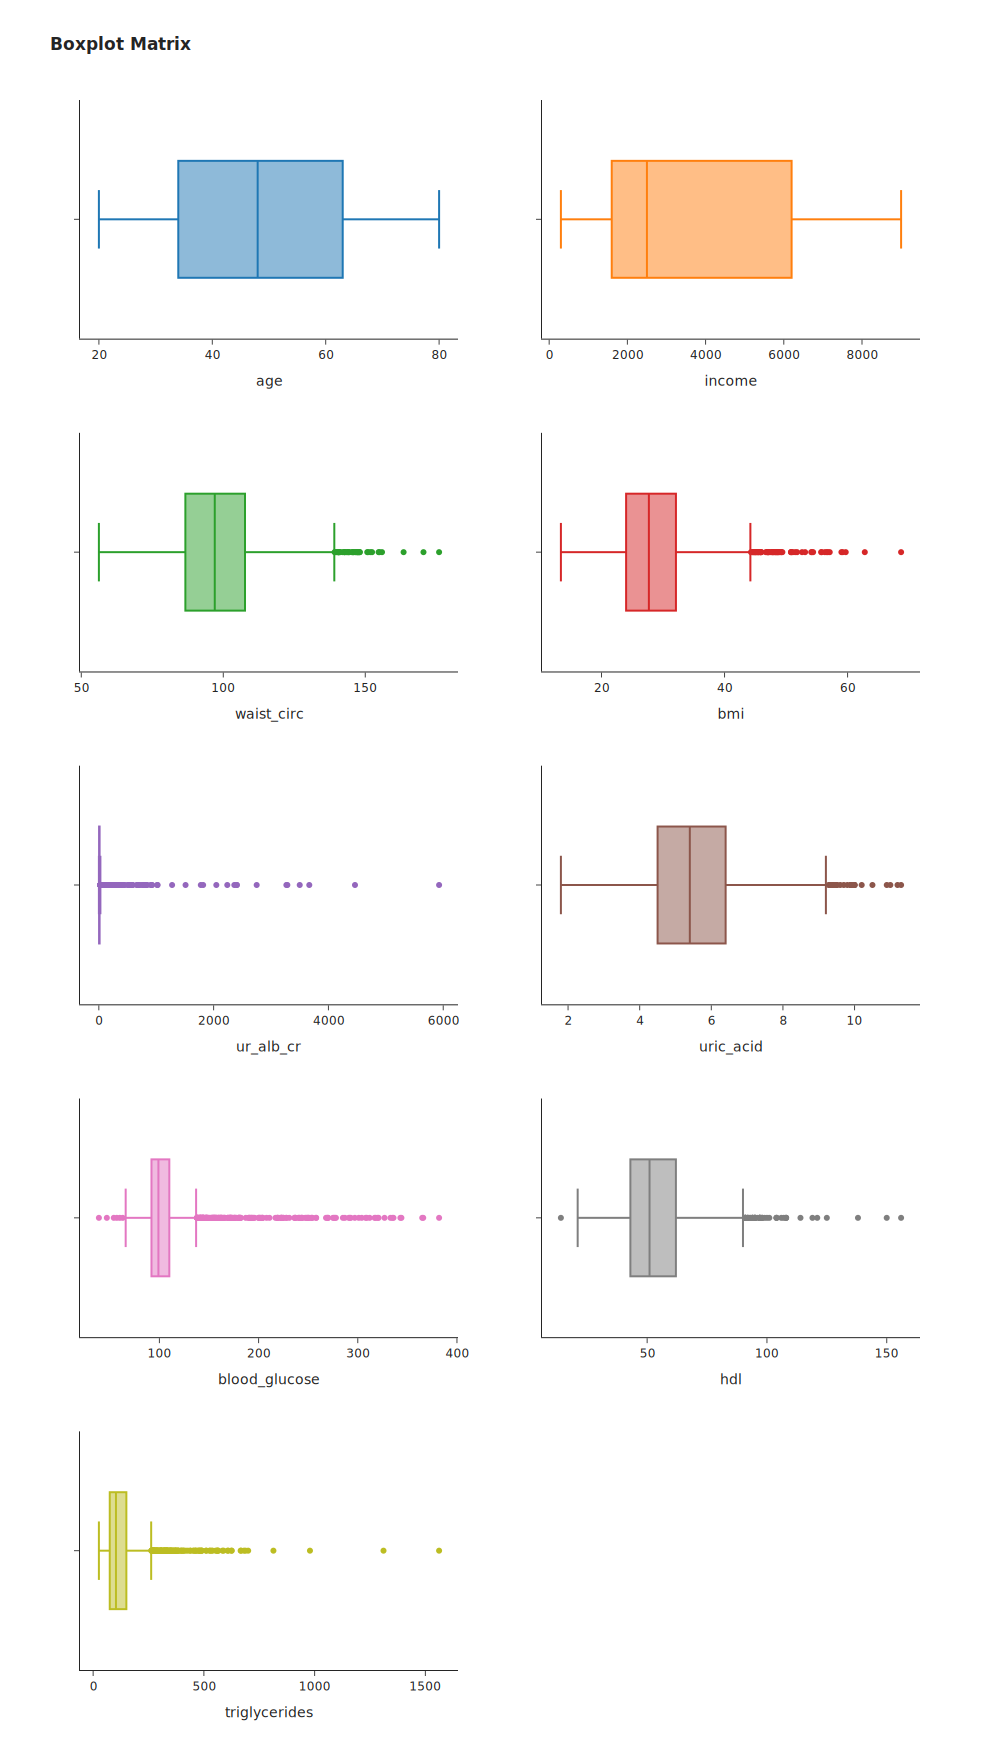

In [29]:
# Call the function
plot_boxplot_matrix(data, continuous_features)

## Violinplots

In [30]:
# Function to create violinplots
def plot_violinplots(df, y, x, color):
    """
    Plots violinplots for the continuous features with respect to the target class.
    """
    fig = px.violin(df, y=y, x=x, color=color, box=True, points="all")

    fig.update_layout(title = f"<b>Violinplot<br><sup>{x} by {y}</sup></b>",
                      showlegend=False,
                      yaxis=dict(tickangle=-45),
                      height=500,
                      width=1000,
                      margin=dict(t=100, l=80),
                      template=plotly_template)

    fig.show()

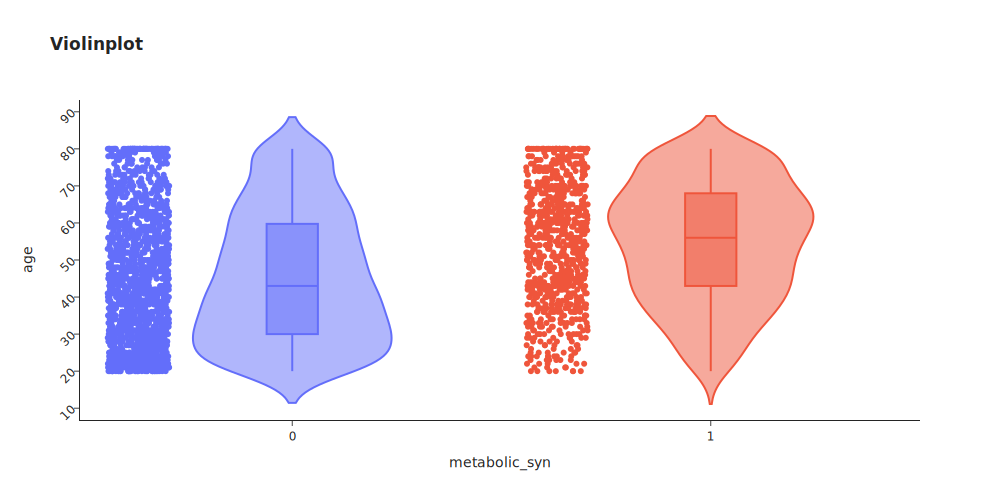

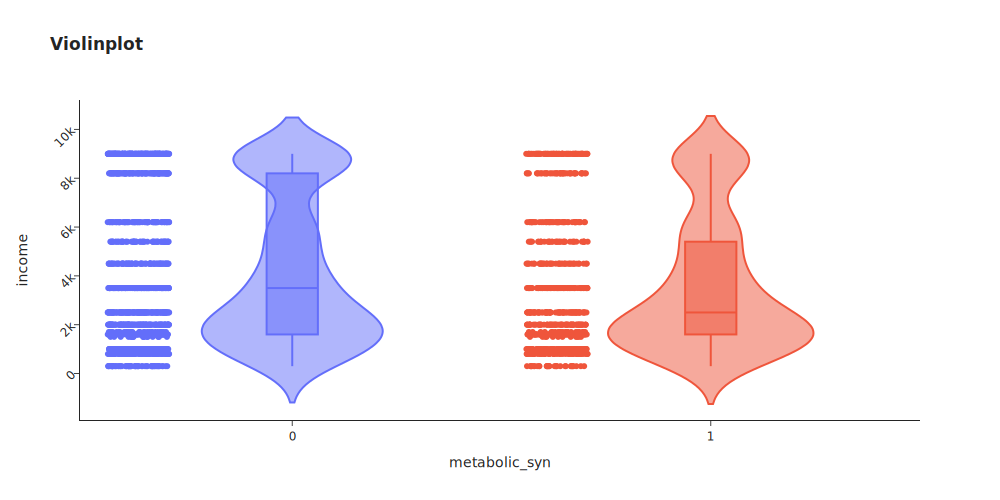

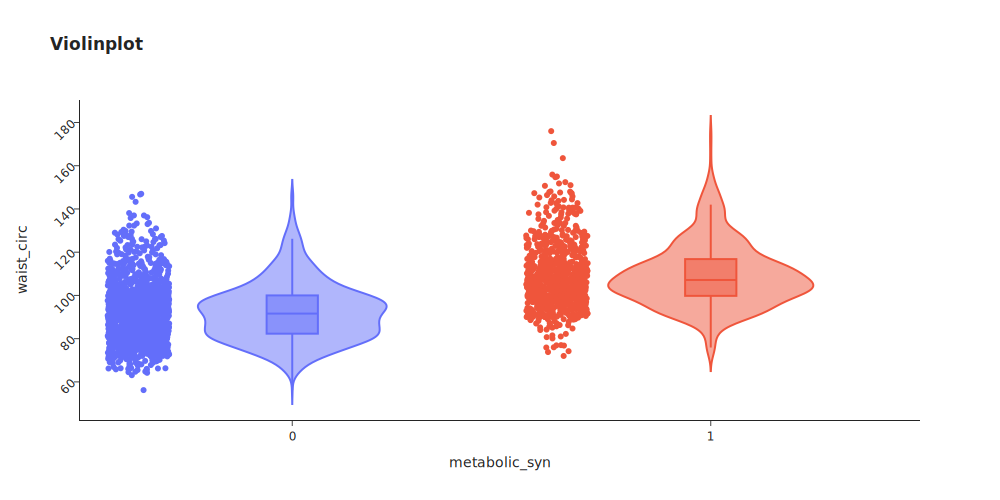

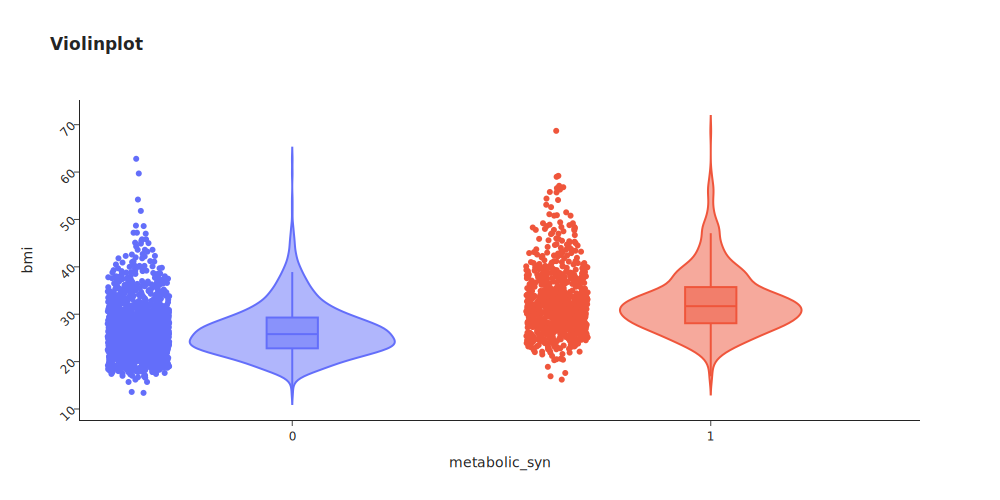

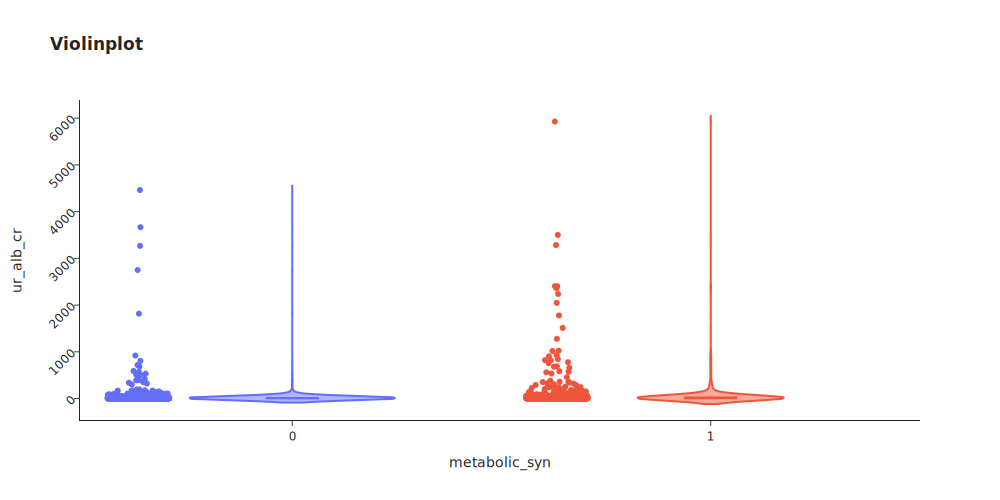

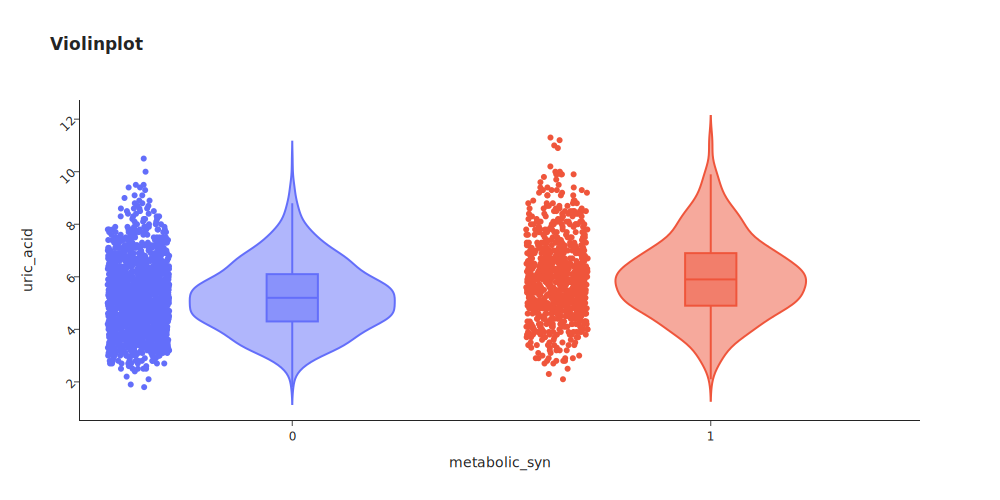

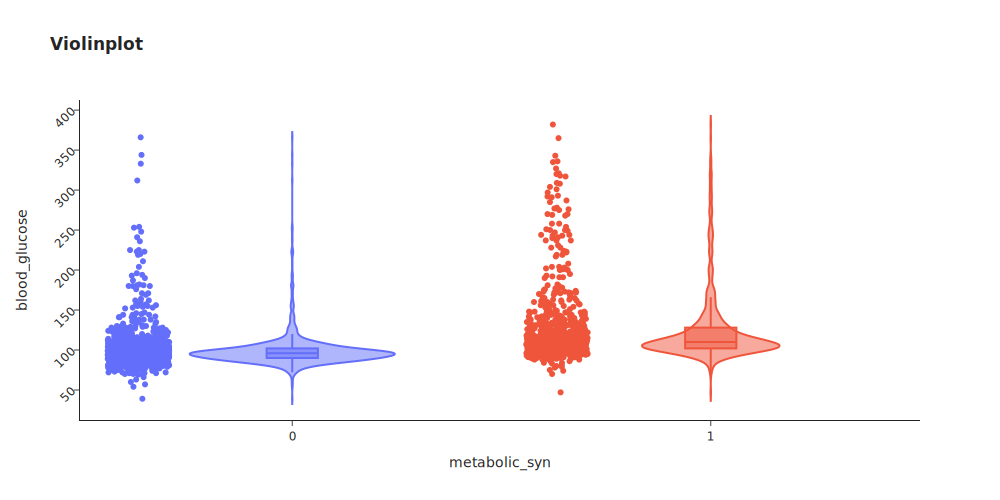

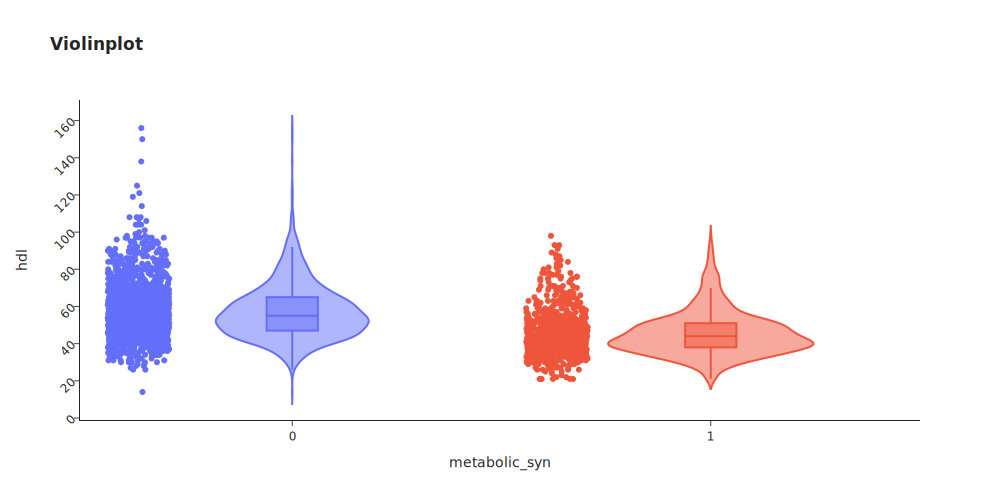

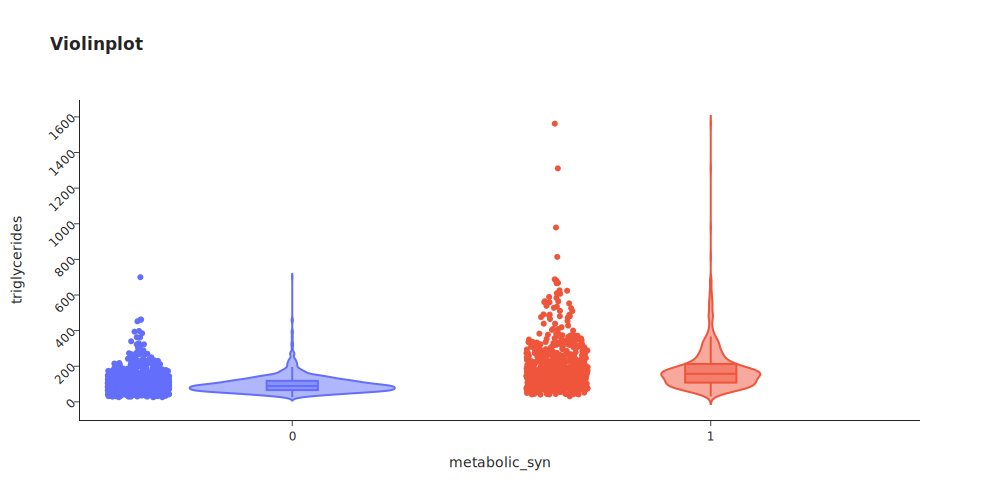

In [31]:
# Call the function
for feature in data[continuous_features]:
    plot_violinplots(data, feature, 'metabolic_syn', 'metabolic_syn')

## Barplots

In [32]:
# Function to plot barplots for categorical features
def plot_barplot(df, feature):
    """
    Plots a barplot for the feature.
    """
    counts = df[feature].value_counts()
    fig = px.bar(y=counts.values,
                 x=counts.index,
                 color=counts.index,
                 text=counts.values)

    fig.update_layout(title = f"<b>Barplot<br><sup>Barplot for {feature.capitalize()}</sup></b>",
                      xaxis=dict(title=f"{feature.capitalize()}"),
                      yaxis=dict(title='Count'),
                      legend=dict(title=f"Categories"),
                      showlegend=True,
                      height=400,
                      width=1000,
                      margin=dict(t=100, l=80),
                      template=plotly_template)

    fig.show()

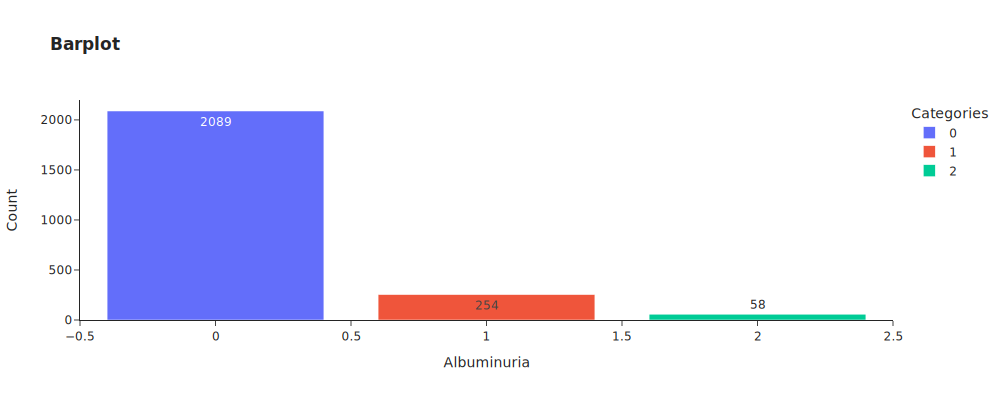

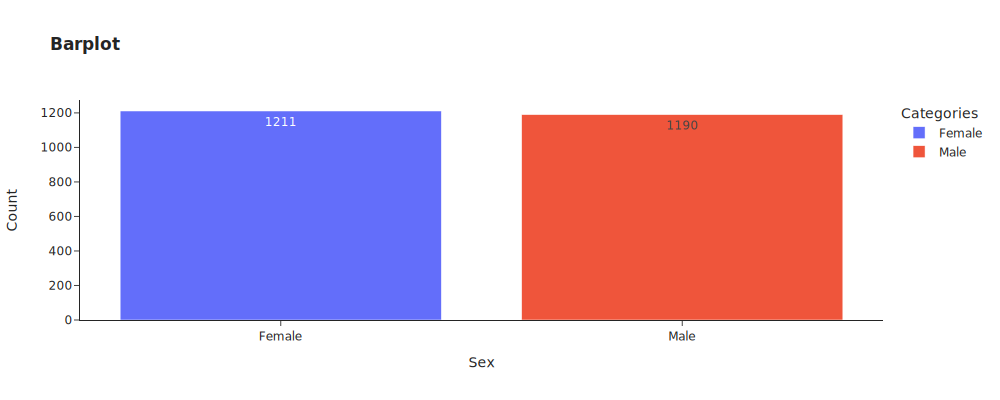

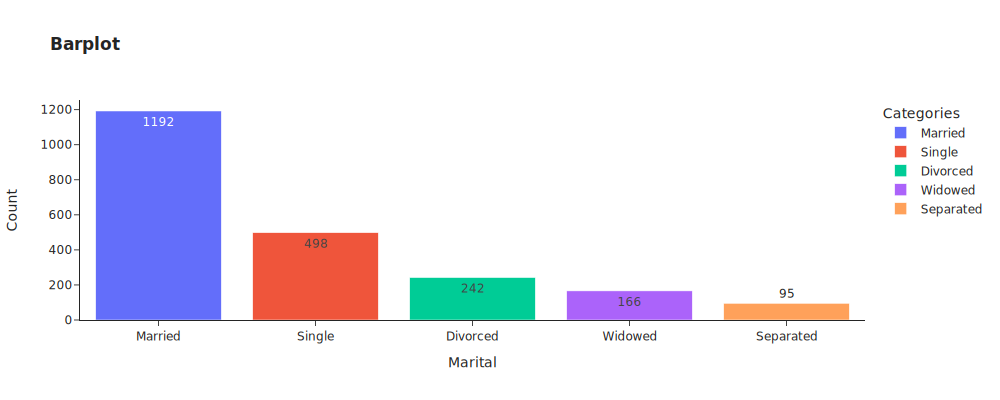

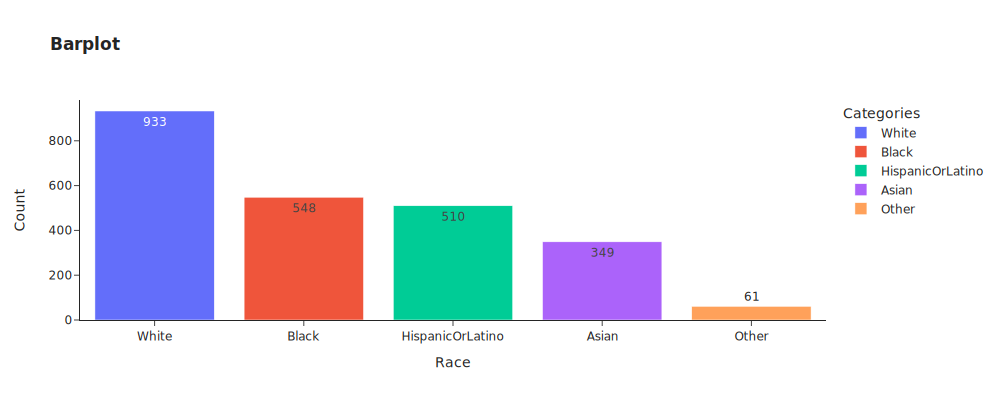

In [33]:
# Call the function
for feature in data[categorical_features]:
    plot_barplot(data, feature)

## Correlations

In [34]:
# Correlations
corr_df = data[continuous_features].corr()

# Display the DataFrame
print("Correlations for Continuous Features:\n")
corr_df

Correlations for Continuous Features:



age    income  waist_circ       bmi  ur_alb_cr  uric_acid  \
age            1.000000 -0.011982    0.226470  0.079916   0.118380   0.147928   
income        -0.011982  1.000000   -0.063519 -0.081061  -0.048996   0.007967   
waist_circ     0.226470 -0.063519    1.000000  0.908751   0.047630   0.355836   
bmi            0.079916 -0.081061    0.908751  1.000000   0.038740   0.272089   
ur_alb_cr      0.118380 -0.048996    0.047630  0.038740   1.000000   0.130928   
uric_acid      0.147928  0.007967    0.355836  0.272089   0.130928   1.000000   
blood_glucose  0.236610 -0.093311    0.261579  0.209645   0.106458   0.055943   
hdl            0.079368  0.077549   -0.352481 -0.292905   0.001667  -0.252587   
triglycerides  0.069885 -0.039772    0.236098  0.163758   0.077873   0.207328   

               blood_glucose       hdl  triglycerides  
age                 0.236610  0.079368       0.069885  
income             -0.093311  0.077549      -0.039772  
waist_circ          0.261579 -0.352481       0.236098  
bmi                 0.209645 -0.292905       0.163758  
ur_alb_cr           0.106458  0.001667       0.077873  
uric_acid           0.055943 -0.252587       0.207328  
blood_glucose       1.000000 -0.213905       0.269506  
hdl                -0.213905  1.000000      -0.388487  
triglycerides       0.269506 -0.388487       1.000000

In [35]:
# Function to plot the correlation heatmap
def plot_correlation_heatmap(corr_df):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))

    # Set up the figure
    fig = go.Figure(data=go.Heatmap(
        z=corr_df.mask(mask),
        x=corr_df.columns,
        y=corr_df.columns,
        colorscale=px.colors.diverging.RdBu,
        zmin=-1,
        zmax=1,
        hoverongaps=False
    ))

    # Customize the layout
    fig.update_layout(
        title_text='Correlation Heatmap of Continuous Variables',
        title_x=0.5,
        width=800,
        height=600,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        xaxis={'side': 'bottom'},
        yaxis=dict(autorange='reversed'),
        paper_bgcolor='white',
        plot_bgcolor='white',
    )

    # Update axes ticks font size
    fig.update_xaxes(tickfont=dict(size=10))
    fig.update_yaxes(tickfont=dict(size=10))

    # Show the figure
    fig.show()

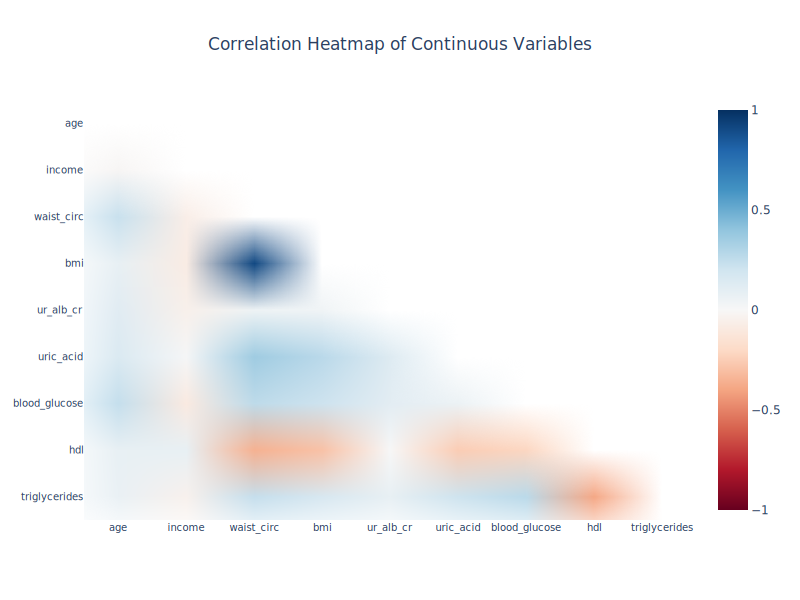

In [36]:
# Call the function
plot_correlation_heatmap(corr_df)

In [37]:
# Function to calculate the VIF for each continuous feature
def calculate_vif(df):
    """
    Calculate the Variance Inflation Factor for each variable in a DataFrame.
    """
    # Replacing missing values with the mean for each feature
    df_filled = df.fillna(df.mean())
    
    # Initialize the DataFrame
    vif_df = pd.DataFrame()
    vif_df["feature"] = df_filled.columns
    
    # Calculate VIF for each feature
    vif_df["VIF"] = [variance_inflation_factor(df_filled.values, i) for i in range(len(df_filled.columns))]
    
    # Sort the DataFrame by the VIF values in descending order
    vif_df = vif_df.sort_values(by=['VIF'], ascending=False).reset_index(drop=True)
    
    return vif_df

In [38]:
# Call the function
vif_df = calculate_vif(data[continuous_features])
vif_df

feature         VIF
0     waist_circ  165.251731
1            bmi   92.486519
2      uric_acid   17.627416
3  blood_glucose   11.988620
4            age   10.617822
5            hdl    9.988569
6  triglycerides    3.491531
7         income    2.934726
8      ur_alb_cr    1.067367

In [39]:
# Function to show the VIF per feature
def plot_VIF(vif_df):
    """
    Plots the VIF DataFrame results.
    """
    vif_df['VIF'] = vif_df['VIF'].round(2)

    # Create a color based on the VIF score
    vif_df['Color'] = 'Medium VIF'
    vif_df.loc[vif_df['VIF'] <= 5, 'Color'] = 'Low VIF'
    vif_df.loc[vif_df['VIF'] > 10, 'Color'] = 'High VIF'
    
    fig = px.bar(
        vif_df, 
        x='feature', 
        y='VIF', 
        title='Variance Inflation Factor Results',
        text='VIF',
        color='Color',
        category_orders={"Color": ["Low VIF", "Medium VIF", "High VIF"]}
    )
    
    # Update layout for width and height
    fig.update_layout(width=800, height=500)
    fig.show()

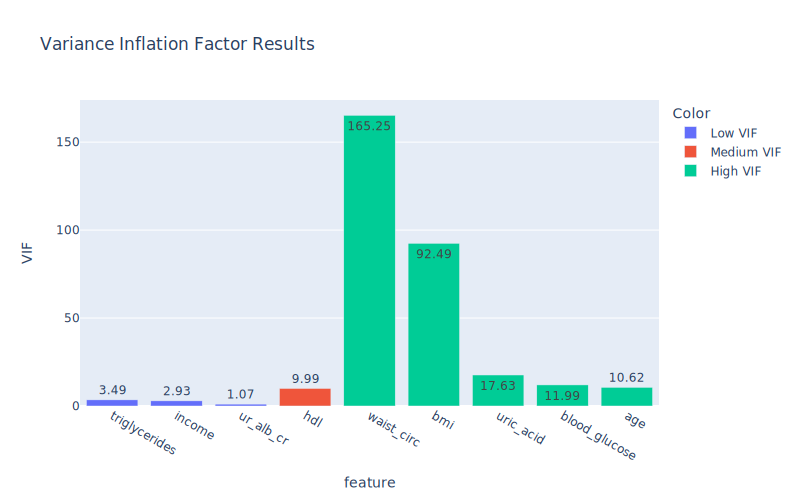

In [40]:
# Call the function
plot_VIF(vif_df)

## Contingencies

In [41]:
# Contingency table of metabolic syndrome by sex
contingency_table_sex = pd.crosstab(index=data['metabolic_syn'], columns=data['sex'], rownames=['Metabolic Syndrome'], colnames=['Sex'])

print("Contingency Table of Metabolic Syndrome by Sex:")
contingency_table_sex

Contingency Table of Metabolic Syndrome by Sex:


Sex                 Female  Male
Metabolic Syndrome              
0                      808   771
1                      403   419

In [42]:
# Function to perform Chi-squared test
def chi_squared_test(contingency_table):
    """
    Perform a chi-squared test and return the results in a DataFrame.
    """

    # Chi-squared test
    chi2_stat, p_value, degrees_of_freedom, expected_freqs = chi2_contingency(contingency_table)

    # Results DataFrame
    chi2_results_df = pd.DataFrame({
        'Chi2 Statistic': [chi2_stat],
        'p-value': [p_value],
        'Degrees of Freedom': [degrees_of_freedom]
    })

    return chi2_results_df

In [43]:
# Call the function
chi2_df_sex = chi_squared_test(contingency_table_sex)
chi2_df_sex

Chi2 Statistic   p-value  Degrees of Freedom
0        0.910891  0.339878                   1

In [44]:
# Function to plot the mosaicplot
def plot_mosaicplot(df, binary_features, binary_target, figsize=(20, 15)):
    """
    Plots a mosaicplot of each binary feature by the binary target.
    """
    plt.figure(figsize=figsize)

    for i, feature in enumerate(binary_features):
        
        # Ensure we have a categorical feature with ordered categories
        df[feature] = pd.Categorical(df[feature], categories=sorted(df[feature].unique()), ordered=True)
        
        # Create mosaic plot
        mosaic(df, [binary_target, feature], title=f'Mosaic Plot of {feature} by {binary_target}', 
               labelizer=lambda k: '', 
               properties=lambda key: {'facecolor': 'pink' if key[0] == '0' else 'skyblue', 
                                       'edgecolor': 'white', 'linewidth': 0.03})
        plt.xlabel(binary_target)
        plt.ylabel(feature)
        plt.show()

<Figure size 2000x1500 with 0 Axes>

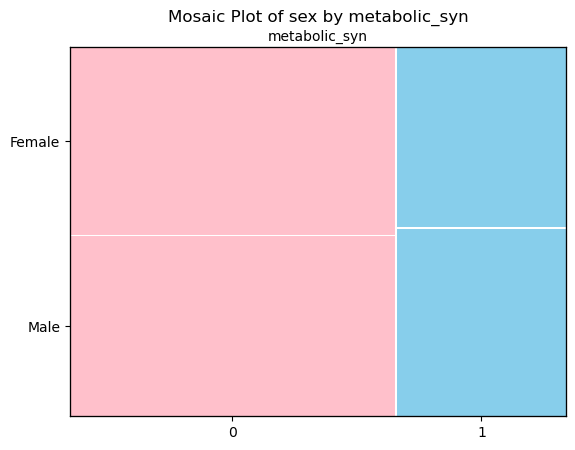

In [45]:
# Call the function
plot_mosaicplot(data, binary_features, 'metabolic_syn')

In [46]:
# Contingency table of metabolic syndrome by albuminuria
contingency_table_albuminuria = pd.crosstab(index=data['metabolic_syn'], columns=data['albuminuria'], rownames=['Metabolic Syndrome'], colnames=['Albuminuria'])

print("Contingency Table of Metabolic Syndrome by Albuminuria:")
contingency_table_albuminuria

Contingency Table of Metabolic Syndrome by Albuminuria:


Albuminuria            0    1   2
Metabolic Syndrome               
0                   1434  123  22
1                    655  131  36

In [47]:
# Perform Chi-squared test
chi2_df_albuminuria = chi_squared_test(contingency_table_albuminuria)
chi2_df_albuminuria

Chi2 Statistic       p-value  Degrees of Freedom
0       61.574664  4.258254e-14                   2

In [48]:
# Function to plot spineplots for ordinal vs. binary relationships
def plot_spineplots(df, ordinal_feature, binary_target):
    """
    Plots spineplots for an ordinal variable against a binary target variable.
    """
    # Calculate the proportion of binary_target for each category
    prop_df = (df.groupby(ordinal_feature)[binary_target]
               .value_counts(normalize=True)
               .unstack()
               .fillna(0))
    
    # Plot stacked bars
    prop_df.plot(kind='bar', stacked=True, figsize=(10, 6))

    plt.title(f'Spineplot of {binary_target} by {ordinal_feature}')
    plt.xlabel(ordinal_feature)
    plt.ylabel('Proportion')
    plt.legend(title=binary_target, loc='upper right')
    plt.xticks(rotation=0)
    plt.show()

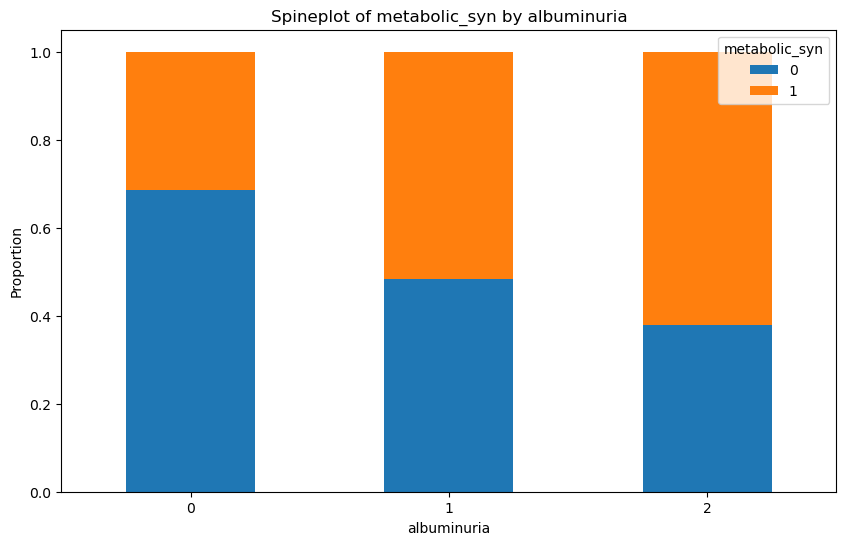

In [49]:
# Call the function
plot_spineplots(data, 'albuminuria', 'metabolic_syn')

In [50]:
# Contingency table of metabolic syndrome by marital
contingency_table_marital = pd.crosstab(index=data['metabolic_syn'], columns=data['marital'], rownames=['Metabolic Syndrome'], colnames=['Marital Status'])

print("Contingency Table of Metabolic Syndrome by Marital Status:")
contingency_table_marital

Contingency Table of Metabolic Syndrome by Marital Status:


Marital Status      Divorced  Married  Separated  Single  Widowed
Metabolic Syndrome                                               
0                        145      757         61     375       95
1                         97      435         34     123       71

In [51]:
# Perform Chi-squared test
chi2_df_marital = chi_squared_test(contingency_table_marital)
chi2_df_marital

Chi2 Statistic   p-value  Degrees of Freedom
0       31.608385  0.000002                   4

In [52]:
# Contingency table of metabolic syndrome by race
contingency_table_race = pd.crosstab(index=data['metabolic_syn'], columns=data['race'], rownames=['Metabolic Syndrome'], colnames=['Race'])

print("Contingency Table of Metabolic Syndrome by Race:")
contingency_table_race

Contingency Table of Metabolic Syndrome by Race:


Race                Asian  Black  HispanicOrLatino  Other  White
Metabolic Syndrome                                              
0                     268    367               304     44    596
1                      81    181               206     17    337

In [53]:
# Perform Chi-squared test
chi2_df_race = chi_squared_test(contingency_table_race)
chi2_df_race

Chi2 Statistic   p-value  Degrees of Freedom
0        30.35603  0.000004                   4

In [54]:
# Function to plot grouped bar charts for each nominal feature
def plot_grouped_barcharts(df, nominal_features, binary_target):
    """
    Creates a grouped bar chart for each nominal variable by the binary target variable.
    """
    # Convert the target to a string
    df_new = df.copy()
    df_new[binary_target] = df_new[binary_target].astype(str)
    
    for nominal_feature in nominal_features:
        # Compute the counts and proportions for each combination
        group_counts = df_new.groupby([nominal_feature, binary_target]).size().reset_index(name='counts')
        group_total = df_new.groupby([nominal_feature]).size().reset_index(name='total')
        proportion_df = group_counts.merge(group_total, on=nominal_feature)
        proportion_df['proportion'] = proportion_df['counts'] / proportion_df['total']
        
        # Create the bar chart for proportions
        fig = px.bar(
            proportion_df,
            x=nominal_feature,
            y='proportion',
            color=binary_target,
            color_discrete_map={0: 'blue', 1: 'yellow'},
            barmode='group',
            title=f"<b>Grouped Bar Chart<br><sup>Proportions of {nominal_feature} by {binary_target}</sup></b>"
        )
        
        # Customize the layout
        fig.update_layout(
            height=400, width=1000,
            xaxis_title=nominal_feature,
            yaxis_title='Proportion',
            legend_title=binary_target,
            template=plotly_template
        )
        
        fig.show()

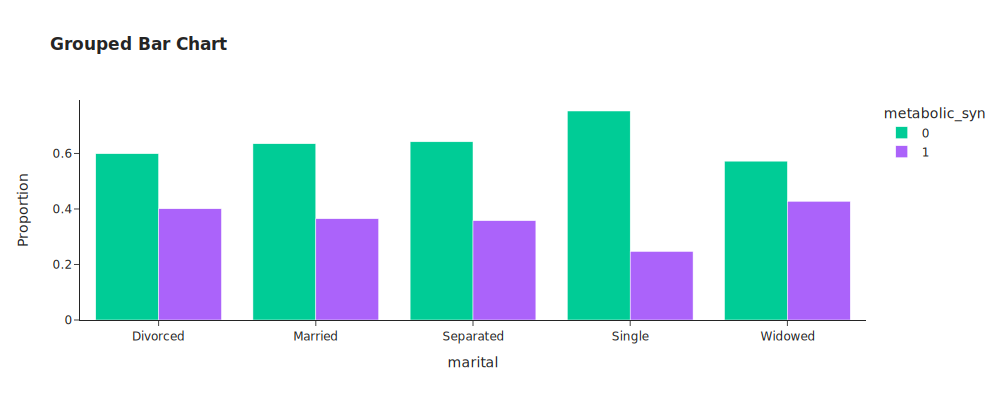

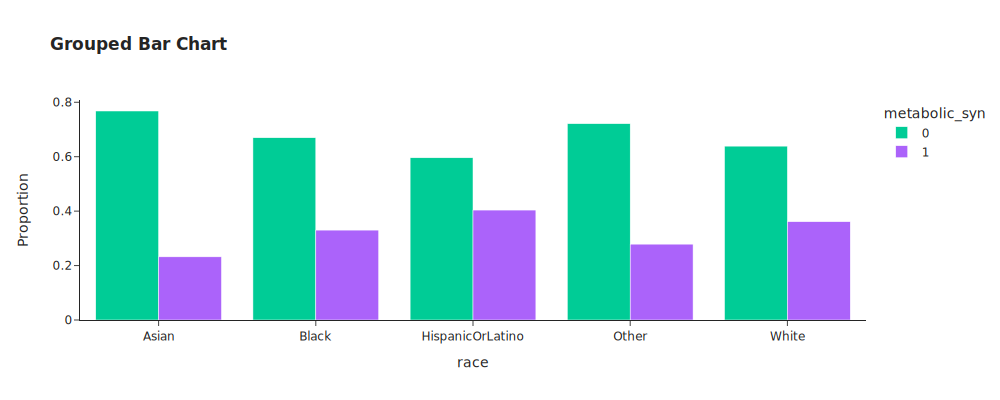

In [55]:
# Call the function
plot_grouped_barcharts(data, nominal_features, 'metabolic_syn')

## Aggregations

In [56]:
# Create data copy
data_copy = data.copy()

# Replace missing values for continuous features with the mean
for col in continuous_features:
    data_copy[col].fillna(data_copy[col].mean(), inplace=True)

# Replace missing values for categorical features with the mode
non_ordinal_features = [col for col in categorical_features if col not in ordinal_features]

for col in non_ordinal_features:
    data_copy[col].fillna(data_copy[col].mode()[0], inplace=True)

In [57]:
# Bin age into five groups
age_bins = [20, 35, 50, 65, 80]
age_labels = ['20-35', '36-50', '51-65', '66-80']
data_copy['age_group'] = pd.cut(data_copy['age'], bins=age_bins, labels=age_labels, right=False)

# Bin income into four groups
income_bins = [0, 2000, 4000, 6000, 9000]
income_labels = ['0-2k', '2k-4k', '4k-6k', '6k+']
data_copy['income_group'] = pd.cut(data_copy['income'], bins=income_bins, labels=income_labels, right=False)

In [58]:
# Pivot table of metabolic syndrome by age group, sex, and race
pivot_age_sex_race = pd.pivot_table(
    data_copy,
    values='metabolic_syn',
    index=['age_group', 'sex', 'race'],
    aggfunc=np.mean
)

pivot_age_sex_race

metabolic_syn
age_group sex    race                           
20-35     Female Asian                  0.072727
                 Black                  0.180723
                 HispanicOrLatino       0.171875
                 Other                  0.000000
                 White                  0.186916
          Male   Asian                  0.192982
                 Black                  0.133333
                 HispanicOrLatino       0.192308
                 Other                  0.090909
                 White                  0.172727
36-50     Female Asian                  0.277778
                 Black                  0.256410
                 HispanicOrLatino       0.288136
                 Other                  0.285714
                 White                  0.256198
          Male   Asian                  0.244898
                 Black                  0.333333
                 HispanicOrLatino       0.500000
                 Other                  0.428571
                 White                  0.398496
51-65     Female Asian                  0.225806
                 Black                  0.488636
                 HispanicOrLatino       0.525000
                 Other                  0.571429
                 White                  0.362745
          Male   Asian                  0.204545
                 Black                  0.409639
                 HispanicOrLatino       0.507042
                 Other                  0.250000
                 White                  0.494845
66-80     Female Asian                  0.370370
                 Black                  0.500000
                 HispanicOrLatino       0.648649
                 Other                  0.600000
                 White                  0.551724
          Male   Asian                  0.440000
                 Black                  0.285714
                 HispanicOrLatino       0.525000
                 Other                  0.666667
                 White                  0.505747

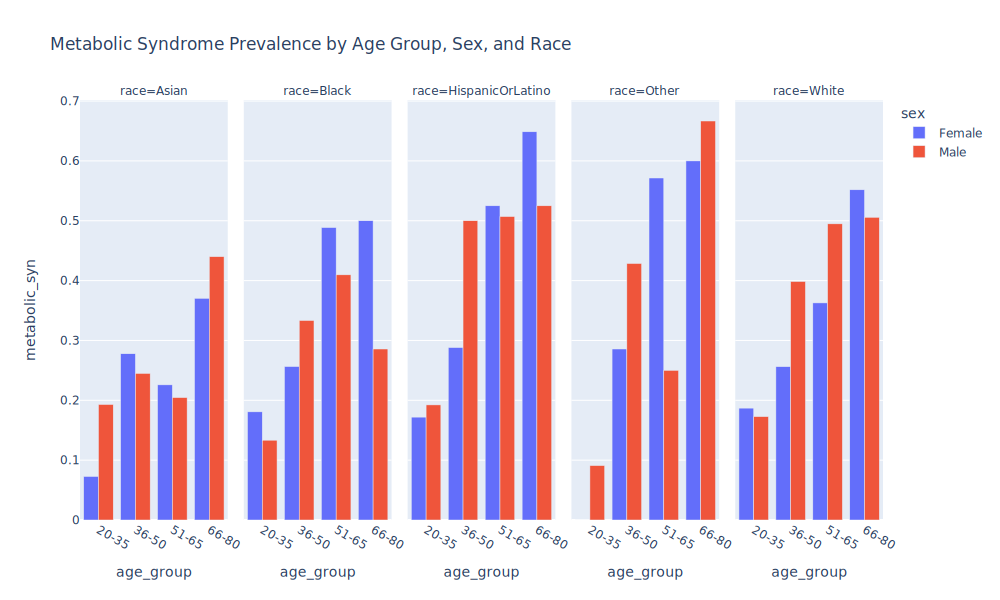

In [59]:
# Reset the index
pivot_age_sex_race_reset = pivot_age_sex_race.reset_index()

# Create a bar plot
fig = px.bar(
    pivot_age_sex_race_reset,
    height=600, width=1000,
    x='age_group',
    y='metabolic_syn',
    color='sex',
    facet_col='race',
    barmode='group',
    title='Metabolic Syndrome Prevalence by Age Group, Sex, and Race'
)

# Display the plot
fig.show()

In [60]:
# Pivot table of health metrics by metabolic syndrome and income
pivot_health_income = pd.pivot_table(
    data_copy,
    values=['blood_glucose', 'hdl', 'triglycerides'],
    index=['metabolic_syn', 'income_group'],
    aggfunc=np.mean
)

pivot_health_income

blood_glucose        hdl  triglycerides
metabolic_syn income_group                                         
0             0-2k             101.422897  57.170561      97.834112
              2k-4k            100.053097  56.639381      98.869469
              4k-6k             98.272340  57.140426      97.714894
              6k+               96.004695  56.816901      99.882629
1             0-2k             129.246324  45.169118     180.588235
              2k-4k            124.454167  45.520833     197.962500
              4k-6k            128.578512  45.785124     175.504132
              6k+              119.592233  45.446602     168.223301

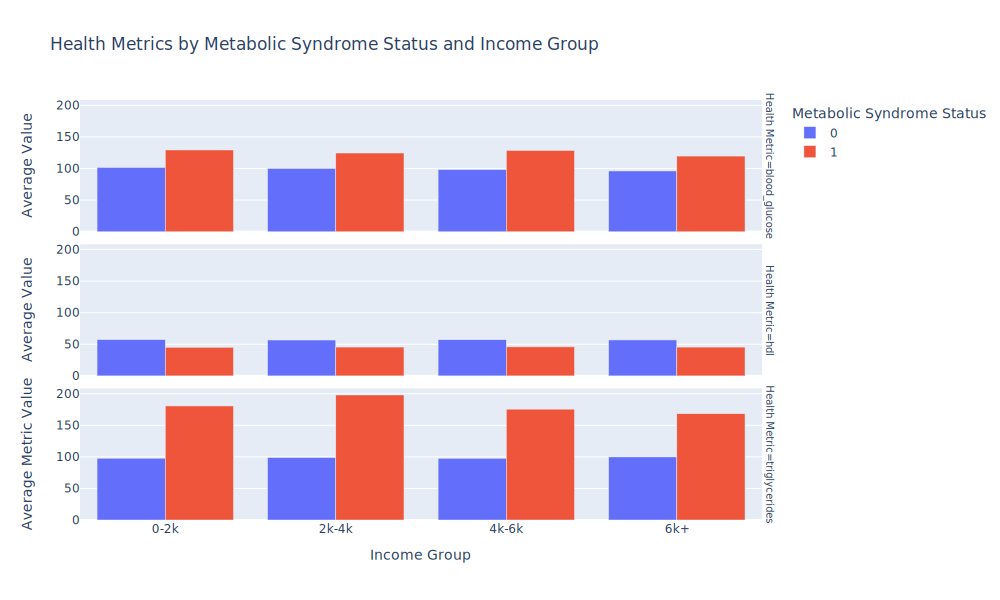

In [61]:
# Reset the index
pivot_health_income_reset = pivot_health_income.reset_index()

# Melt the DataFrame to long format for plotting
melted_health_income = pivot_health_income_reset.melt(
    id_vars=['metabolic_syn', 'income_group'],
    value_vars=['blood_glucose', 'hdl', 'triglycerides'],
    var_name='Health Metric',
    value_name='Average Value'
)

# Convert the target to a string
melted_health_income['metabolic_syn'] = melted_health_income['metabolic_syn'].astype(str)

# Create a bar plot for each health metric
fig = px.bar(
    melted_health_income,
    x='income_group',
    y='Average Value',
    color='metabolic_syn',
    barmode='group',
    facet_row='Health Metric',
    category_orders={"metabolic_syn": ["0", "1"]},
    title='Health Metrics by Metabolic Syndrome Status and Income Group'
)

# Update the layout
fig.update_layout(
    xaxis_title='Income Group',
    yaxis_title='Average Metric Value',
    legend_title='Metabolic Syndrome Status',
    height=600,
    width=1000
)

# Make the Health Metric text smaller
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

# Display the plot
fig.show()

## Other Tests

In [62]:
# Function to perform Mann-Whitney U test
def perform_mann_whitney_u_test(data, group_col, continuous_col):
    # Split the data into groups
    group1 = data[data[group_col] == 0][continuous_col]
    group2 = data[data[group_col] == 1][continuous_col]
    
    # Perform the Mann-Whitney U Test
    u_statistic, p_value = mannwhitneyu(group1, group2)
    
    # Create a results dataframe
    results = pd.DataFrame({
        'U Statistic': [u_statistic],
        'p-value': [p_value]
    })
    
    return results

In [63]:
# Call the function
mann_whitney_results = perform_mann_whitney_u_test(data, 'metabolic_syn', 'age')
mann_whitney_results

U Statistic       p-value
0     449338.0  3.042607e-35

In [64]:
# Function to perform point-biserial correlation
def perform_point_biserial_correlation(data, group_col, continuous_col):
    # Calculate the point-biserial correlation
    correlation, p_value = pointbiserialr(data[group_col], data[continuous_col])

    # Create a results DataFrame
    results = pd.DataFrame({
        'Correlation': [correlation],
        'p-value': [p_value]
    })

    return results

In [65]:
# Call the function
point_biserial_results = perform_point_biserial_correlation(data, 'metabolic_syn', 'blood_glucose')
point_biserial_results

Correlation       p-value
0     0.362219  2.423359e-75

# Partitioning the Data

In [66]:
# Load cleaned dataset - missing values retained intentionally
data = pd.read_csv('/Users/williamjowens/Desktop/Datasets/clean_data_metabolic_syndrome.csv')
data.head()

age     sex  marital  income   race  waist_circ   bmi  albuminuria  \
0  22.0    Male   Single  8200.0  White        81.0  23.3            0   
1  44.0  Female  Married  4500.0  White        80.1  23.2            0   
2  21.0    Male   Single   800.0  Asian        69.6  20.1            0   
3  43.0  Female   Single  2000.0  Black       120.4  33.3            0   
4  51.0    Male  Married     NaN  Asian        81.1  20.1            0   

   ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  metabolic_syn  
0       3.88        4.9           92.0  41.0           84.0              0  
1       8.55        4.5           82.0  28.0           56.0              0  
2       5.07        5.4          107.0  43.0           78.0              0  
3       5.22        5.0          104.0  73.0          141.0              0  
4       8.13        5.0           95.0  43.0          126.0              0

In [67]:
# Ensure that the datatypes are either 'float' or 'category'
continuous_list = ['age', 'income', 'waist_circ', 'bmi', 'ur_alb_cr', 'uric_acid', 'blood_glucose', 'hdl', 'triglycerides']
categorical_list = ['sex', 'marital', 'race', 'albuminuria']

data[continuous_list] = data[continuous_list].astype('float')
data[categorical_list] = data[categorical_list].astype('category')
data['metabolic_syn'] = data['metabolic_syn'].astype('category')

In [68]:
# Get quick information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            2401 non-null   float64 
 1   sex            2401 non-null   category
 2   marital        2193 non-null   category
 3   income         2284 non-null   float64 
 4   race           2401 non-null   category
 5   waist_circ     2316 non-null   float64 
 6   bmi            2375 non-null   float64 
 7   albuminuria    2401 non-null   category
 8   ur_alb_cr      2401 non-null   float64 
 9   uric_acid      2401 non-null   float64 
 10  blood_glucose  2401 non-null   float64 
 11  hdl            2401 non-null   float64 
 12  triglycerides  2401 non-null   float64 
 13  metabolic_syn  2401 non-null   category
dtypes: category(5), float64(9)
memory usage: 181.5 KB


In [69]:
# Split the dataset
X = data.drop('metabolic_syn', axis=1)
y = data['metabolic_syn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [70]:
# View X_train
X_train.head()

age     sex    marital  income              race  waist_circ   bmi  \
892   24.0    Male        NaN  2500.0  HispanicOrLatino       110.7  34.9   
409   21.0  Female    Married  3500.0  HispanicOrLatino        82.7  22.0   
1781  44.0    Male        NaN  1000.0             Black       105.0  28.0   
1521  63.0    Male    Married  1000.0             Asian        89.5  22.3   
1050  50.0  Female  Separated  6200.0  HispanicOrLatino       105.0  34.9   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  
892            0       2.77        6.7          109.0  30.0          274.0  
409            0       5.56        4.3           89.0  48.0           65.0  
1781           0       2.27        5.9           93.0  43.0           44.0  
1521           0      11.47        6.9          169.0  48.0          199.0  
1050           0       8.08        4.8           97.0  57.0          115.0

In [71]:
# View X_test
X_test.head()

age     sex    marital  income              race  waist_circ   bmi  \
340   54.0  Female    Married  8200.0             White        95.2  27.1   
398   22.0  Female     Single  4500.0             White        73.0  18.3   
1707  58.0    Male  Separated  2500.0  HispanicOrLatino        99.9  27.0   
1038  35.0    Male        NaN  2000.0             White       102.0  28.3   
899   26.0  Female    Married  1600.0  HispanicOrLatino       123.2  38.5   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  
340            0       8.75        3.1           89.0  62.0          168.0  
398            0       5.32        4.1          106.0  51.0           79.0  
1707           0       3.16        4.7           98.0  50.0           73.0  
1038           0       8.35        6.9           88.0  53.0          205.0  
899            0      11.21        6.1          107.0  64.0           85.0

In [72]:
# Partition shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (1920, 13)
Shape of X_test: (481, 13)


In [73]:
# Target class distribution
print(f"Number of observations per class:\n{y_train.value_counts()}")

Number of observations per class:
metabolic_syn
0    1263
1     657
Name: count, dtype: int64


# MICE Imputation

In [74]:
# Function to perform MICEForest imputation
def miceforest_impute(data, new_data=None, kernel=None, optimize=True, optimization_steps=5, iterations=3,
                      mean_match_scheme=mf.mean_match_shap, random_state=0):
    if kernel is None:
        # Initialize the Imputation Kernel
        kernel = mf.ImputationKernel(
            data,
            datasets=1,
            mean_match_scheme=mean_match_scheme,
            save_all_iterations=True,
            random_state=random_state
        )

        # Optimize the parameters
        if optimize:
            optimal_parameters, losses = kernel.tune_parameters(
                dataset=0,
                optimization_steps=optimization_steps
            )
            # Run MICE with tuned parameters
            kernel.mice(iterations=iterations, variable_parameters=optimal_parameters)
        else:
            # Run MICE without parameter tuning
            kernel.mice(iterations=iterations)
        
        # Get the imputed dataset
        completed_data = kernel.complete_data(dataset=0)
        # Return all three values, with None for the new_data_imputed placeholder
        return kernel, completed_data, None

    else:
        if new_data is not None:
            # Impute new data with existing model
            new_data_imputed = kernel.impute_new_data(new_data=new_data).complete_data(0)
            # Return the kernel, None for the completed_data placeholder, and the new_data_imputed
            return kernel, None, new_data_imputed

In [75]:
# Impute training data and get the imputation kernel
kernel, X_train_imputed, _ = miceforest_impute(X_train, optimize=True, random_state=0)

# Impute test data using the same kernel
_, _, X_test_imputed = miceforest_impute(None, new_data=X_test, kernel=kernel, optimize=False)

In [76]:
# Check for missing values in imputed X_train
X_train_imputed.isnull().sum()

age              0
sex              0
marital          0
income           0
race             0
waist_circ       0
bmi              0
albuminuria      0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64

In [77]:
# Check for missing values in imputed X_test
X_test_imputed.isnull().sum()

age              0
sex              0
marital          0
income           0
race             0
waist_circ       0
bmi              0
albuminuria      0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64

In [78]:
# View imputed X_train
X_train_imputed.head()

age     sex    marital  income              race  waist_circ   bmi  \
892   24.0    Male     Single  2500.0  HispanicOrLatino       110.7  34.9   
409   21.0  Female    Married  3500.0  HispanicOrLatino        82.7  22.0   
1781  44.0    Male     Single  1000.0             Black       105.0  28.0   
1521  63.0    Male    Married  1000.0             Asian        89.5  22.3   
1050  50.0  Female  Separated  6200.0  HispanicOrLatino       105.0  34.9   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  
892            0       2.77        6.7          109.0  30.0          274.0  
409            0       5.56        4.3           89.0  48.0           65.0  
1781           0       2.27        5.9           93.0  43.0           44.0  
1521           0      11.47        6.9          169.0  48.0          199.0  
1050           0       8.08        4.8           97.0  57.0          115.0

In [79]:
# View imputed X_test
X_test_imputed.head()

age     sex    marital  income              race  waist_circ   bmi  \
340   54.0  Female    Married  8200.0             White        95.2  27.1   
398   22.0  Female     Single  4500.0             White        73.0  18.3   
1707  58.0    Male  Separated  2500.0  HispanicOrLatino        99.9  27.0   
1038  35.0    Male    Married  2000.0             White       102.0  28.3   
899   26.0  Female    Married  1600.0  HispanicOrLatino       123.2  38.5   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  
340            0       8.75        3.1           89.0  62.0          168.0  
398            0       5.32        4.1          106.0  51.0           79.0  
1707           0       3.16        4.7           98.0  50.0           73.0  
1038           0       8.35        6.9           88.0  53.0          205.0  
899            0      11.21        6.1          107.0  64.0           85.0

Axes(0.125,0.11;0.62x0.77)


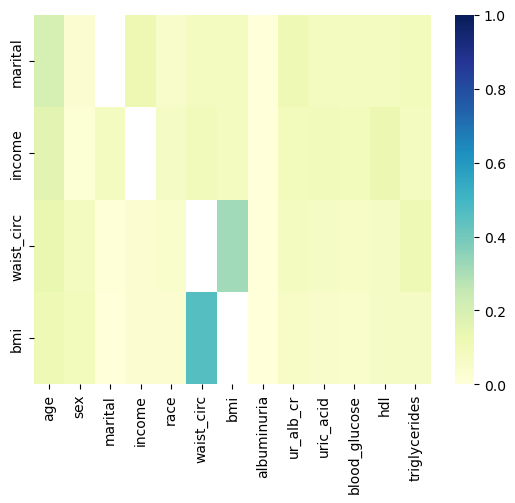

In [80]:
# Feature importance plot
kernel.plot_feature_importance(dataset=0, annot=False, cmap="YlGnBu", vmin=0, vmax=1);

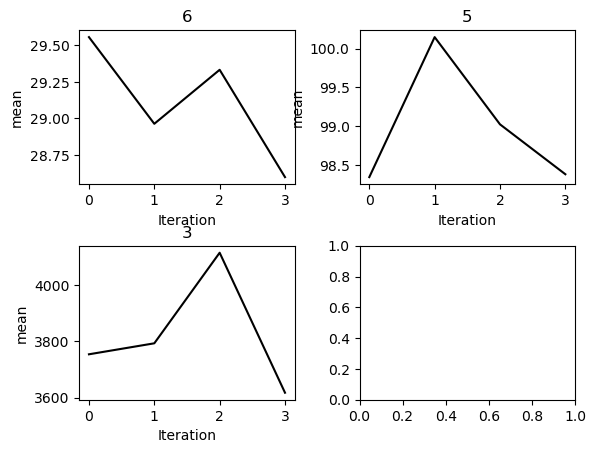

In [81]:
# Mean convergence plot
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)

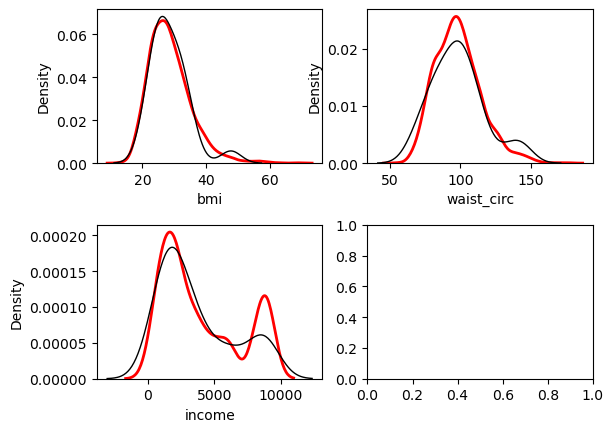

In [82]:
# Imputed distribution for numeric features with missing values
kernel.plot_imputed_distributions(wspace=0.2,hspace=0.4)

# Continuous Saturation

## Discretization

In [83]:
# Define the pipeline for discretization
binning_pipeline = ColumnTransformer(
    transformers=[
        ('binning', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'), continuous_features)
    ],
    remainder='drop', verbose_feature_names_out=False
).set_output(transform="pandas")

# Apply discretization to the datasets
X_train_binned = binning_pipeline.fit_transform(X_train_imputed)
X_test_binned = binning_pipeline.transform(X_test_imputed)

In [84]:
# Rename the binned features with _bin suffix
X_train_binned.columns = [f"{col}_bin" for col in X_train_binned.columns]
X_test_binned.columns = [f"{col}_bin" for col in X_test_binned.columns]

# Concatenate the original features with the binned features
X_train_binned = pd.concat([X_train_imputed, X_train_binned], axis=1)
X_test_binned = pd.concat([X_test_imputed, X_test_binned], axis=1)

In [85]:
# View the binned X_train
X_train_binned.head()

age     sex    marital  income              race  waist_circ   bmi  \
892   24.0    Male     Single  2500.0  HispanicOrLatino       110.7  34.9   
409   21.0  Female    Married  3500.0  HispanicOrLatino        82.7  22.0   
1781  44.0    Male     Single  1000.0             Black       105.0  28.0   
1521  63.0    Male    Married  1000.0             Asian        89.5  22.3   
1050  50.0  Female  Separated  6200.0  HispanicOrLatino       105.0  34.9   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  \
892            0       2.77        6.7          109.0  30.0          274.0   
409            0       5.56        4.3           89.0  48.0           65.0   
1781           0       2.27        5.9           93.0  43.0           44.0   
1521           0      11.47        6.9          169.0  48.0          199.0   
1050           0       8.08        4.8           97.0  57.0          115.0   

      age_bin  income_bin  waist_circ_bin  bmi_bin  ur_alb_cr_bin  \
892       0.0         2.0             3.0      4.0            0.0   
409       0.0         3.0             0.0      0.0            1.0   
1781      2.0         0.0             3.0      2.0            0.0   
1521      3.0         0.0             1.0      0.0            3.0   
1050      2.0         3.0             3.0      4.0            2.0   

      uric_acid_bin  blood_glucose_bin  hdl_bin  triglycerides_bin  
892             4.0                3.0      0.0                4.0  
409             1.0                0.0      2.0                0.0  
1781            3.0                1.0      1.0                0.0  
1521            4.0                4.0      2.0                4.0  
1050            1.0                2.0      3.0                2.0

In [86]:
# View the binned X_test
X_test_binned.head()

age     sex    marital  income              race  waist_circ   bmi  \
340   54.0  Female    Married  8200.0             White        95.2  27.1   
398   22.0  Female     Single  4500.0             White        73.0  18.3   
1707  58.0    Male  Separated  2500.0  HispanicOrLatino        99.9  27.0   
1038  35.0    Male    Married  2000.0             White       102.0  28.3   
899   26.0  Female    Married  1600.0  HispanicOrLatino       123.2  38.5   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  \
340            0       8.75        3.1           89.0  62.0          168.0   
398            0       5.32        4.1          106.0  51.0           79.0   
1707           0       3.16        4.7           98.0  50.0           73.0   
1038           0       8.35        6.9           88.0  53.0          205.0   
899            0      11.21        6.1          107.0  64.0           85.0   

      age_bin  income_bin  waist_circ_bin  bmi_bin  ur_alb_cr_bin  \
340       3.0         4.0             2.0      2.0            2.0   
398       0.0         3.0             0.0      0.0            1.0   
1707      3.0         2.0             2.0      2.0            0.0   
1038      1.0         2.0             3.0      2.0            2.0   
899       0.0         1.0             4.0      4.0            3.0   

      uric_acid_bin  blood_glucose_bin  hdl_bin  triglycerides_bin  
340             0.0                0.0      3.0                4.0  
398             0.0                3.0      2.0                1.0  
1707            1.0                2.0      2.0                1.0  
1038            4.0                0.0      2.0                4.0  
899             3.0                3.0      3.0                1.0

In [87]:
# Redefine the ordinal features list
ordinal_features = ordinal_features + [col for col in X_train_binned.columns if col.endswith("_bin")]
print(ordinal_features)

['albuminuria', 'age_bin', 'income_bin', 'waist_circ_bin', 'bmi_bin', 'ur_alb_cr_bin', 'uric_acid_bin', 'blood_glucose_bin', 'hdl_bin', 'triglycerides_bin']


## Adding Interactions

In [88]:
# Check for any zero values in the continuous features
zeros_train = (X_train_binned[continuous_features] == 0).sum()
zeros_test = (X_test_binned[continuous_features] == 0).sum()

# Check for any negative values in the continuous features
negatives_train = (X_train_binned[continuous_features] < 0).sum()
negatives_test = (X_test_binned[continuous_features] < 0).sum()

# Print the results
print("Number of zeros in the training set:\n", zeros_train)
print("Number of zeros in the test set:\n", zeros_test)
print("Number of negative values in the training set:\n", negatives_train)
print("Number of negative values in the test set:\n", negatives_test)

Number of zeros in the training set:
 age              0
income           0
waist_circ       0
bmi              0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64
Number of zeros in the test set:
 age              0
income           0
waist_circ       0
bmi              0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64
Number of negative values in the training set:
 age              0
income           0
waist_circ       0
bmi              0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64
Number of negative values in the test set:
 age              0
income           0
waist_circ       0
bmi              0
ur_alb_cr        0
uric_acid        0
blood_glucose    0
hdl              0
triglycerides    0
dtype: int64


In [89]:
# Adding a small constant to avoid log(0) and division by zero
small_constant = 1e-6
upper_bound = np.log(np.finfo(float).max)

# Define the formula for the continuous interactions
continuous_interactions_formula = ' + '.join([
    f'I({feature} ** 2)' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I({feature} ** 3)' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I(np.exp(np.clip({feature}, None, {upper_bound})))' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I(np.log({feature} + {small_constant}))' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I(np.sqrt({feature} + {small_constant}))' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I(1 / ({feature} + {small_constant}))' for feature in continuous_features
]) + ' + ' + ' + '.join([
    f'I({feature1} * {feature2})' for i, feature1 in enumerate(continuous_features) 
    for feature2 in continuous_features[i + 1:]
]) + ' + ' + ' + '.join([
    f'I(({feature1} + {small_constant}) / ({feature2} + {small_constant}))' 
    for i, feature1 in enumerate(continuous_features) 
    for feature2 in continuous_features[i + 1:]
]) + ' - 1'

In [90]:
# Generate the interaction terms for the training dataset
X_train_continuous_interactions = patsy.dmatrix(continuous_interactions_formula, X_train_binned, return_type='dataframe')

# Generate the interaction terms for the test dataset
X_test_continuous_interactions = patsy.dmatrix(continuous_interactions_formula, X_test_binned, return_type='dataframe')

# Combine the interaction terms with the datasets from the previous step
X_train_with_interactions = pd.concat([X_train_binned, X_train_continuous_interactions], axis=1)
X_test_with_interactions = pd.concat([X_test_binned, X_test_continuous_interactions], axis=1)

In [91]:
# View post-interaction X_train
X_train_with_interactions.head()

age     sex    marital  income              race  waist_circ   bmi  \
892   24.0    Male     Single  2500.0  HispanicOrLatino       110.7  34.9   
409   21.0  Female    Married  3500.0  HispanicOrLatino        82.7  22.0   
1781  44.0    Male     Single  1000.0             Black       105.0  28.0   
1521  63.0    Male    Married  1000.0             Asian        89.5  22.3   
1050  50.0  Female  Separated  6200.0  HispanicOrLatino       105.0  34.9   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  \
892            0       2.77        6.7          109.0  30.0          274.0   
409            0       5.56        4.3           89.0  48.0           65.0   
1781           0       2.27        5.9           93.0  43.0           44.0   
1521           0      11.47        6.9          169.0  48.0          199.0   
1050           0       8.08        4.8           97.0  57.0          115.0   

      age_bin  income_bin  waist_circ_bin  bmi_bin  ur_alb_cr_bin  \
892       0.0         2.0             3.0      4.0            0.0   
409       0.0         3.0             0.0      0.0            1.0   
1781      2.0         0.0             3.0      2.0            0.0   
1521      3.0         0.0             1.0      0.0            3.0   
1050      2.0         3.0             3.0      4.0            2.0   

      uric_acid_bin  blood_glucose_bin  hdl_bin  triglycerides_bin  \
892             4.0                3.0      0.0                4.0   
409             1.0                0.0      2.0                0.0   
1781            3.0                1.0      1.0                0.0   
1521            4.0                4.0      2.0                4.0   
1050            1.0                2.0      3.0                2.0   

      I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  \
892         576.0       6250000.0            12254.49      1218.01   
409         441.0      12250000.0             6839.29       484.00   
1781       1936.0       1000000.0            11025.00       784.00   
1521       3969.0       1000000.0             8010.25       497.29   
1050       2500.0      38440000.0            11025.00      1218.01   

      I(ur_alb_cr ** 2)  I(uric_acid ** 2)  I(blood_glucose ** 2)  \
892              7.6729              44.89                11881.0   
409             30.9136              18.49                 7921.0   
1781             5.1529              34.81                 8649.0   
1521           131.5609              47.61                28561.0   
1050            65.2864              23.04                 9409.0   

      I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  \
892         900.0                75076.0      13824.0    1.562500e+10   
409        2304.0                 4225.0       9261.0    4.287500e+10   
1781       1849.0                 1936.0      85184.0    1.000000e+09   
1521       2304.0                39601.0     250047.0    1.000000e+09   
1050       3249.0                13225.0     125000.0    2.383280e+11   

      I(waist_circ ** 3)  I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
892          1356572.043    42508.549          21.253933            300.763   
409           565609.283    10648.000         171.879616             79.507   
1781         1157625.000    21952.000          11.697083            205.379   
1521          716917.375    11089.567        1509.003523            328.509   
1050         1157625.000    42508.549         527.514112            110.592   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
892               1295029.0      27000.0             20570824.0   
409                704969.0     110592.0               274625.0   
1781               804357.0      79507.0                85184.0   
1521              4826809.0     110592.0              7880599.0   
1050               912673.0     185193.0              1520875.0   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
892                          

In [92]:
# Check for missing values in X_train
X_train_with_interactions.isnull().sum().sum()

0

In [93]:
# View post-interaction X_test
X_test_with_interactions.head()

age     sex    marital  income              race  waist_circ   bmi  \
340   54.0  Female    Married  8200.0             White        95.2  27.1   
398   22.0  Female     Single  4500.0             White        73.0  18.3   
1707  58.0    Male  Separated  2500.0  HispanicOrLatino        99.9  27.0   
1038  35.0    Male    Married  2000.0             White       102.0  28.3   
899   26.0  Female    Married  1600.0  HispanicOrLatino       123.2  38.5   

     albuminuria  ur_alb_cr  uric_acid  blood_glucose   hdl  triglycerides  \
340            0       8.75        3.1           89.0  62.0          168.0   
398            0       5.32        4.1          106.0  51.0           79.0   
1707           0       3.16        4.7           98.0  50.0           73.0   
1038           0       8.35        6.9           88.0  53.0          205.0   
899            0      11.21        6.1          107.0  64.0           85.0   

      age_bin  income_bin  waist_circ_bin  bmi_bin  ur_alb_cr_bin  \
340       3.0         4.0             2.0      2.0            2.0   
398       0.0         3.0             0.0      0.0            1.0   
1707      3.0         2.0             2.0      2.0            0.0   
1038      1.0         2.0             3.0      2.0            2.0   
899       0.0         1.0             4.0      4.0            3.0   

      uric_acid_bin  blood_glucose_bin  hdl_bin  triglycerides_bin  \
340             0.0                0.0      3.0                4.0   
398             0.0                3.0      2.0                1.0   
1707            1.0                2.0      2.0                1.0   
1038            4.0                0.0      2.0                4.0   
899             3.0                3.0      3.0                1.0   

      I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  \
340        2916.0      67240000.0             9063.04       734.41   
398         484.0      20250000.0             5329.00       334.89   
1707       3364.0       6250000.0             9980.01       729.00   
1038       1225.0       4000000.0            10404.00       800.89   
899         676.0       2560000.0            15178.24      1482.25   

      I(ur_alb_cr ** 2)  I(uric_acid ** 2)  I(blood_glucose ** 2)  \
340             76.5625               9.61                 7921.0   
398             28.3024              16.81                11236.0   
1707             9.9856              22.09                 9604.0   
1038            69.7225              47.61                 7744.0   
899            125.6641              37.21                11449.0   

      I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  \
340        3844.0                28224.0     157464.0    5.513680e+11   
398        2601.0                 6241.0      10648.0    9.112500e+10   
1707       2500.0                 5329.0     195112.0    1.562500e+10   
1038       2809.0                42025.0      42875.0    8.000000e+09   
899        4096.0                 7225.0      17576.0    4.096000e+09   

      I(waist_circ ** 3)  I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
340           862801.408    19902.511         669.921875             29.791   
398           389017.000     6128.487         150.568768             68.921   
1707          997002.999    19683.000          31.554496            103.823   
1038         1061208.000    22665.187         582.182875            328.509   
899          1869959.168    57066.625        1408.694561            226.981   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
340                704969.0     238328.0              4741632.0   
398               1191016.0     132651.0               493039.0   
1707               941192.0     125000.0               389017.0   
1038               681472.0     148877.0              8615125.0   
899               1225043.0     262144.0               614125.0   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
340                          

In [94]:
# Check for missing values in X_test
X_test_with_interactions.isnull().sum().sum()

0

In [95]:
# Redefine continuous features list
new_interaction_features = X_train_continuous_interactions.columns

continuous_features = continuous_features + list(new_interaction_features)
continuous_features

['age',
 'income',
 'waist_circ',
 'bmi',
 'ur_alb_cr',
 'uric_acid',
 'blood_glucose',
 'hdl',
 'triglycerides',
 'I(age ** 2)',
 'I(income ** 2)',
 'I(waist_circ ** 2)',
 'I(bmi ** 2)',
 'I(ur_alb_cr ** 2)',
 'I(uric_acid ** 2)',
 'I(blood_glucose ** 2)',
 'I(hdl ** 2)',
 'I(triglycerides ** 2)',
 'I(age ** 3)',
 'I(income ** 3)',
 'I(waist_circ ** 3)',
 'I(bmi ** 3)',
 'I(ur_alb_cr ** 3)',
 'I(uric_acid ** 3)',
 'I(blood_glucose ** 3)',
 'I(hdl ** 3)',
 'I(triglycerides ** 3)',
 'I(np.exp(np.clip(age, None, 709.782712893384)))',
 'I(np.exp(np.clip(income, None, 709.782712893384)))',
 'I(np.exp(np.clip(waist_circ, None, 709.782712893384)))',
 'I(np.exp(np.clip(bmi, None, 709.782712893384)))',
 'I(np.exp(np.clip(ur_alb_cr, None, 709.782712893384)))',
 'I(np.exp(np.clip(uric_acid, None, 709.782712893384)))',
 'I(np.exp(np.clip(blood_glucose, None, 709.782712893384)))',
 'I(np.exp(np.clip(hdl, None, 709.782712893384)))',
 'I(np.exp(np.clip(triglycerides, None, 709.782712893384)))',
 'I(

## Scaling the Data

In [96]:
# Apply QuantileTransformer and RobustScaler to continuous features only
scaling_pipeline = ColumnTransformer(
    transformers=[
        ('continuous', Pipeline([
            ('quantile', QuantileTransformer(output_distribution="normal")),
            ('scaler', RobustScaler())
        ]), continuous_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

# Fit and transform the training data
X_train_scaled = scaling_pipeline.fit_transform(X_train_with_interactions)

# Transform the test data
X_test_scaled = scaling_pipeline.transform(X_test_with_interactions)

In [97]:
# View the scaled X_train
X_train_scaled.head()

age    income  waist_circ       bmi  ur_alb_cr  uric_acid  \
892  -1.030064  0.000000    0.617056  0.764494  -1.191372   0.605758   
409  -1.449594  0.200216   -0.669609 -0.838663  -0.261657  -0.573168   
1781 -0.132985 -0.715895    0.379597  0.033653  -1.480941   0.249896   
1521  0.499635 -0.715895   -0.358620 -0.786429   0.385550   0.708483   
1050  0.060478  0.572603    0.379597  0.764494   0.097759  -0.304457   

      blood_glucose       hdl  triglycerides  I(age ** 2)  I(income ** 2)  \
892        0.484362 -1.452028       1.185774    -1.030064        0.000000   
409       -0.704711 -0.156684      -0.725545    -1.449594        0.200216   
1781      -0.413786 -0.464560      -1.371933    -0.132985       -0.715895   
1521       1.244595 -0.156684       0.878750     0.499635       -0.715895   
1050      -0.132340  0.317446       0.165098     0.060478        0.572603   

      I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
892             0.617056     0.764494          -1.191377           0.605758   
409            -0.669609    -0.838663          -0.261657          -0.573168   
1781            0.379597     0.033653          -1.480942           0.249896   
1521           -0.358621    -0.786429           0.385550           0.708483   
1050            0.379597     0.764494           0.097760          -0.304457   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
892                0.484362    -1.452028               1.185774    -1.030064   
409               -0.704711    -0.156684              -0.725545    -1.449594   
1781              -0.413786    -0.464560              -1.371933    -0.132985   
1521               1.244573    -0.156684               0.878750     0.499635   
1050              -0.132340     0.317446               0.165098     0.060478   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_alb_cr ** 3)  \
892         0.000000            0.617056     0.764494          -1.191382   
409         0.200216           -0.669609    -0.838663          -0.261657   
1781       -0.715895            0.379597     0.033653          -1.480943   
1521       -0.715895           -0.358621    -0.786429           0.385550   
1050        0.572603            0.379597     0.764494           0.097760   

      I(uric_acid ** 3)  I(blood_glucose ** 3)  I(hdl ** 3)  \
892            0.605758               0.484362    -1.452028   
409           -0.573168              -0.704711    -0.156684   
1781           0.249896              -0.413786    -0.464560   
1521           0.708483               1.244552    -0.156684   
1050          -0.304457              -0.132340     0.317446   

      I(triglycerides ** 3)  I(np.exp(np.clip(age, None, 709.782712893384)))  \
892                1.185774                                        -1.030064   
409               -0.725545                                        -1.449594   
1781              -1.371933                                        -0.132985   
1521               0.878750                                         0.499635   
1050               0.165098                                         0.060478   

      I(np.exp(np.clip(income, None, 709.782712893384)))  \
892                                                  0.0   
409                                                  0.0   
1781                                                 0.0   
1521                                                 0.0   
1050                                                 0.0   

      I(np.exp(np.clip(waist_circ, None, 709.782712893384)))  \
892                                                 0.617056   
409                                                -0.669609   
1781                                                0.379597   
1521                                               -0.358669   
1050                                                0.379597   

      I(np.exp(np.clip(bmi, None, 709.782712893384)))  \
892                                    

In [98]:
# View the scaled X_test
X_test_scaled.head()

age    income  waist_circ       bmi  ur_alb_cr  uric_acid  \
340   0.184972  0.742408   -0.090664 -0.076734   0.170672  -1.373865   
398  -1.246838  0.356628   -1.312056 -1.532989  -0.311821  -0.690661   
1707  0.310468  0.000000    0.140525 -0.090831  -0.993946  -0.353581   
1038 -0.462967 -0.193010    0.251369  0.077714   0.124127   0.708483   
899  -0.890997 -0.427397    1.058546  1.052427   0.364480   0.333727   

      blood_glucose       hdl  triglycerides  I(age ** 2)  I(income ** 2)  \
340       -0.704711  0.535440       0.661977     0.184972        0.742408   
398        0.357838  0.000000      -0.403801    -1.246838        0.356628   
1707      -0.065336 -0.053944      -0.536079     0.310468        0.000000   
1038      -0.781116  0.126509       0.901529    -0.462967       -0.193010   
899        0.396992  0.624132      -0.300290    -0.890997       -0.427397   

      I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
340            -0.090664    -0.076734           0.170672          -1.373865   
398            -1.312057    -1.532989          -0.311821          -0.690661   
1707            0.140525    -0.090831          -0.993950          -0.353581   
1038            0.251369     0.077714           0.124127           0.708483   
899             1.058546     1.052427           0.364480           0.333727   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
340               -0.704711     0.535440               0.661977     0.184972   
398                0.357838     0.000000              -0.403801    -1.246838   
1707              -0.065336    -0.053944              -0.536079     0.310468   
1038              -0.781116     0.126509               0.901529    -0.462967   
899                0.396992     0.624132              -0.300290    -0.890997   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_alb_cr ** 3)  \
340         0.742408           -0.090664    -0.076734           0.170673   
398         0.356628           -1.312057    -1.532989          -0.311821   
1707        0.000000            0.140525    -0.090831          -0.993955   
1038       -0.193010            0.251369     0.077714           0.124128   
899        -0.427397            1.058545     1.052427           0.364479   

      I(uric_acid ** 3)  I(blood_glucose ** 3)  I(hdl ** 3)  \
340           -1.373865              -0.704711     0.535440   
398           -0.690661               0.357838     0.000000   
1707          -0.353581              -0.065336    -0.053944   
1038           0.708483              -0.781116     0.126509   
899            0.333727               0.396992     0.624132   

      I(triglycerides ** 3)  I(np.exp(np.clip(age, None, 709.782712893384)))  \
340                0.661977                                         0.184972   
398               -0.403801                                        -1.246838   
1707              -0.536079                                         0.310468   
1038               0.901529                                        -0.462967   
899               -0.300290                                        -0.890997   

      I(np.exp(np.clip(income, None, 709.782712893384)))  \
340                                                  0.0   
398                                                  0.0   
1707                                                 0.0   
1038                                                 0.0   
899                                                  0.0   

      I(np.exp(np.clip(waist_circ, None, 709.782712893384)))  \
340                                                -0.090664   
398                                                -1.312061   
1707                                                0.140525   
1038                                                0.251369   
899                                                 1.058485   

      I(np.exp(np.clip(bmi, None, 709.782712893384)))  \
340                                    

# Categorical Saturation

## Ordinal Encoding

In [99]:
# Define the pipeline for ordinal encoding
ordinal_pipeline = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ordinal_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

# Apply ordinal encoding to the datasets
X_train_ordinal = ordinal_pipeline.fit_transform(X_train_scaled)
X_test_ordinal = ordinal_pipeline.transform(X_test_scaled)

In [100]:
# View ordinal-encoded X_train
X_train_ordinal.head()

albuminuria  age_bin  income_bin  waist_circ_bin  bmi_bin  \
892           0.0      0.0         2.0             3.0      4.0   
409           0.0      0.0         3.0             0.0      0.0   
1781          0.0      2.0         0.0             3.0      2.0   
1521          0.0      3.0         0.0             1.0      0.0   
1050          0.0      2.0         3.0             3.0      4.0   

      ur_alb_cr_bin  uric_acid_bin  blood_glucose_bin  hdl_bin  \
892             0.0            4.0                3.0      0.0   
409             1.0            1.0                0.0      2.0   
1781            0.0            3.0                1.0      1.0   
1521            3.0            4.0                4.0      2.0   
1050            2.0            1.0                2.0      3.0   

      triglycerides_bin       age    income  waist_circ       bmi  ur_alb_cr  \
892                 4.0 -1.030064  0.000000    0.617056  0.764494  -1.191372   
409                 0.0 -1.449594  0.200216   -0.669609 -0.838663  -0.261657   
1781                0.0 -0.132985 -0.715895    0.379597  0.033653  -1.480941   
1521                4.0  0.499635 -0.715895   -0.358620 -0.786429   0.385550   
1050                2.0  0.060478  0.572603    0.379597  0.764494   0.097759   

      uric_acid  blood_glucose       hdl  triglycerides  I(age ** 2)  \
892    0.605758       0.484362 -1.452028       1.185774    -1.030064   
409   -0.573168      -0.704711 -0.156684      -0.725545    -1.449594   
1781   0.249896      -0.413786 -0.464560      -1.371933    -0.132985   
1521   0.708483       1.244595 -0.156684       0.878750     0.499635   
1050  -0.304457      -0.132340  0.317446       0.165098     0.060478   

      I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  \
892         0.000000            0.617056     0.764494          -1.191377   
409         0.200216           -0.669609    -0.838663          -0.261657   
1781       -0.715895            0.379597     0.033653          -1.480942   
1521       -0.715895           -0.358621    -0.786429           0.385550   
1050        0.572603            0.379597     0.764494           0.097760   

      I(uric_acid ** 2)  I(blood_glucose ** 2)  I(hdl ** 2)  \
892            0.605758               0.484362    -1.452028   
409           -0.573168              -0.704711    -0.156684   
1781           0.249896              -0.413786    -0.464560   
1521           0.708483               1.244573    -0.156684   
1050          -0.304457              -0.132340     0.317446   

      I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  I(waist_circ ** 3)  \
892                1.185774    -1.030064        0.000000            0.617056   
409               -0.725545    -1.449594        0.200216           -0.669609   
1781              -1.371933    -0.132985       -0.715895            0.379597   
1521               0.878750     0.499635       -0.715895           -0.358621   
1050               0.165098     0.060478        0.572603            0.379597   

      I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
892      0.764494          -1.191382           0.605758   
409     -0.838663          -0.261657          -0.573168   
1781     0.033653          -1.480943           0.249896   
1521    -0.786429           0.385550           0.708483   
1050     0.764494           0.097760          -0.304457   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
892                0.484362    -1.452028               1.185774   
409               -0.704711    -0.156684              -0.725545   
1781              -0.413786    -0.464560              -1.371933   
1521               1.244552    -0.156684               0.878750   
1050              -0.132340     0.317446               0.165098   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
892                                         -1.030064   
409                                         -1.449594   
1781                                        -0

In [101]:
# View ordinal-encoded X_test
X_test_ordinal.head()

albuminuria  age_bin  income_bin  waist_circ_bin  bmi_bin  \
340           0.0      3.0         4.0             2.0      2.0   
398           0.0      0.0         3.0             0.0      0.0   
1707          0.0      3.0         2.0             2.0      2.0   
1038          0.0      1.0         2.0             3.0      2.0   
899           0.0      0.0         1.0             4.0      4.0   

      ur_alb_cr_bin  uric_acid_bin  blood_glucose_bin  hdl_bin  \
340             2.0            0.0                0.0      3.0   
398             1.0            0.0                3.0      2.0   
1707            0.0            1.0                2.0      2.0   
1038            2.0            4.0                0.0      2.0   
899             3.0            3.0                3.0      3.0   

      triglycerides_bin       age    income  waist_circ       bmi  ur_alb_cr  \
340                 4.0  0.184972  0.742408   -0.090664 -0.076734   0.170672   
398                 1.0 -1.246838  0.356628   -1.312056 -1.532989  -0.311821   
1707                1.0  0.310468  0.000000    0.140525 -0.090831  -0.993946   
1038                4.0 -0.462967 -0.193010    0.251369  0.077714   0.124127   
899                 1.0 -0.890997 -0.427397    1.058546  1.052427   0.364480   

      uric_acid  blood_glucose       hdl  triglycerides  I(age ** 2)  \
340   -1.373865      -0.704711  0.535440       0.661977     0.184972   
398   -0.690661       0.357838  0.000000      -0.403801    -1.246838   
1707  -0.353581      -0.065336 -0.053944      -0.536079     0.310468   
1038   0.708483      -0.781116  0.126509       0.901529    -0.462967   
899    0.333727       0.396992  0.624132      -0.300290    -0.890997   

      I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  \
340         0.742408           -0.090664    -0.076734           0.170672   
398         0.356628           -1.312057    -1.532989          -0.311821   
1707        0.000000            0.140525    -0.090831          -0.993950   
1038       -0.193010            0.251369     0.077714           0.124127   
899        -0.427397            1.058546     1.052427           0.364480   

      I(uric_acid ** 2)  I(blood_glucose ** 2)  I(hdl ** 2)  \
340           -1.373865              -0.704711     0.535440   
398           -0.690661               0.357838     0.000000   
1707          -0.353581              -0.065336    -0.053944   
1038           0.708483              -0.781116     0.126509   
899            0.333727               0.396992     0.624132   

      I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  I(waist_circ ** 3)  \
340                0.661977     0.184972        0.742408           -0.090664   
398               -0.403801    -1.246838        0.356628           -1.312057   
1707              -0.536079     0.310468        0.000000            0.140525   
1038               0.901529    -0.462967       -0.193010            0.251369   
899               -0.300290    -0.890997       -0.427397            1.058545   

      I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
340     -0.076734           0.170673          -1.373865   
398     -1.532989          -0.311821          -0.690661   
1707    -0.090831          -0.993955          -0.353581   
1038     0.077714           0.124128           0.708483   
899      1.052427           0.364479           0.333727   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
340               -0.704711     0.535440               0.661977   
398                0.357838     0.000000              -0.403801   
1707              -0.065336    -0.053944              -0.536079   
1038              -0.781116     0.126509               0.901529   
899                0.396992     0.624132              -0.300290   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
340                                          0.184972   
398                                         -1.246838   
1707                                         0

## Binary Encoding

In [102]:
# Define the pipeline for binary encoding
binary_pipeline = ColumnTransformer(
    transformers=[
        ('binary', BinaryEncoder(), binary_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

# Apply binary encoding to the datasets
X_train_binary = binary_pipeline.fit_transform(X_train_ordinal)
X_test_binary = binary_pipeline.transform(X_test_ordinal)

In [103]:
# View binary-encoded X_train
X_train_binary.head()

sex_0  sex_1  albuminuria  age_bin  income_bin  waist_circ_bin  bmi_bin  \
892       0      1          0.0      0.0         2.0             3.0      4.0   
409       1      0          0.0      0.0         3.0             0.0      0.0   
1781      0      1          0.0      2.0         0.0             3.0      2.0   
1521      0      1          0.0      3.0         0.0             1.0      0.0   
1050      1      0          0.0      2.0         3.0             3.0      4.0   

      ur_alb_cr_bin  uric_acid_bin  blood_glucose_bin  hdl_bin  \
892             0.0            4.0                3.0      0.0   
409             1.0            1.0                0.0      2.0   
1781            0.0            3.0                1.0      1.0   
1521            3.0            4.0                4.0      2.0   
1050            2.0            1.0                2.0      3.0   

      triglycerides_bin       age    income  waist_circ       bmi  ur_alb_cr  \
892                 4.0 -1.030064  0.000000    0.617056  0.764494  -1.191372   
409                 0.0 -1.449594  0.200216   -0.669609 -0.838663  -0.261657   
1781                0.0 -0.132985 -0.715895    0.379597  0.033653  -1.480941   
1521                4.0  0.499635 -0.715895   -0.358620 -0.786429   0.385550   
1050                2.0  0.060478  0.572603    0.379597  0.764494   0.097759   

      uric_acid  blood_glucose       hdl  triglycerides  I(age ** 2)  \
892    0.605758       0.484362 -1.452028       1.185774    -1.030064   
409   -0.573168      -0.704711 -0.156684      -0.725545    -1.449594   
1781   0.249896      -0.413786 -0.464560      -1.371933    -0.132985   
1521   0.708483       1.244595 -0.156684       0.878750     0.499635   
1050  -0.304457      -0.132340  0.317446       0.165098     0.060478   

      I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  \
892         0.000000            0.617056     0.764494          -1.191377   
409         0.200216           -0.669609    -0.838663          -0.261657   
1781       -0.715895            0.379597     0.033653          -1.480942   
1521       -0.715895           -0.358621    -0.786429           0.385550   
1050        0.572603            0.379597     0.764494           0.097760   

      I(uric_acid ** 2)  I(blood_glucose ** 2)  I(hdl ** 2)  \
892            0.605758               0.484362    -1.452028   
409           -0.573168              -0.704711    -0.156684   
1781           0.249896              -0.413786    -0.464560   
1521           0.708483               1.244573    -0.156684   
1050          -0.304457              -0.132340     0.317446   

      I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  I(waist_circ ** 3)  \
892                1.185774    -1.030064        0.000000            0.617056   
409               -0.725545    -1.449594        0.200216           -0.669609   
1781              -1.371933    -0.132985       -0.715895            0.379597   
1521               0.878750     0.499635       -0.715895           -0.358621   
1050               0.165098     0.060478        0.572603            0.379597   

      I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
892      0.764494          -1.191382           0.605758   
409     -0.838663          -0.261657          -0.573168   
1781     0.033653          -1.480943           0.249896   
1521    -0.786429           0.385550           0.708483   
1050     0.764494           0.097760          -0.304457   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
892                0.484362    -1.452028               1.185774   
409               -0.704711    -0.156684              -0.725545   
1781              -0.413786    -0.464560              -1.371933   
1521               1.244552    -0.156684               0.878750   
1050              -0.132340     0.317446               0.165098   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
892                                         -1.030064   
409                

In [104]:
# View binary-encoded X_test
X_test_binary.head()

sex_0  sex_1  albuminuria  age_bin  income_bin  waist_circ_bin  bmi_bin  \
340       1      0          0.0      3.0         4.0             2.0      2.0   
398       1      0          0.0      0.0         3.0             0.0      0.0   
1707      0      1          0.0      3.0         2.0             2.0      2.0   
1038      0      1          0.0      1.0         2.0             3.0      2.0   
899       1      0          0.0      0.0         1.0             4.0      4.0   

      ur_alb_cr_bin  uric_acid_bin  blood_glucose_bin  hdl_bin  \
340             2.0            0.0                0.0      3.0   
398             1.0            0.0                3.0      2.0   
1707            0.0            1.0                2.0      2.0   
1038            2.0            4.0                0.0      2.0   
899             3.0            3.0                3.0      3.0   

      triglycerides_bin       age    income  waist_circ       bmi  ur_alb_cr  \
340                 4.0  0.184972  0.742408   -0.090664 -0.076734   0.170672   
398                 1.0 -1.246838  0.356628   -1.312056 -1.532989  -0.311821   
1707                1.0  0.310468  0.000000    0.140525 -0.090831  -0.993946   
1038                4.0 -0.462967 -0.193010    0.251369  0.077714   0.124127   
899                 1.0 -0.890997 -0.427397    1.058546  1.052427   0.364480   

      uric_acid  blood_glucose       hdl  triglycerides  I(age ** 2)  \
340   -1.373865      -0.704711  0.535440       0.661977     0.184972   
398   -0.690661       0.357838  0.000000      -0.403801    -1.246838   
1707  -0.353581      -0.065336 -0.053944      -0.536079     0.310468   
1038   0.708483      -0.781116  0.126509       0.901529    -0.462967   
899    0.333727       0.396992  0.624132      -0.300290    -0.890997   

      I(income ** 2)  I(waist_circ ** 2)  I(bmi ** 2)  I(ur_alb_cr ** 2)  \
340         0.742408           -0.090664    -0.076734           0.170672   
398         0.356628           -1.312057    -1.532989          -0.311821   
1707        0.000000            0.140525    -0.090831          -0.993950   
1038       -0.193010            0.251369     0.077714           0.124127   
899        -0.427397            1.058546     1.052427           0.364480   

      I(uric_acid ** 2)  I(blood_glucose ** 2)  I(hdl ** 2)  \
340           -1.373865              -0.704711     0.535440   
398           -0.690661               0.357838     0.000000   
1707          -0.353581              -0.065336    -0.053944   
1038           0.708483              -0.781116     0.126509   
899            0.333727               0.396992     0.624132   

      I(triglycerides ** 2)  I(age ** 3)  I(income ** 3)  I(waist_circ ** 3)  \
340                0.661977     0.184972        0.742408           -0.090664   
398               -0.403801    -1.246838        0.356628           -1.312057   
1707              -0.536079     0.310468        0.000000            0.140525   
1038               0.901529    -0.462967       -0.193010            0.251369   
899               -0.300290    -0.890997       -0.427397            1.058545   

      I(bmi ** 3)  I(ur_alb_cr ** 3)  I(uric_acid ** 3)  \
340     -0.076734           0.170673          -1.373865   
398     -1.532989          -0.311821          -0.690661   
1707    -0.090831          -0.993955          -0.353581   
1038     0.077714           0.124128           0.708483   
899      1.052427           0.364479           0.333727   

      I(blood_glucose ** 3)  I(hdl ** 3)  I(triglycerides ** 3)  \
340               -0.704711     0.535440               0.661977   
398                0.357838     0.000000              -0.403801   
1707              -0.065336    -0.053944              -0.536079   
1038              -0.781116     0.126509               0.901529   
899                0.396992     0.624132              -0.300290   

      I(np.exp(np.clip(age, None, 709.782712893384)))  \
340                                          0.184972   
398                

## One-Hot Encoding

In [105]:
# Define the pipeline for one-hot encoding
nominal_pipeline = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(drop=None, sparse_output=False), nominal_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
).set_output(transform="pandas")

# Apply one-hot encoding to the datasets
X_train_onehot = nominal_pipeline.fit_transform(X_train_binary)
X_test_onehot = nominal_pipeline.transform(X_test_binary)

In [106]:
# View OHE X_train
X_train_onehot.head()

marital_Divorced  marital_Married  marital_Separated  marital_Single  \
892                0.0              0.0                0.0             1.0   
409                0.0              1.0                0.0             0.0   
1781               0.0              0.0                0.0             1.0   
1521               0.0              1.0                0.0             0.0   
1050               0.0              0.0                1.0             0.0   

      marital_Widowed  race_Asian  race_Black  race_HispanicOrLatino  \
892               0.0         0.0         0.0                    1.0   
409               0.0         0.0         0.0                    1.0   
1781              0.0         0.0         1.0                    0.0   
1521              0.0         1.0         0.0                    0.0   
1050              0.0         0.0         0.0                    1.0   

      race_Other  race_White  sex_0  sex_1  albuminuria  age_bin  income_bin  \
892          0.0         0.0      0      1          0.0      0.0         2.0   
409          0.0         0.0      1      0          0.0      0.0         3.0   
1781         0.0         0.0      0      1          0.0      2.0         0.0   
1521         0.0         0.0      0      1          0.0      3.0         0.0   
1050         0.0         0.0      1      0          0.0      2.0         3.0   

      waist_circ_bin  bmi_bin  ur_alb_cr_bin  uric_acid_bin  \
892              3.0      4.0            0.0            4.0   
409              0.0      0.0            1.0            1.0   
1781             3.0      2.0            0.0            3.0   
1521             1.0      0.0            3.0            4.0   
1050             3.0      4.0            2.0            1.0   

      blood_glucose_bin  hdl_bin  triglycerides_bin       age    income  \
892                 3.0      0.0                4.0 -1.030064  0.000000   
409                 0.0      2.0                0.0 -1.449594  0.200216   
1781                1.0      1.0                0.0 -0.132985 -0.715895   
1521                4.0      2.0                4.0  0.499635 -0.715895   
1050                2.0      3.0                2.0  0.060478  0.572603   

      waist_circ       bmi  ur_alb_cr  uric_acid  blood_glucose       hdl  \
892     0.617056  0.764494  -1.191372   0.605758       0.484362 -1.452028   
409    -0.669609 -0.838663  -0.261657  -0.573168      -0.704711 -0.156684   
1781    0.379597  0.033653  -1.480941   0.249896      -0.413786 -0.464560   
1521   -0.358620 -0.786429   0.385550   0.708483       1.244595 -0.156684   
1050    0.379597  0.764494   0.097759  -0.304457      -0.132340  0.317446   

      triglycerides  I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  \
892        1.185774    -1.030064        0.000000            0.617056   
409       -0.725545    -1.449594        0.200216           -0.669609   
1781      -1.371933    -0.132985       -0.715895            0.379597   
1521       0.878750     0.499635       -0.715895           -0.358621   
1050       0.165098     0.060478        0.572603            0.379597   

      I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
892      0.764494          -1.191377           0.605758   
409     -0.838663          -0.261657          -0.573168   
1781     0.033653          -1.480942           0.249896   
1521    -0.786429           0.385550           0.708483   
1050     0.764494           0.097760          -0.304457   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
892                0.484362    -1.452028               1.185774    -1.030064   
409               -0.704711    -0.156684              -0.725545    -1.449594   
1781              -0.413786    -0.464560              -1.371933    -0.132985   
1521               1.244573    -0.156684               0.878750     0.499635   
1050              -0.132340     0.317446               0.165098     0.060478   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_a

In [107]:
# View one-hot-encoded X_test
X_test_onehot.head()

marital_Divorced  marital_Married  marital_Separated  marital_Single  \
340                0.0              1.0                0.0             0.0   
398                0.0              0.0                0.0             1.0   
1707               0.0              0.0                1.0             0.0   
1038               0.0              1.0                0.0             0.0   
899                0.0              1.0                0.0             0.0   

      marital_Widowed  race_Asian  race_Black  race_HispanicOrLatino  \
340               0.0         0.0         0.0                    0.0   
398               0.0         0.0         0.0                    0.0   
1707              0.0         0.0         0.0                    1.0   
1038              0.0         0.0         0.0                    0.0   
899               0.0         0.0         0.0                    1.0   

      race_Other  race_White  sex_0  sex_1  albuminuria  age_bin  income_bin  \
340          0.0         1.0      1      0          0.0      3.0         4.0   
398          0.0         1.0      1      0          0.0      0.0         3.0   
1707         0.0         0.0      0      1          0.0      3.0         2.0   
1038         0.0         1.0      0      1          0.0      1.0         2.0   
899          0.0         0.0      1      0          0.0      0.0         1.0   

      waist_circ_bin  bmi_bin  ur_alb_cr_bin  uric_acid_bin  \
340              2.0      2.0            2.0            0.0   
398              0.0      0.0            1.0            0.0   
1707             2.0      2.0            0.0            1.0   
1038             3.0      2.0            2.0            4.0   
899              4.0      4.0            3.0            3.0   

      blood_glucose_bin  hdl_bin  triglycerides_bin       age    income  \
340                 0.0      3.0                4.0  0.184972  0.742408   
398                 3.0      2.0                1.0 -1.246838  0.356628   
1707                2.0      2.0                1.0  0.310468  0.000000   
1038                0.0      2.0                4.0 -0.462967 -0.193010   
899                 3.0      3.0                1.0 -0.890997 -0.427397   

      waist_circ       bmi  ur_alb_cr  uric_acid  blood_glucose       hdl  \
340    -0.090664 -0.076734   0.170672  -1.373865      -0.704711  0.535440   
398    -1.312056 -1.532989  -0.311821  -0.690661       0.357838  0.000000   
1707    0.140525 -0.090831  -0.993946  -0.353581      -0.065336 -0.053944   
1038    0.251369  0.077714   0.124127   0.708483      -0.781116  0.126509   
899     1.058546  1.052427   0.364480   0.333727       0.396992  0.624132   

      triglycerides  I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  \
340        0.661977     0.184972        0.742408           -0.090664   
398       -0.403801    -1.246838        0.356628           -1.312057   
1707      -0.536079     0.310468        0.000000            0.140525   
1038       0.901529    -0.462967       -0.193010            0.251369   
899       -0.300290    -0.890997       -0.427397            1.058546   

      I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
340     -0.076734           0.170672          -1.373865   
398     -1.532989          -0.311821          -0.690661   
1707    -0.090831          -0.993950          -0.353581   
1038     0.077714           0.124127           0.708483   
899      1.052427           0.364480           0.333727   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
340               -0.704711     0.535440               0.661977     0.184972   
398                0.357838     0.000000              -0.403801    -1.246838   
1707              -0.065336    -0.053944              -0.536079     0.310468   
1038              -0.781116     0.126509               0.901529    -0.462967   
899                0.396992     0.624132              -0.300290    -0.890997   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_a

In [108]:
# View the columns, non-nulls, and datatypes
X_train_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 892 to 780
Columns: 157 entries, marital_Divorced to I((hdl + 1e-06) / (triglycerides + 1e-06))
dtypes: float64(155), int64(2)
memory usage: 2.3 MB


In [109]:
# Redefine the ordinal features list
ordinal_features = list(ordinal_pipeline.named_transformers_['ordinal'].get_feature_names_out(ordinal_features))

# Redefine the binary features list
binary_features = list(binary_pipeline.named_transformers_['binary'].get_feature_names_out(binary_features))

# Redefine the nominal features list
nominal_features = list(nominal_pipeline.named_transformers_['nominal'].get_feature_names_out(nominal_features))

In [110]:
# Print the new lists
print(binary_features)
print(nominal_features)

['sex_0', 'sex_1']
['marital_Divorced', 'marital_Married', 'marital_Separated', 'marital_Single', 'marital_Widowed', 'race_Asian', 'race_Black', 'race_HispanicOrLatino', 'race_Other', 'race_White']


## Adding Interactions

In [111]:
# Define formulas for each type of interaction
nominal_nominal_interactions = [
    f'{n1}:{n2}' for i, n1 in enumerate(nominal_features) 
    for n2 in nominal_features[i + 1:]
]
nominal_ordinal_interactions = [
    f'{n}:{o}' for n in nominal_features for o in ordinal_features
]
nominal_binary_interactions = [
    f'{n}:{b}' for n in nominal_features for b in binary_features
]
binary_binary_interactions = [
    f'{b1}:{b2}' for i, b1 in enumerate(binary_features) 
    for b2 in binary_features[i + 1:]
]
binary_ordinal_interactions = [
    f'{b}:{o}' for b in binary_features for o in ordinal_features
]
ordinal_ordinal_interactions = [
    f'{o1}:{o2}' for i, o1 in enumerate(ordinal_features) 
    for o2 in ordinal_features[i + 1:]
]

# Combine all interaction formulas
all_categorical_interactions_formula = ' + '.join([
    ' + '.join(nominal_nominal_interactions),
    ' + '.join(nominal_ordinal_interactions),
    ' + '.join(nominal_binary_interactions),
    ' + '.join(binary_binary_interactions),
    ' + '.join(binary_ordinal_interactions),
    ' + '.join(ordinal_ordinal_interactions)
]) + ' - 1'

In [112]:
# Generate the interaction terms for the training dataset
X_train_categorical_interactions = patsy.dmatrix(all_categorical_interactions_formula, X_train_onehot, return_type='dataframe')

# Generate the interaction terms for the test dataset
X_test_categorical_interactions = patsy.dmatrix(all_categorical_interactions_formula, X_test_onehot, return_type='dataframe')

# Combine the interaction terms with the preprocessed datasets
X_train_final = pd.concat([X_train_onehot, X_train_categorical_interactions], axis=1)
X_test_final = pd.concat([X_test_onehot, X_test_categorical_interactions], axis=1)

In [113]:
# View final X_train
X_train_final.head()

marital_Divorced  marital_Married  marital_Separated  marital_Single  \
892                0.0              0.0                0.0             1.0   
409                0.0              1.0                0.0             0.0   
1781               0.0              0.0                0.0             1.0   
1521               0.0              1.0                0.0             0.0   
1050               0.0              0.0                1.0             0.0   

      marital_Widowed  race_Asian  race_Black  race_HispanicOrLatino  \
892               0.0         0.0         0.0                    1.0   
409               0.0         0.0         0.0                    1.0   
1781              0.0         0.0         1.0                    0.0   
1521              0.0         1.0         0.0                    0.0   
1050              0.0         0.0         0.0                    1.0   

      race_Other  race_White  sex_0  sex_1  albuminuria  age_bin  income_bin  \
892          0.0         0.0      0      1          0.0      0.0         2.0   
409          0.0         0.0      1      0          0.0      0.0         3.0   
1781         0.0         0.0      0      1          0.0      2.0         0.0   
1521         0.0         0.0      0      1          0.0      3.0         0.0   
1050         0.0         0.0      1      0          0.0      2.0         3.0   

      waist_circ_bin  bmi_bin  ur_alb_cr_bin  uric_acid_bin  \
892              3.0      4.0            0.0            4.0   
409              0.0      0.0            1.0            1.0   
1781             3.0      2.0            0.0            3.0   
1521             1.0      0.0            3.0            4.0   
1050             3.0      4.0            2.0            1.0   

      blood_glucose_bin  hdl_bin  triglycerides_bin       age    income  \
892                 3.0      0.0                4.0 -1.030064  0.000000   
409                 0.0      2.0                0.0 -1.449594  0.200216   
1781                1.0      1.0                0.0 -0.132985 -0.715895   
1521                4.0      2.0                4.0  0.499635 -0.715895   
1050                2.0      3.0                2.0  0.060478  0.572603   

      waist_circ       bmi  ur_alb_cr  uric_acid  blood_glucose       hdl  \
892     0.617056  0.764494  -1.191372   0.605758       0.484362 -1.452028   
409    -0.669609 -0.838663  -0.261657  -0.573168      -0.704711 -0.156684   
1781    0.379597  0.033653  -1.480941   0.249896      -0.413786 -0.464560   
1521   -0.358620 -0.786429   0.385550   0.708483       1.244595 -0.156684   
1050    0.379597  0.764494   0.097759  -0.304457      -0.132340  0.317446   

      triglycerides  I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  \
892        1.185774    -1.030064        0.000000            0.617056   
409       -0.725545    -1.449594        0.200216           -0.669609   
1781      -1.371933    -0.132985       -0.715895            0.379597   
1521       0.878750     0.499635       -0.715895           -0.358621   
1050       0.165098     0.060478        0.572603            0.379597   

      I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
892      0.764494          -1.191377           0.605758   
409     -0.838663          -0.261657          -0.573168   
1781     0.033653          -1.480942           0.249896   
1521    -0.786429           0.385550           0.708483   
1050     0.764494           0.097760          -0.304457   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
892                0.484362    -1.452028               1.185774    -1.030064   
409               -0.704711    -0.156684              -0.725545    -1.449594   
1781              -0.413786    -0.464560              -1.371933    -0.132985   
1521               1.244573    -0.156684               0.878750     0.499635   
1050              -0.132340     0.317446               0.165098     0.060478   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_a

In [114]:
# View final X_test
X_test_final.head()

marital_Divorced  marital_Married  marital_Separated  marital_Single  \
340                0.0              1.0                0.0             0.0   
398                0.0              0.0                0.0             1.0   
1707               0.0              0.0                1.0             0.0   
1038               0.0              1.0                0.0             0.0   
899                0.0              1.0                0.0             0.0   

      marital_Widowed  race_Asian  race_Black  race_HispanicOrLatino  \
340               0.0         0.0         0.0                    0.0   
398               0.0         0.0         0.0                    0.0   
1707              0.0         0.0         0.0                    1.0   
1038              0.0         0.0         0.0                    0.0   
899               0.0         0.0         0.0                    1.0   

      race_Other  race_White  sex_0  sex_1  albuminuria  age_bin  income_bin  \
340          0.0         1.0      1      0          0.0      3.0         4.0   
398          0.0         1.0      1      0          0.0      0.0         3.0   
1707         0.0         0.0      0      1          0.0      3.0         2.0   
1038         0.0         1.0      0      1          0.0      1.0         2.0   
899          0.0         0.0      1      0          0.0      0.0         1.0   

      waist_circ_bin  bmi_bin  ur_alb_cr_bin  uric_acid_bin  \
340              2.0      2.0            2.0            0.0   
398              0.0      0.0            1.0            0.0   
1707             2.0      2.0            0.0            1.0   
1038             3.0      2.0            2.0            4.0   
899              4.0      4.0            3.0            3.0   

      blood_glucose_bin  hdl_bin  triglycerides_bin       age    income  \
340                 0.0      3.0                4.0  0.184972  0.742408   
398                 3.0      2.0                1.0 -1.246838  0.356628   
1707                2.0      2.0                1.0  0.310468  0.000000   
1038                0.0      2.0                4.0 -0.462967 -0.193010   
899                 3.0      3.0                1.0 -0.890997 -0.427397   

      waist_circ       bmi  ur_alb_cr  uric_acid  blood_glucose       hdl  \
340    -0.090664 -0.076734   0.170672  -1.373865      -0.704711  0.535440   
398    -1.312056 -1.532989  -0.311821  -0.690661       0.357838  0.000000   
1707    0.140525 -0.090831  -0.993946  -0.353581      -0.065336 -0.053944   
1038    0.251369  0.077714   0.124127   0.708483      -0.781116  0.126509   
899     1.058546  1.052427   0.364480   0.333727       0.396992  0.624132   

      triglycerides  I(age ** 2)  I(income ** 2)  I(waist_circ ** 2)  \
340        0.661977     0.184972        0.742408           -0.090664   
398       -0.403801    -1.246838        0.356628           -1.312057   
1707      -0.536079     0.310468        0.000000            0.140525   
1038       0.901529    -0.462967       -0.193010            0.251369   
899       -0.300290    -0.890997       -0.427397            1.058546   

      I(bmi ** 2)  I(ur_alb_cr ** 2)  I(uric_acid ** 2)  \
340     -0.076734           0.170672          -1.373865   
398     -1.532989          -0.311821          -0.690661   
1707    -0.090831          -0.993950          -0.353581   
1038     0.077714           0.124127           0.708483   
899      1.052427           0.364480           0.333727   

      I(blood_glucose ** 2)  I(hdl ** 2)  I(triglycerides ** 2)  I(age ** 3)  \
340               -0.704711     0.535440               0.661977     0.184972   
398                0.357838     0.000000              -0.403801    -1.246838   
1707              -0.065336    -0.053944              -0.536079     0.310468   
1038              -0.781116     0.126509               0.901529    -0.462967   
899                0.396992     0.624132              -0.300290    -0.890997   

      I(income ** 3)  I(waist_circ ** 3)  I(bmi ** 3)  I(ur_a

In [115]:
# View columns and missing values
X_train_final.isnull().sum()

marital_Divorced                                             0
marital_Married                                              0
marital_Separated                                            0
marital_Single                                               0
marital_Widowed                                              0
race_Asian                                                   0
race_Black                                                   0
race_HispanicOrLatino                                        0
race_Other                                                   0
race_White                                                   0
sex_0                                                        0
sex_1                                                        0
albuminuria                                                  0
age_bin                                                      0
income_bin                                                   0
waist_circ_bin                                         

In [116]:
# Total number of features
print(f"There are {len(X_train_final.columns)} features after the saturation process")

There are 388 features after the saturation process


# Feature Selection

In [117]:
# Define the model to be used with the selector
model = HistGradientBoostingClassifier(random_state=0)

# Instantiate the BorutaShap feature selector
feature_selector = BorutaShap(model=model, importance_measure='shap', classification=True)

# Fit the selector to saturated X_train
feature_selector.fit(X=X_train_final, y=y_train, n_trials=200, random_state=0)
X_train_selected = X_train_final[feature_selector.accepted]

# Apply the results to saturated X_test
X_test_selected = X_test_final[feature_selector.accepted]

  0%|          | 0/200 [00:00<?, ?it/s]

20 attributes confirmed important: ['I(ur_alb_cr * triglycerides)', 'I((blood_glucose + 1e-06) / (hdl + 1e-06))', 'I(age * bmi)', 'I((waist_circ + 1e-06) / (hdl + 1e-06))', 'I(bmi * triglycerides)', 'sex_0:blood_glucose_bin', 'sex_1:hdl_bin', 'I(age * triglycerides)', 'I(waist_circ * triglycerides)', 'I(bmi * blood_glucose)', 'triglycerides', 'hdl', 'waist_circ', 'blood_glucose', 'sex_0:triglycerides_bin', 'I((age + 1e-06) / (hdl + 1e-06))', 'I((blood_glucose + 1e-06) / (triglycerides + 1e-06))', 'I(age * blood_glucose)', 'I(waist_circ * blood_glucose)', 'I((hdl + 1e-06) / (triglycerides + 1e-06))']
367 attributes confirmed unimportant: ['age_bin:hdl_bin', 'marital_Separated:bmi_bin', 'marital_Divorced:ur_alb_cr_bin', 'waist_circ_bin:uric_acid_bin', 'I(age * ur_alb_cr)', 'albuminuria:bmi_bin', 'I(ur_alb_cr * blood_glucose)', 'marital_Single:income_bin', 'marital_Single:sex_1', 'I(bmi * hdl)', 'I((income + 1e-06) / (uric_acid + 1e-06))', 'ur_alb_cr_bin:blood_glucose_bin', 'race_Black:al

In [118]:
# View reduced X_train
X_train_selected.head()

I(ur_alb_cr * triglycerides)  \
892                      -0.033427   
409                      -0.679106   
1781                     -2.015802   
1521                      0.622561   
1050                      0.120958   

      I((blood_glucose + 1e-06) / (hdl + 1e-06))  I(age * bmi)  \
892                                     1.093918     -0.592759   
409                                    -0.150792     -1.441014   
1781                                    0.192273     -0.126236   
1521                                    1.040561      0.045627   
1050                                   -0.315184      0.413603   

      I((waist_circ + 1e-06) / (hdl + 1e-06))  I(bmi * triglycerides)  \
892                                  1.366671                1.269157   
409                                 -0.177691               -0.887077   
1781                                 0.527642               -1.105006   
1521                                -0.046301                0.467650   
1050                                -0.062648                0.368815   

      sex_0:blood_glucose_bin  sex_1:hdl_bin  I(age * triglycerides)  \
892                       0.0            0.0                0.286971   
409                       0.0            0.0               -1.260786   
1781                      0.0            1.0               -0.901324   
1521                      0.0            2.0                1.011699   
1050                      2.0            0.0                0.155814   

      I(waist_circ * triglycerides)  I(bmi * blood_glucose)  triglycerides  \
892                        1.214112                0.666219       1.185774   
409                       -0.811600               -0.950358      -0.725545   
1781                      -1.024518               -0.176020      -1.371933   
1521                       0.664047                0.653280       0.878750   
1050                       0.227164                0.437537       0.165098   

           hdl  waist_circ  blood_glucose  sex_0:triglycerides_bin  \
892  -1.452028    0.617056       0.484362                      0.0   
409  -0.156684   -0.669609      -0.704711                      0.0   
1781 -0.464560    0.379597      -0.413786                      0.0   
1521 -0.156684   -0.358620       1.244595                      0.0   
1050  0.317446    0.379597      -0.132340                      2.0   

      I((age + 1e-06) / (hdl + 1e-06))  \
892                          -0.182688   
409                          -1.014518   
1781                          0.178149   
1521                          0.590984   
1050                         -0.057905   

      I((blood_glucose + 1e-06) / (triglycerides + 1e-06))  \
892                                              -1.192468   
409                                               0.482872   
1781                                              1.203339   
1521                                             -0.260779   
1050                                             -0.273735   

      I(age * blood_glucose)  I(waist_circ * blood_glucose)  \
892                -0.748081                       0.546740   
409                -1.465050                      -0.822423   
1781               -0.221231                       0.027769   
1521                1.240924                       0.979695   
1050               -0.014844                       0.130467   

      I((hdl + 1e-06) / (triglycerides + 1e-06))  
892                                    -1.347854  
409                                     0.416787  
1781                                    0.744850  
1521                                   -0.729270  
1050                                   -0.001605

In [119]:
# View reduced X_test
X_test_selected.head()

I(ur_alb_cr * triglycerides)  \
340                       0.408816   
398                      -0.536290   
1707                     -1.087248   
1038                      0.494327   
899                       0.137156   

      I((blood_glucose + 1e-06) / (hdl + 1e-06))  I(age * bmi)  \
340                                    -0.687695      0.099015   
398                                     0.109876     -1.791955   
1707                                   -0.036221      0.210304   
1038                                   -0.362646     -0.399346   
899                                    -0.350129     -0.390847   

      I((waist_circ + 1e-06) / (hdl + 1e-06))  I(bmi * triglycerides)  \
340                                 -0.410798                0.503092   
398                                 -0.520619               -0.880973   
1707                                 0.077225               -0.454402   
1038                                 0.007285                0.747919   
899                                  0.007664                0.146918   

      sex_0:blood_glucose_bin  sex_1:hdl_bin  I(age * triglycerides)  \
340                       0.0            0.0                0.639794   
398                       3.0            0.0               -0.996537   
1707                      0.0            2.0               -0.194014   
1038                      0.0            2.0                0.370650   
899                       3.0            0.0               -0.788851   

      I(waist_circ * triglycerides)  I(bmi * blood_glucose)  triglycerides  \
340                        0.541108               -0.369308       0.661977   
398                       -0.705539               -0.963259      -0.403801   
1707                      -0.400465               -0.142491      -0.536079   
1038                       0.815659               -0.287958       0.901529   
899                        0.066187                0.798113      -0.300290   

           hdl  waist_circ  blood_glucose  sex_0:triglycerides_bin  \
340   0.535440   -0.090664      -0.704711                      4.0   
398   0.000000   -1.312056       0.357838                      1.0   
1707 -0.053944    0.140525      -0.065336                      0.0   
1038  0.126509    0.251369      -0.781116                      0.0   
899   0.624132    1.058546       0.396992                      1.0   

      I((age + 1e-06) / (hdl + 1e-06))  \
340                          -0.071449   
398                          -1.038407   
1707                          0.377717   
1038                         -0.462576   
899                          -1.137427   

      I((blood_glucose + 1e-06) / (triglycerides + 1e-06))  \
340                                              -0.889109   
398                                               0.455109   
1707                                              0.455615   
1038                                             -1.109905   
899                                               0.356813   

      I(age * blood_glucose)  I(waist_circ * blood_glucose)  \
340                -0.023668                      -0.406393   
398                -0.913718                      -0.657403   
1707                0.186383                       0.035137   
1038               -0.549166                      -0.232819   
899                -0.676123                       0.742479   

      I((hdl + 1e-06) / (triglycerides + 1e-06))  
340                                    -0.319961  
398                                     0.273218  
1707                                    0.339518  
1038                                   -0.675913  
899                                     0.437129

In [120]:
# Retrieve the accepted features
accepted_features = feature_selector.accepted
accepted_features

['I(ur_alb_cr * triglycerides)',
 'I((blood_glucose + 1e-06) / (hdl + 1e-06))',
 'I(age * bmi)',
 'I((waist_circ + 1e-06) / (hdl + 1e-06))',
 'I(bmi * triglycerides)',
 'sex_0:blood_glucose_bin',
 'sex_1:hdl_bin',
 'I(age * triglycerides)',
 'I(waist_circ * triglycerides)',
 'I(bmi * blood_glucose)',
 'triglycerides',
 'hdl',
 'waist_circ',
 'blood_glucose',
 'sex_0:triglycerides_bin',
 'I((age + 1e-06) / (hdl + 1e-06))',
 'I((blood_glucose + 1e-06) / (triglycerides + 1e-06))',
 'I(age * blood_glucose)',
 'I(waist_circ * blood_glucose)',
 'I((hdl + 1e-06) / (triglycerides + 1e-06))']

In [121]:
# Handle any tentative features
feature_selector.TentativeRoughFix()

0 tentative features are now accepted: []
1 tentative features are now rejected: ['I(blood_glucose * triglycerides)']


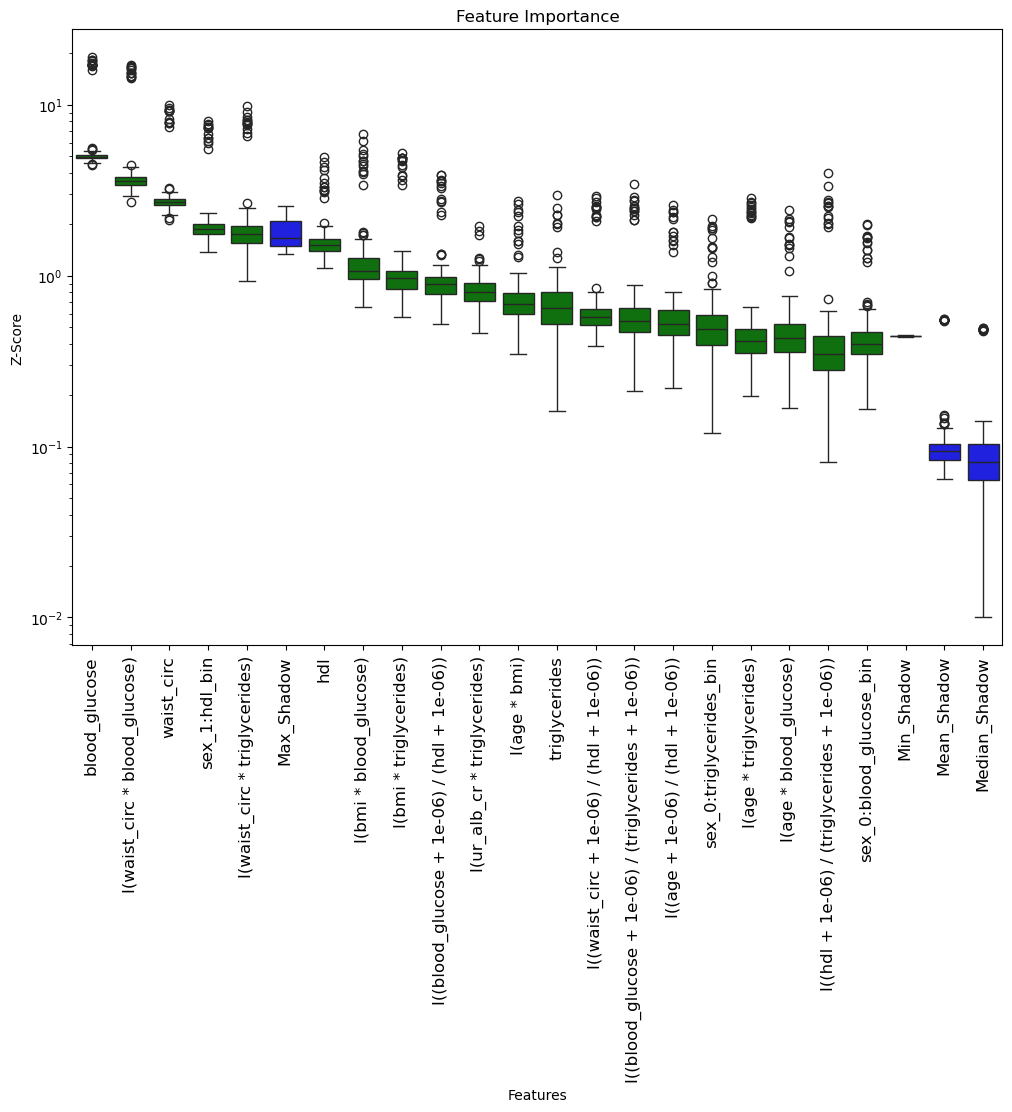

In [122]:
# Plot the features
feature_selector.plot(X_size=12, figsize=(12, 8),
                   y_scale='log', which_features='accepted')

In [123]:
# Create DataFrame of Feature Importances
def get_feature_importance_df(feature_selector, normalize=True):
    """
    Gets a DataFrame with feature names and their corresponding importance scores.
    """
    # Extract importance scores
    X_feature_import, Shadow_feature_import = feature_selector.feature_importance(normalize)

    # Combine feature names
    all_features = list(feature_selector.X.columns) + [f"shadow_{col}" for col in feature_selector.X.columns]

    # Combine importance scores
    all_importances = np.concatenate([X_feature_import, Shadow_feature_import])

    # Create and return a DataFrame
    importance_df = pd.DataFrame({
        'feature_name': all_features,
        'importance_score': all_importances
    })

    return importance_df.sort_values(by='importance_score', ascending=False)

In [124]:
# Call the function
importance_dataframe = get_feature_importance_df(feature_selector).reset_index(drop=True)
importance_dataframe

feature_name  \
0                                                 blood_glucose   
1                                 I(waist_circ * blood_glucose)   
2                                                    waist_circ   
3                                                 sex_1:hdl_bin   
4                                 I(waist_circ * triglycerides)   
5                                                           hdl   
6                                        I(bmi * blood_glucose)   
7                    I((blood_glucose + 1e-06) / (hdl + 1e-06))   
8                                        I(bmi * triglycerides)   
9                                  I(ur_alb_cr * triglycerides)   
10         I((blood_glucose + 1e-06) / (triglycerides + 1e-06))   
11                                                triglycerides   
12                      I((waist_circ + 1e-06) / (hdl + 1e-06))   
13                                       I(age * blood_glucose)   
14                             I((age + 1e-06) / (hdl + 1e-06))   
15                                                 I(age * bmi)   
16  shadow_I((blood_glucose + 1e-06) / (triglycerides + 1e-06))   
17                                       I(age * triglycerides)   
18                                      sex_0:blood_glucose_bin   
19                                shadow_I(bmi * triglycerides)   
20                   I((hdl + 1e-06) / (triglycerides + 1e-06))   
21                                      sex_0:triglycerides_bin   
22            shadow_I((blood_glucose + 1e-06) / (hdl + 1e-06))   
23               shadow_I((waist_circ + 1e-06) / (hdl + 1e-06))   
24                             I(blood_glucose * triglycerides)   
25                                shadow_I(age * triglycerides)   
26                                         shadow_triglycerides   
27                      shadow_I((age + 1e-06) / (hdl + 1e-06))   
28                               shadow_sex_0:blood_glucose_bin   
29                         shadow_I(waist_circ * triglycerides)   
30                                         shadow_blood_glucose   
31                                shadow_I(age * blood_glucose)   
32                      shadow_I(blood_glucose * triglycerides)   
33                                          shadow_I(age * bmi)   
34                         shadow_I(waist_circ * blood_glucose)   
35            shadow_I((hdl + 1e-06) / (triglycerides + 1e-06))   
36                          shadow_I(ur_alb_cr * triglycerides)   
37                                            shadow_waist_circ   
38                                                   shadow_hdl   
39                                shadow_I(bmi * blood_glucose)   
40                               shadow_sex_0:triglycerides_bin   
41                                         shadow_sex_1:hdl_bin   

    importance_score  
0           4.016558  
1           3.253508  
2           1.767719  
3           1.465158  
4           0.997381  
5           0.747219  
6           0.727109  
7           0.482168  
8           0.327903  
9           0.269078  
10         -0.016972  
11         -0.017430  
12         -0.133364  
13         -0.150803  
14         -0.162244  
15         -0.170011  
16         -0.236271  
17         -0.252312  
18         -0.293957  
19         -0.329228  
20         -0.367458  
21         -0.412688  
22         -0.412728  
23         -0.459598  
24         -0.466845  
25         -0.470072  
26         -0.479578  
27         -0.480052  
28         -0.514339  
29         -0.530789  
30         -0.536189  
31         -0.583736  
32         -0.600965  
33         -0.606863  
34         -0.610159  
35         -0.636227  
36         -0.649517  
37         -0.666297  
38         -0.676012  
39         -0.677676  
40         -0.725957  
41         -0.727465

In [125]:
# Plot feature importances
def plot_feature_importances(importance_dataframe):
    """
    Plots feature importances in a descending order.
    """
    # Set the figure size
    plt.figure(figsize=(15, 10))
    
    # Create the color palette
    palette = sns.color_palette("coolwarm_r", len(importance_dataframe))
    
    # Barplot
    sns.barplot(data=importance_dataframe, y='feature_name', x='importance_score', palette=palette)
    
    # Title
    plt.title('Feature Importances', size=20)
    
    # x and y labels
    plt.xlabel('Importance Score', size=15)
    plt.ylabel('Features', size=15)
    
    # Display the importance score on each bar
    for index, value in enumerate(importance_dataframe['importance_score']):
        plt.text(value, index, f'{value:.2f}')
    
    # Display the plot
    plt.show()

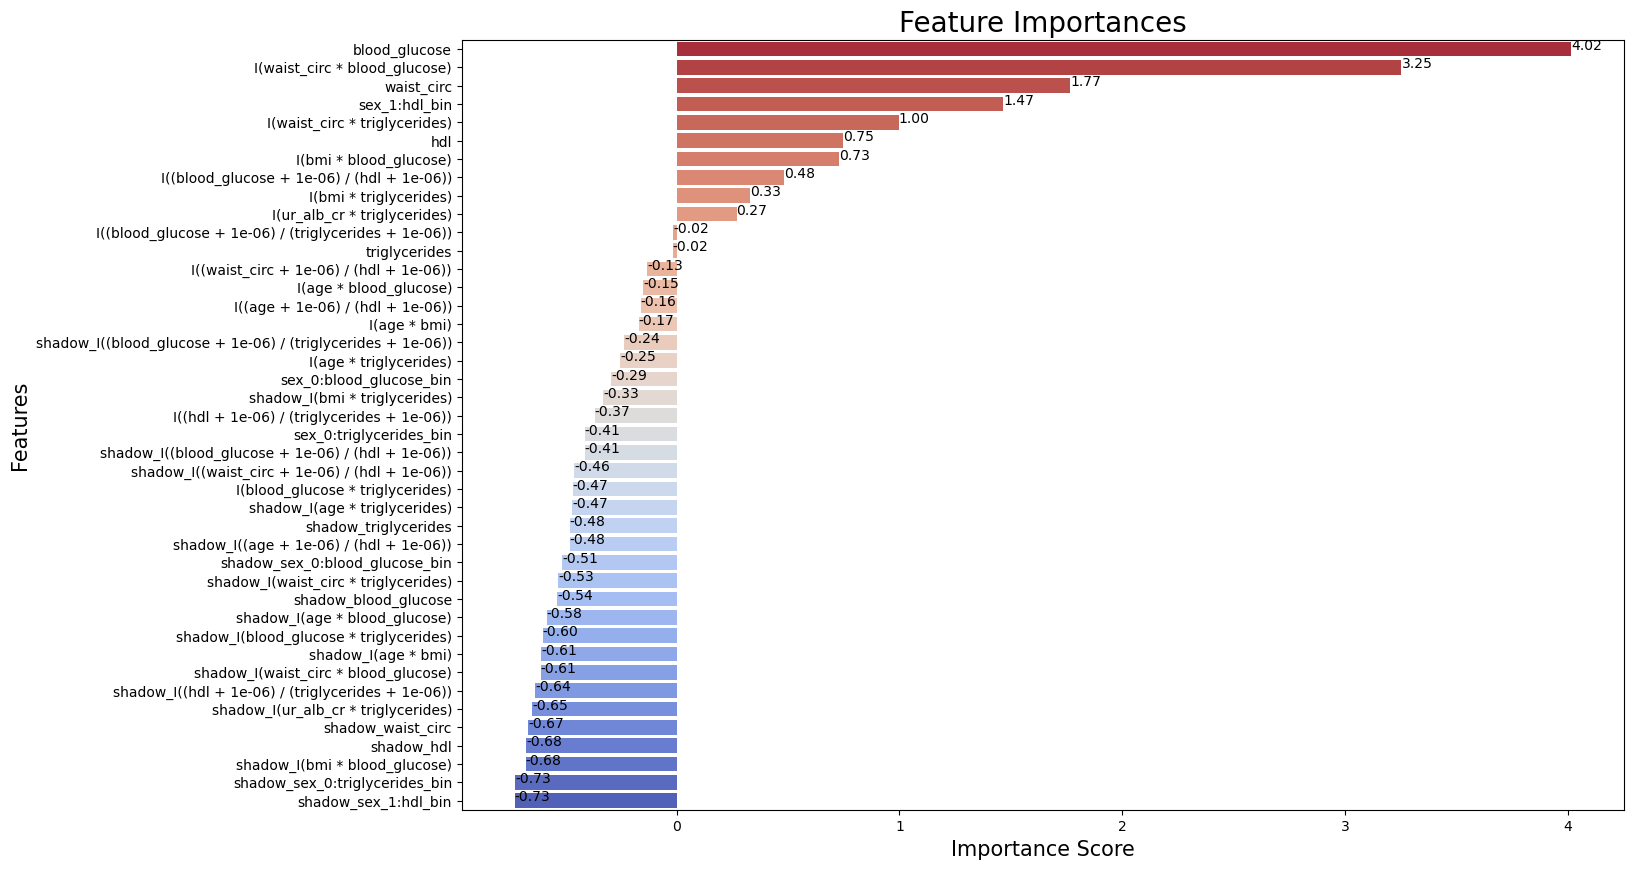

In [126]:
# Call the function
plot_feature_importances(importance_dataframe)

In [127]:
# Initialize the explainer and shap values
feature_selector.explain()
raw_shap_values = feature_selector.raw_shap_values

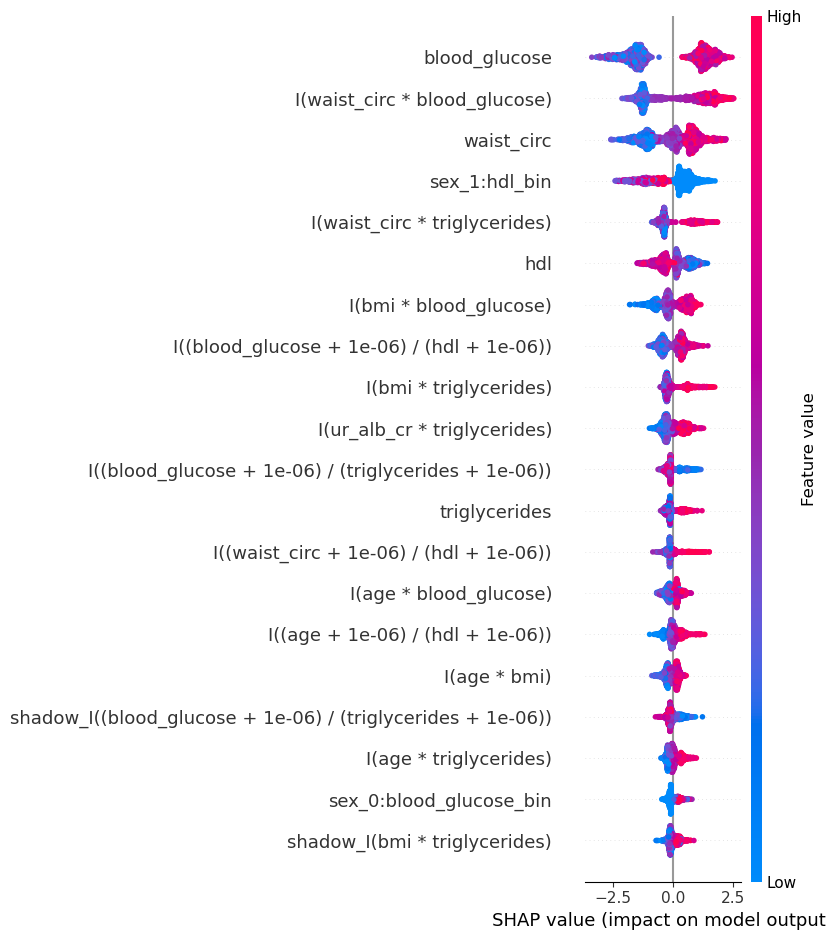

In [128]:
# Plot the shap values
shap_values_2d = np.vstack(raw_shap_values)
shap.summary_plot(shap_values_2d, feature_selector.X_boruta)

# Balancing the Dataset

In [129]:
# Instantiate SMOTEENN
smote_enn = SMOTEENN(random_state=0)

In [130]:
# Print the class distribution
print(f"Before SMOTEENN: {np.bincount(y_train)}")

Before SMOTEENN: [1263  657]


In [131]:
# Fit and resample on the data
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_selected, y_train)

In [132]:
# Print the class distribution after SMOTEENN
print(f"After SMOTEENN: {np.bincount(y_train_resampled)}")

After SMOTEENN: [ 914 1004]


# Hyperparameter Tuning

In [133]:
# Define optuna objective function
def objective_ert(trial, random_state=0):
    # Hyperparameters to be tuned
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 2, 300),
        "max_features": trial.suggest_categorical("max_features", [None]),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        "max_samples": trial.suggest_float('max_samples', 0.1, 1.0),
        "min_samples_split": trial.suggest_float("min_samples_split", 0.01, 0.99),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "ccp_alpha": trial.suggest_float('ccp_alpha', 0.0, 0.1),
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
    }
    
    # Set the hyperparameters for the classifier
    clf = ExtraTreesClassifier(**params, random_state=random_state, n_jobs=-1)

    # Create specificity score function
    def specificity_score(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    
    # Scoring metrics
    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'specificity': make_scorer(specificity_score, greater_is_better=True),
        'f1': 'f1',
        'f2': make_scorer(fbeta_score, beta=2, needs_proba=False, greater_is_better=True),
        'kappa': make_scorer(cohen_kappa_score),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True),
        'log_loss': make_scorer(log_loss, needs_proba=True, greater_is_better=False),
        'matthews_cc': make_scorer(matthews_corrcoef),
        'brier_loss': make_scorer(brier_score_loss, needs_proba=True)
    }

    # Perform cross validation
    cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_validate(clf, X_train_selected, y_train, cv=cv_strategy, scoring=scoring_metrics, return_train_score=True)
    mean_scores = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring_metrics}
    for metric, value in mean_scores.items():
        trial.set_user_attr(metric, value)
    
    return mean_scores["roc_auc"]

In [134]:
# Function to run optuna study
def run_optuna_study(study_name, db_path, objective_function, n_trials, direction="maximize", seed=0, overwrite_existing_study=True):
    """
    Create and optimize an optuna study.
    """
    storage_name = f"sqlite:///{db_path}"

    # Delete previous study if desired
    if overwrite_existing_study:
        try:
            optuna.delete_study(study_name=study_name, storage=storage_name)
        except KeyError:
            print(f"No existing study named '{study_name}'. A new study will be created.")

    # Create the study
    sampler = optuna.samplers.TPESampler(seed=seed)
    pruner = optuna.pruners.SuccessiveHalvingPruner()
    study = optuna.create_study(study_name=study_name, storage=storage_name,
                                direction=direction, sampler=sampler, pruner=pruner)
    
    # Optimize the study
    study.optimize(objective_function, n_trials=n_trials)
    
    return study

In [135]:
# Get the current working directory
current_directory = os.getcwd()

# Run the study
study_ert = run_optuna_study(
    study_name="study_ert",
    db_path=f"{current_directory}/study_ert.db",
    objective_function=objective_ert,
    n_trials=20
)

[I 2023-11-05 16:43:12,602] A new study created in RDB with name: study_ert
[I 2023-11-05 16:43:16,998] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 166, 'max_features': None, 'max_depth': 72, 'max_samples': 0.6424870384644795, 'min_samples_split': 0.5439855193369589, 'min_samples_leaf': 5, 'ccp_alpha': 0.06458941130666561, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5.
[I 2023-11-05 16:43:24,044] Trial 1 finished with value: 0.9213006950906609 and parameters: {'n_estimators': 290, 'max_features': None, 'max_depth': 39, 'max_samples': 0.8125525342743981, 'min_samples_split': 0.5283170213578464, 'min_samples_leaf': 6, 'ccp_alpha': 0.09255966382926611, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9213006950906609.
[I 2023-11-05 16:43:25,563] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 8, 'max_features': None, 'max_depth': 84, 'max_samples': 0.8003410758548655, 'min_samples_split': 0.8626

In [136]:
# Function to print the best trial metric score and hyperparameters
def print_best_trial_results(study):
    """
    Print the results of the best trial in an optuna study.
    """
    print("Best Trial:")
    print(" Value: ", study.best_value)
    print(" Params: ")
    for key, value in study.best_params.items():
        print(f"   {key}: {value}")

In [137]:
# Call the function
print_best_trial_results(study_ert)

Best Trial:
 Value:  0.9327104572665476
 Params: 
   n_estimators: 294
   max_features: None
   max_depth: 61
   max_samples: 0.7653372214584715
   min_samples_split: 0.04840403640923426
   min_samples_leaf: 3
   ccp_alpha: 0.01201965612131689
   bootstrap: True
   criterion: gini


In [138]:
# Function to visualize study history and hyperparameter importances
def visualize_study_results(study, width=800, height=600):
    """
    Visualize the optimization history and hyperparameter importances.
    """
    # Visualize the results
    optimization_history_fig = plot_optimization_history(study)
    param_importances_fig = plot_param_importances(study)

    # Adjust the width and height
    optimization_history_fig.update_layout(width=width, height=height)
    param_importances_fig.update_layout(width=width, height=height)

    # Show the plots
    optimization_history_fig.show()
    param_importances_fig.show()

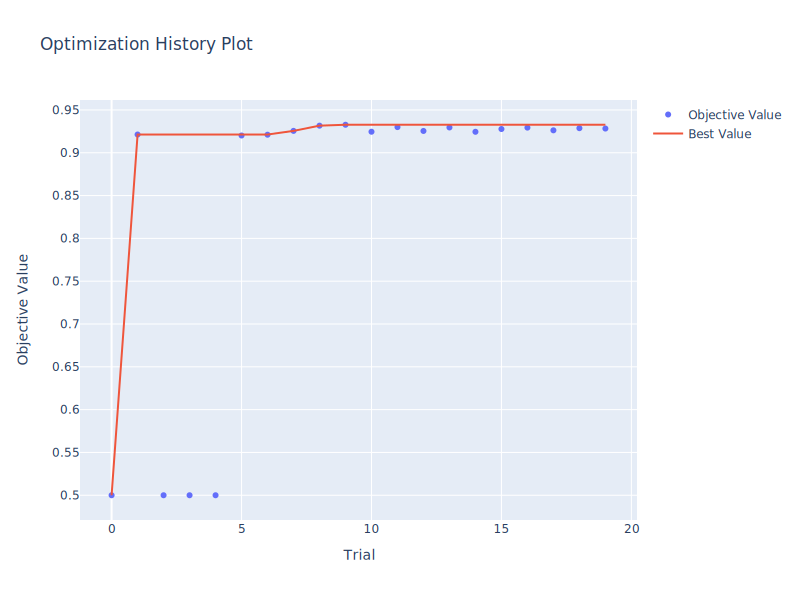

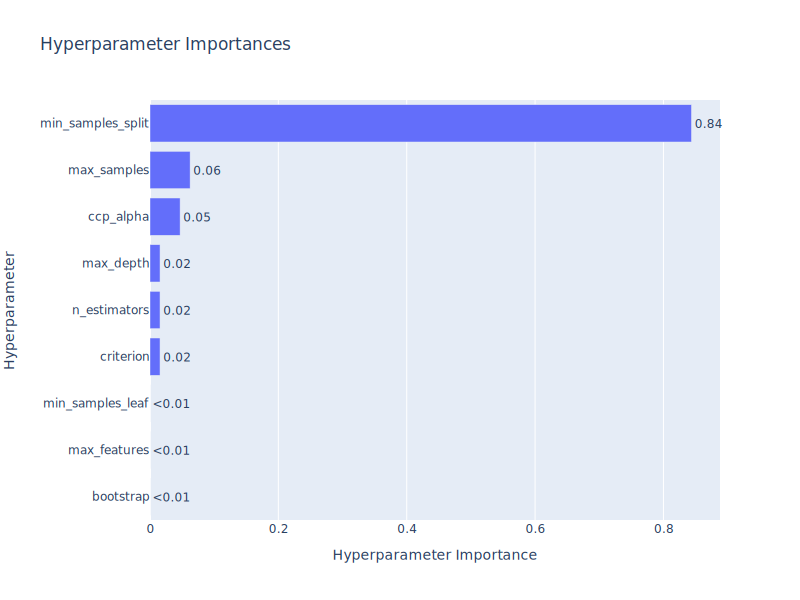

In [139]:
# Call the function
visualize_study_results(study_ert)

In [140]:
# Function to get a DataFrame of the best trial metrics
def get_best_trial_metrics_df(study):
    """
    Retrieve the metrics for the best trial and format them into a DataFrame.
    """
    # Access the best trial
    best_trial = study.best_trial

    # Retrieve the logged metrics for the best trial
    best_trial_metrics = best_trial.user_attrs

    # Convert to a DataFrame
    best_metrics_df = pd.DataFrame([best_trial_metrics]).T
    best_metrics_df.columns = ['Score']
    
    return best_metrics_df

In [141]:
# Call the function
best_metrics_df_ert = get_best_trial_metrics_df(study_ert)
best_metrics_df_ert

Score
accuracy     0.848090
brier_loss   0.107714
f1           0.762757
f2           0.733049
kappa        0.651929
log_loss    -0.353584
matthews_cc  0.656246
pr_auc       0.885285
precision    0.820299
recall       0.714866
roc_auc      0.932710
specificity  0.917392

In [142]:
# Apply best hyperparameters to the classifier
best_params_ert = study_ert.best_params
best_classifier_ert = ExtraTreesClassifier(**best_params_ert, random_state=0)

In [143]:
# Train with the best classifier
best_classifier_ert.fit(X_train_resampled, y_train_resampled)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.01201965612131689,
                     max_depth=61, max_features=None,
                     max_samples=0.7653372214584715, min_samples_leaf=3,
                     min_samples_split=0.04840403640923426, n_estimators=294,
                     random_state=0)

# Test Set Evaluation

In [144]:
# Function to evaluate the classifier on the test set
def evaluate_on_test_set(classifier, X_test, y_test):
    """
    Evaluate the classifier on the test set and print the ROC-AUC score.
    """
    # Predict on the test set
    y_proba = classifier.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC on test set: {roc_auc:.3f}")
    
    return roc_auc

In [145]:
# Get the ROC-AUC score with the test set
roc_auc_ert = evaluate_on_test_set(best_classifier_ert, X_test_selected, y_test)
roc_auc_ert

ROC-AUC on test set: 0.915


0.9154008438818565

In [146]:
# Function to get test evaluation DataFrame
def get_test_metrics_dataframe(clf, X_test, y_test):
    # Predictions and probabilities
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Compute metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }

    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    test_metrics['specificity'] = specificity

    # Create DataFrame
    metrics_df = pd.DataFrame([test_metrics], index=['Scores']).T

    return metrics_df

In [147]:
# Call the function
test_metrics_df_ert = get_test_metrics_dataframe(best_classifier_ert, X_test_selected, y_test)
test_metrics_df_ert

Scores
accuracy     0.806653
roc_auc      0.915401
precision    0.656522
recall       0.915152
f1           0.764557
specificity  0.750000

# Second Classifier Setup

In [148]:
# Define optuna objective function
def objective_hgb(trial, random_state=0):
    # Hyperparameters to be tuned
    params = {
        "max_iter": trial.suggest_int("max_iter", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.25, log=True),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-6, 1e-1, log=True),
        "max_bins": trial.suggest_int("max_bins", 50, 255),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 8, 256)
    }
    
    # Set the hyperparameters for the classifier
    clf = HistGradientBoostingClassifier(**params, random_state=random_state)

    # Create specificity score function
    def specificity_score(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    
    # Scoring metrics
    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'specificity': make_scorer(specificity_score, greater_is_better=True),
        'f1': 'f1',
        'f2': make_scorer(fbeta_score, beta=2, needs_proba=False, greater_is_better=True),
        'kappa': make_scorer(cohen_kappa_score),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True),
        'log_loss': make_scorer(log_loss, needs_proba=True, greater_is_better=False),
        'matthews_cc': make_scorer(matthews_corrcoef),
        'brier_loss': make_scorer(brier_score_loss, needs_proba=True)
    }

    # Perform cross validation
    cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_validate(clf, X_train_selected, y_train, cv=cv_strategy, scoring=scoring_metrics, return_train_score=True)
    mean_scores = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring_metrics}
    for metric, value in mean_scores.items():
        trial.set_user_attr(metric, value)
    
    return mean_scores["roc_auc"]

In [149]:
# Run the study
study_hgb = run_optuna_study(
    study_name="study_hgb",
    db_path=f"{current_directory}/study_hgb.db",
    objective_function=objective_hgb,
    n_trials=20
)

[I 2023-11-05 16:44:40,702] A new study created in RDB with name: study_hgb
[I 2023-11-05 16:44:58,531] Trial 0 finished with value: 0.9604819345180559 and parameters: {'max_iter': 553, 'max_depth': 24, 'min_samples_leaf': 61, 'learning_rate': 0.02025802881607627, 'l2_regularization': 0.0001313028028065861, 'max_bins': 183, 'max_leaf_nodes': 116}. Best is trial 0 with value: 0.9604819345180559.
[I 2023-11-05 16:45:31,334] Trial 1 finished with value: 0.9563549907006039 and parameters: {'max_iter': 893, 'max_depth': 31, 'min_samples_leaf': 39, 'learning_rate': 0.07916061228375827, 'l2_regularization': 0.00044103656679709874, 'max_bins': 167, 'max_leaf_nodes': 238}. Best is trial 0 with value: 0.9604819345180559.
[I 2023-11-05 16:45:33,834] Trial 2 finished with value: 0.9597392806044206 and parameters: {'max_iter': 80, 'max_depth': 4, 'min_samples_leaf': 3, 'learning_rate': 0.09921388126711735, 'l2_regularization': 0.0077764924510783885, 'max_bins': 229, 'max_leaf_nodes': 251}. Best is 

In [150]:
# Print best trial results
print_best_trial_results(study_hgb)

Best Trial:
 Value:  0.9638866758556435
 Params: 
   max_iter: 182
   max_depth: 13
   min_samples_leaf: 80
   learning_rate: 0.03513268386525943
   l2_regularization: 0.00935476773737229
   max_bins: 130
   max_leaf_nodes: 210


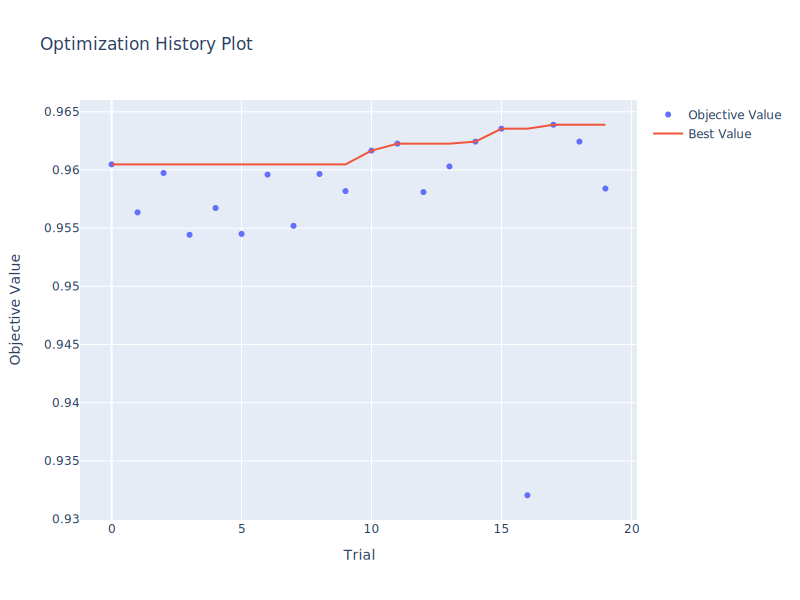

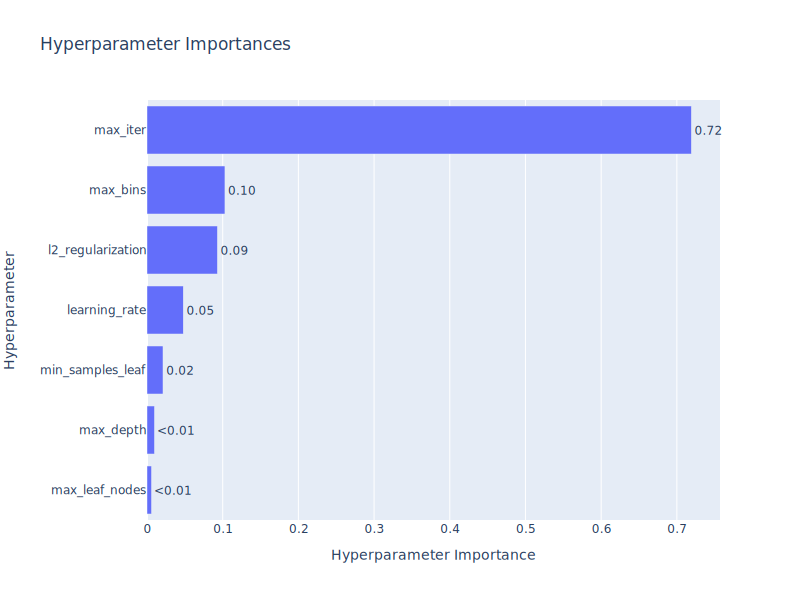

In [151]:
# Visualize the study history and importances
visualize_study_results(study_hgb)

In [152]:
# Get the metrics DataFrame for the best trial
best_metrics_df_hgb = get_best_trial_metrics_df(study_hgb)
best_metrics_df_hgb

Score
accuracy     0.888194
brier_loss   0.073698
f1           0.838629
f2           0.844322
kappa        0.753144
log_loss    -0.228962
matthews_cc  0.753689
pr_auc       0.934667
precision    0.829951
recall       0.848331
roc_auc      0.963887
specificity  0.908942

In [153]:
# Apply best hyperparameters to the classifier
best_params_hgb = study_hgb.best_params
best_classifier_hgb = HistGradientBoostingClassifier(**best_params_hgb, random_state=0)

In [154]:
# Train with the best classifier
best_classifier_hgb.fit(X_train_resampled, y_train_resampled)

HistGradientBoostingClassifier(l2_regularization=0.00935476773737229,
                               learning_rate=0.03513268386525943, max_bins=130,
                               max_depth=13, max_iter=182, max_leaf_nodes=210,
                               min_samples_leaf=80, random_state=0)

In [155]:
# Get the ROC-AUC score with the test set
roc_auc_hgb = evaluate_on_test_set(best_classifier_hgb, X_test_selected, y_test)
roc_auc_hgb

ROC-AUC on test set: 0.932


0.9324702723436901

In [156]:
# Get test metrics DataFrame
test_metrics_df_hgb = get_test_metrics_dataframe(best_classifier_hgb, X_test_selected, y_test)
test_metrics_df_hgb

Scores
accuracy     0.837838
roc_auc      0.932470
precision    0.700461
recall       0.921212
f1           0.795812
specificity  0.794304

# Third Classifier Setup

In [157]:
# Define optuna objective function
def objective_mlp(trial, random_state=0):
    # Hyperparameters to be tuned
    params = {
        "hidden_layer_sizes": trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
        "activation": trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        "solver": trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        "alpha": trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        "learning_rate": trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        "learning_rate_init": trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True),
        "max_iter": 1000
    }
    
    # Set the hyperparameters for the classifier
    clf = MLPClassifier(**params, random_state=random_state)

    # Create specificity score function
    def specificity_score(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    
    # Scoring metrics
    scoring_metrics = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'specificity': make_scorer(specificity_score, greater_is_better=True),
        'f1': 'f1',
        'f2': make_scorer(fbeta_score, beta=2, needs_proba=False, greater_is_better=True),
        'kappa': make_scorer(cohen_kappa_score),
        'pr_auc': make_scorer(average_precision_score, needs_proba=True),
        'log_loss': make_scorer(log_loss, needs_proba=True, greater_is_better=False),
        'matthews_cc': make_scorer(matthews_corrcoef),
        'brier_loss': make_scorer(brier_score_loss, needs_proba=True)
    }

    # Perform cross validation
    cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
    scores = cross_validate(clf, X_train_selected, y_train, cv=cv_strategy, scoring=scoring_metrics, return_train_score=True)
    mean_scores = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring_metrics}
    for metric, value in mean_scores.items():
        trial.set_user_attr(metric, value)
    
    return mean_scores["roc_auc"]

In [158]:
# Run the study
study_mlp = run_optuna_study(
    study_name="study_mlp",
    db_path=f"{current_directory}/study_mlp.db",
    objective_function=objective_mlp,
    n_trials=20
)

[I 2023-11-05 16:48:25,697] A new study created in RDB with name: study_mlp
[I 2023-11-05 16:48:38,212] Trial 0 finished with value: 0.9221552498629609 and parameters: {'hidden_layer_sizes': [100], 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.001304907355036239, 'learning_rate': 'invscaling', 'learning_rate_init': 2.2310905607443014e-05}. Best is trial 0 with value: 0.9221552498629609.
[I 2023-11-05 16:48:49,282] Trial 1 finished with value: 0.9318452770079056 and parameters: {'hidden_layer_sizes': [100, 50], 'activation': 'identity', 'solver': 'sgd', 'alpha': 0.06007249475906202, 'learning_rate': 'constant', 'learning_rate_init': 0.01250071223083625}. Best is trial 1 with value: 0.9318452770079056.
[I 2023-11-05 16:50:10,320] Trial 2 finished with value: 0.9412623460914201 and parameters: {'hidden_layer_sizes': [100, 50], 'activation': 'tanh', 'solver': 'adam', 'alpha': 1.7414134181586194e-05, 'learning_rate': 'invscaling', 'learning_rate_init': 3.2787264983352775e-05}. Best is

In [159]:
# Print best trial results
print_best_trial_results(study_mlp)

Best Trial:
 Value:  0.9512426810261193
 Params: 
   hidden_layer_sizes: [50]
   activation: logistic
   solver: adam
   alpha: 0.036621546572718634
   learning_rate: constant
   learning_rate_init: 0.0032206456438891597


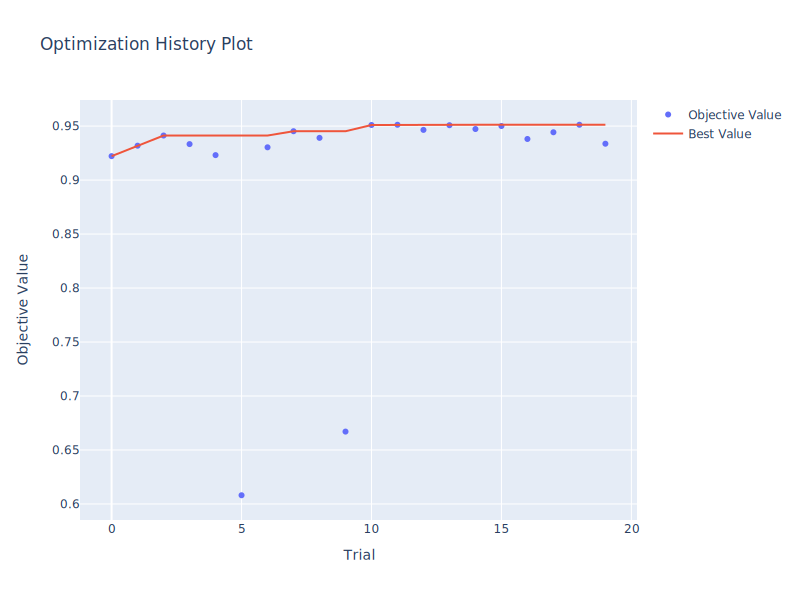

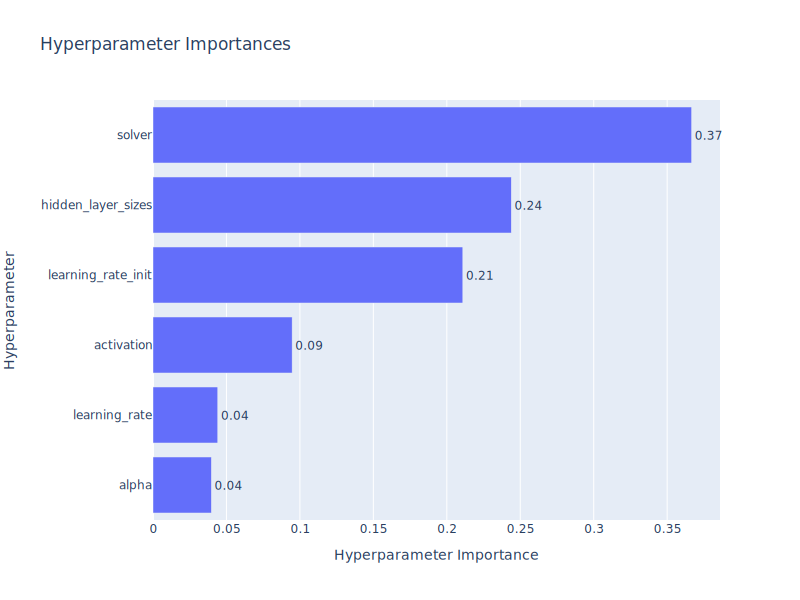

In [160]:
# Visualize the study history and importances
visualize_study_results(study_mlp)

In [161]:
# Get the metrics DataFrame for the best trial
best_metrics_df_mlp = get_best_trial_metrics_df(study_mlp)
best_metrics_df_mlp

Score
accuracy     0.871528
brier_loss   0.087420
f1           0.811859
f2           0.810036
kappa        0.714418
log_loss    -0.271937
matthews_cc  0.715560
pr_auc       0.913156
precision    0.816680
recall       0.809268
roc_auc      0.951243
specificity  0.903940

In [162]:
# Apply best hyperparameters to the classifier
best_params_mlp = study_mlp.best_params
best_classifier_mlp = MLPClassifier(**best_params_mlp, random_state=0)

In [163]:
# Train with the best classifier
best_classifier_mlp.fit(X_train_selected, y_train)

MLPClassifier(activation='logistic', alpha=0.036621546572718634,
              hidden_layer_sizes=[50], learning_rate_init=0.0032206456438891597,
              random_state=0)

In [164]:
# Get the ROC-AUC score with the test set
roc_auc_mlp = evaluate_on_test_set(best_classifier_mlp, X_test_selected, y_test)
roc_auc_mlp

ROC-AUC on test set: 0.940


0.9399693133870349

In [165]:
# Get test metrics DataFrame
test_metrics_df_mlp = get_test_metrics_dataframe(best_classifier_mlp, X_test_selected, y_test)
test_metrics_df_mlp

Scores
accuracy     0.856549
roc_auc      0.939969
precision    0.789157
recall       0.793939
f1           0.791541
specificity  0.889241

# Stacking Ensemble

## Creating Initial Model

In [166]:
# Define meta-classifier
xgb_meta = XGBClassifier(eval_metric="logloss", random_state=0)

# Define cross validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

# Define the stacking ensemble using probabilities for meta-features
stacking_model = StackingCVClassifier(
    classifiers=[best_classifier_ert, best_classifier_hgb, best_classifier_mlp],
    use_probas=True,
    meta_classifier=xgb_meta,
    cv=cv_strategy
)

In [167]:
# Evaluate the base estimators
def evaluate_estimators(estimators, labels, X_train, y_train, cv, scoring):
    print(f'{cv}-fold cross validation on the training set:\n')
    
    for clf, label in zip(estimators, labels):
        # Perform cross-validation and print the score for each classifier
        train_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scoring)
        print(f"{label} classifier - TRAIN {scoring.upper()}: Mean: {train_scores.mean():.2f}, Std Dev: {train_scores.std():.2f}")

In [168]:
# Call the function
evaluate_estimators(
    estimators=[best_classifier_ert, best_classifier_hgb, best_classifier_mlp, xgb_meta],
    labels=['ERT', 'HGB', 'MLP', 'XGB_Meta'],
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    cv=cv_strategy,
    scoring='roc_auc'
)

RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0)-fold cross validation on the training set:

ERT classifier - TRAIN ROC_AUC: Mean: 0.99, Std Dev: 0.00
HGB classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00
MLP classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00
XGB_Meta classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00


## Hyperparameter Tuning

In [169]:
# Define a hyperparameter dictionary for XGBoost
params_xgb = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': np.logspace(-4, 0, 10),
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'colsample_bylevel': np.linspace(0.5, 1.0, 6),
    'colsample_bynode': np.linspace(0.5, 1.0, 6),
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'gamma': np.linspace(0, 0.5, 6),
    'reg_alpha': np.logspace(-5, 1, 7),
    'reg_lambda': np.logspace(-5, 1, 7),
    'scale_pos_weight': [1, 2, 3, 4],
    'max_delta_step': [0, 1, 2, 3, 4, 5]
}

In [170]:
# Define the search object
halving_search = HalvingRandomSearchCV(
    estimator=xgb_meta,
    param_distributions=params_xgb,
    cv=cv_strategy,
    refit=True,
    random_state=0,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

halving_search.fit(X_train_resampled, y_train_resampled)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 60
max_resources_: 1918
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 31
n_resources: 60
Fitting 15 folds for each of 31 candidates, totalling 465 fits
----------
iter: 1
n_candidates: 11
n_resources: 180
Fitting 15 folds for each of 11 candidates, totalling 165 fits
----------
iter: 2
n_candidates: 4
n_resources: 540
Fitting 15 folds for each of 4 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 2
n_resources: 1620
Fitting 15 folds for each of 2 candidates, totalling 30 fits


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
                      error_score='raise',
                      estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              gpu...
                                           'max_delta_step': [0, 1, 2, 3, 4, 5],
                                           'max_depth': [3, 4, 5, 6, 7],
                                           'min_child_weight': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9,
                                                                10],
                                           'n_estimators': [100, 200, 300, 400,
                                                            500],
                                           'reg_alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                           'reg_lambda': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                           'scale_pos_weight': [1, 2, 3, 4],
                                           'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                      random_state=0, verbose=1)

In [171]:
# Print the parameter history and best score
cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(halving_search.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (halving_search.cv_results_[cv_keys[0]][r],
             halving_search.cv_results_[cv_keys[1]][r] / 2.0,
             halving_search.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % halving_search.best_params_)
print('ROC-AUC: %.2f' % halving_search.best_score_)

0.894 +/- 0.05 {'subsample': 0.6, 'scale_pos_weight': 2, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 6, 'max_delta_step': 3, 'learning_rate': 0.000774263682681127, 'gamma': 0.2, 'colsample_bytree': 0.5, 'colsample_bynode': 0.6, 'colsample_bylevel': 1.0}
0.655 +/- 0.01 {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'max_delta_step': 1, 'learning_rate': 0.002154434690031882, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}
0.895 +/- 0.04 {'subsample': 0.6, 'scale_pos_weight': 2, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 5, 'max_delta_step': 1, 'learning_rate': 0.12915496650148828, 'gamma': 0.0, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}
0.813 +/- 0.06 {'subsample': 0.6, 'scale_pos_weight': 4, 'reg_lambda':

## Fitting Tuned Model

In [172]:
# Get the best model from tuning
best_xgb_meta = halving_search.best_estimator_

# Save the model
joblib.dump(best_xgb_meta, 'best_meta_xgb.joblib')

['best_meta_xgb.joblib']

In [173]:
# Get test metrics DataFrame
test_metrics_df_meta = get_test_metrics_dataframe(best_xgb_meta, X_test_selected, y_test)
test_metrics_df_meta

Scores
accuracy     0.841996
roc_auc      0.937783
precision    0.703196
recall       0.933333
f1           0.802083
specificity  0.794304

In [174]:
# Re-define the stacking ensemble with the tuned meta-model
stacking_model_tuned = StackingCVClassifier(
    classifiers=[best_classifier_ert, best_classifier_hgb, best_classifier_mlp],
    use_probas=True,
    meta_classifier=best_xgb_meta
)

In [175]:
# Evaluate with tuned meta-model
evaluate_estimators(
    estimators=[best_classifier_ert, best_classifier_hgb, best_classifier_mlp, best_xgb_meta],
    labels=['ERT', 'HGB', 'MLP', 'XGB_Meta'],
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    cv=5,
    scoring='roc_auc'
)

5-fold cross validation on the training set:

ERT classifier - TRAIN ROC_AUC: Mean: 0.99, Std Dev: 0.00
HGB classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00
MLP classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00
XGB_Meta classifier - TRAIN ROC_AUC: Mean: 1.00, Std Dev: 0.00


In [176]:
# Fit the stacking model with the full training data
stacking_model_tuned.fit(X_train_resampled, y_train_resampled)

StackingCVClassifier(classifiers=[ExtraTreesClassifier(bootstrap=True,
                                                       ccp_alpha=0.01201965612131689,
                                                       max_depth=61,
                                                       max_features=None,
                                                       max_samples=0.7653372214584715,
                                                       min_samples_leaf=3,
                                                       min_samples_split=0.04840403640923426,
                                                       n_estimators=294,
                                                       random_state=0),
                                  HistGradientBoostingClassifier(l2_regularization=0.00935476773737229,
                                                                 learning_rate=0.0351326838652...
                                                   grow_policy=None,
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=0.3593813663804626,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=2,
                                                   max_depth=4, max_leaves=None,
                                                   min_child_weight=2,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   n_estimators=100,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   predictor=None,
                                                   random_state=0, ...),
                     use_probas=True)

## Evaluating the Model

In [177]:
# Predict on the meta-features of the test set
y_pred = stacking_model_tuned.predict(X_test_selected)
y_pred_proba = stacking_model_tuned.predict_proba(X_test_selected)[:, 1]

# Evaluate the predictions
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.821
Recall: 0.903
Precision: 0.680
ROC AUC: 0.912
F1 Score: 0.776
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       316
           1       0.68      0.90      0.78       165

    accuracy                           0.82       481
   macro avg       0.81      0.84      0.81       481
weighted avg       0.85      0.82      0.83       481



In [178]:
# Get test metrics DataFrame
test_metrics_df_stacked = get_test_metrics_dataframe(stacking_model_tuned, X_test_selected, y_test)
test_metrics_df_stacked

Scores
accuracy     0.821206
roc_auc      0.912457
precision    0.680365
recall       0.903030
f1           0.776042
specificity  0.778481

In [179]:
# Function to plot bar chart for metrics
def plot_metrics(y_test, y_pred, y_pred_proba):
    """
    Plots a bar chart of the model metrics.
    """
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    # Define pastel colors
    colors = sns.color_palette("pastel")
    
    # Plotting the bar chart
    fig, ax = plt.subplots()
    bars = ax.bar(metrics.keys(), metrics.values(), color=colors)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Metrics for the Stacking Model')
    
    # Display the values on the bars
    for bar, value in zip(bars, metrics.values()):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{value:.3f}",
            ha='center', va='bottom',
            fontsize=8
        )
    
    plt.show()

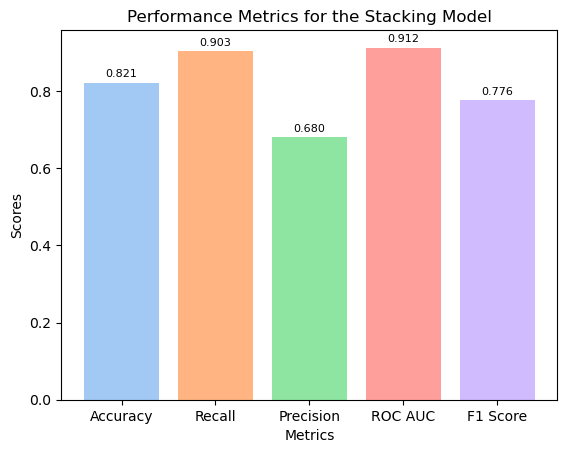

In [180]:
# Call the function
plot_metrics(y_test, y_pred, y_pred_proba)

In [181]:
# Function to plot the ROC-AUC
def plot_roc_auc(stacking_model, X_test, y_test):
    """
    Plots the ROC-AUC curve for the given stacking model.
    """
    # Check if the model has been fitted
    if not hasattr(stacking_model, 'clfs_'):
        raise ValueError("The stacking model is not fitted yet. Please fit it before calling this function.")

    # Predict probabilities for the positive class
    y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

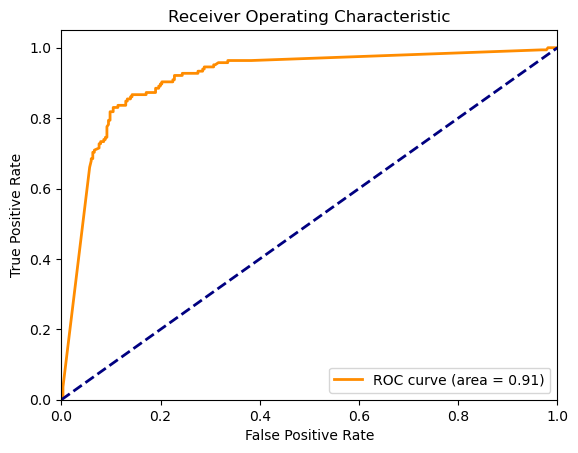

In [182]:
# Call the function
roc_auc_plot = plot_roc_auc(stacking_model_tuned, X_test_selected, y_test)

In [183]:
# Function to plot the PR-AUC
def plot_precision_recall_auc(model, X, y_true):
    """
    Plots the precision-recall AUC for the model.
    """
    # Get the prediction probabilities for the positive class
    y_scores = model.predict_proba(X)[:, 1]

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

    return pr_auc

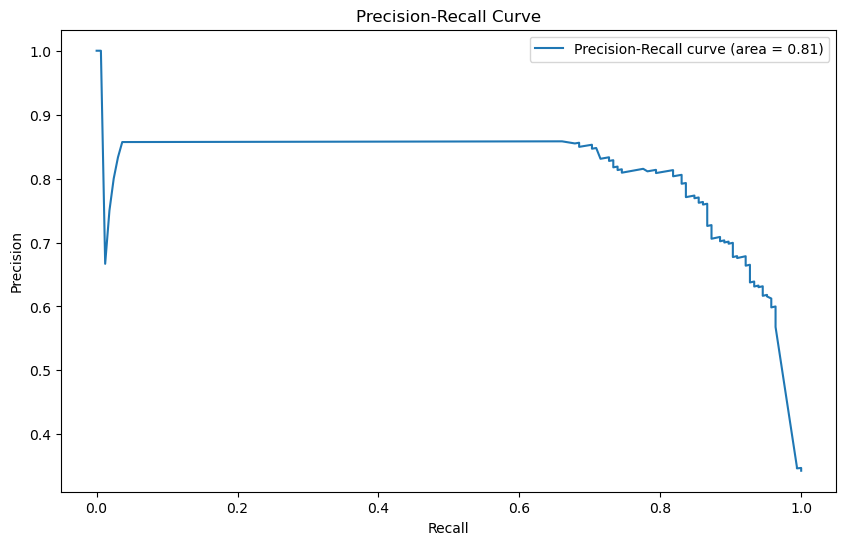

In [184]:
# Call the function
pr_auc_plot = plot_precision_recall_auc(stacking_model_tuned, X_test_selected, y_test)

In [185]:
# Display DataFrames side-by-side
def display_side_by_side(dfs, titles):
    """
    Displays the dataframes side by side.
    """
    html_str = ''
    for df, title in zip(dfs, titles):
        df_html = df.to_html()
        html_str += f'<td style="vertical-align:top"><h3>{title}</h3>{df_html}</td>'
    
    display(HTML(f'<table><tr>{html_str}</tr></table>'))

In [186]:
# Call the function
display_side_by_side([test_metrics_df_ert, test_metrics_df_hgb, test_metrics_df_mlp, test_metrics_df_meta, test_metrics_df_stacked],
                    ['ERT Classifier', 'HGB Classifier', 'MLP Classifier', 'XGB Meta Classifier', 'Stacking Classifier'])

In [187]:
# Function to plot the metrics for comparison
def plot_classifier_scores(dfs, titles):
    """
    Plots a line plot for the scores of different classifiers using their metrics DataFrames.
    """
    # Concatenate the DataFrames
    combined_df = pd.concat(dfs, axis=1, keys=titles)
    
    # Plot setup
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each classifier's scores
    for classifier in combined_df.columns.levels[0]:
        classifier_scores = combined_df[classifier].mean(axis=1)
        ax.plot(classifier_scores.index, classifier_scores.values, label=classifier)

    # Set labels and title
    ax.set_xlabel('Score Type', fontsize=12)
    ax.set_ylabel('Score Value', fontsize=12)
    ax.set_title('Classifier Scores', fontsize=16)

    # Add a legend
    ax.legend(title='Classifiers')

    # Rotate the x-axis labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

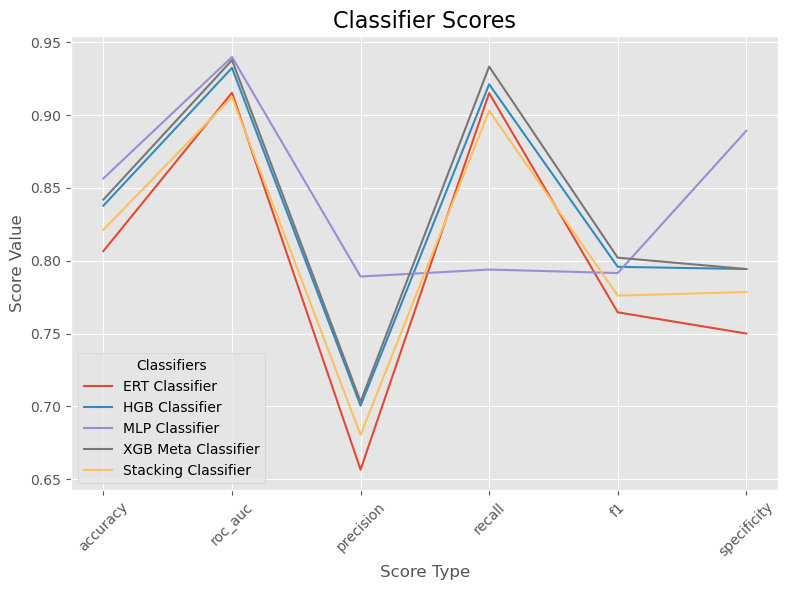

In [188]:
# Call the function
plot_classifier_scores([test_metrics_df_ert, test_metrics_df_hgb, test_metrics_df_mlp, test_metrics_df_meta, test_metrics_df_stacked],
                    ['ERT Classifier', 'HGB Classifier', 'MLP Classifier', 'XGB Meta Classifier', 'Stacking Classifier'])

In [189]:
# Function to create a spider plot for model comparison
def plot_spider_plot(dfs, titles):
    """
    Plots a spider plot of the different classifier scores using their metrics DataFrames.
    """
    # Number of variables to plot
    num_vars = len(dfs[0])

    # Compute angle
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], dfs[0].index, color="grey", size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.5, 0.75, 1], ["0.5", "0.75", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot data and fill with color for each classifier
    for df, title in zip(dfs, titles):
        values = df["Scores"].tolist()
        values += values[:1]  # Repeat the first value to close the circular plot
        ax.plot(angles, values, linewidth=1, linestyle="solid", label=title)
        ax.fill(angles, values, alpha=0.25)

    # Add a legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

    # Add the title
    plt.title("Spider Plot for Model Comparison", size=16, color="black", y=1.1)

    # Show the plot
    plt.show()

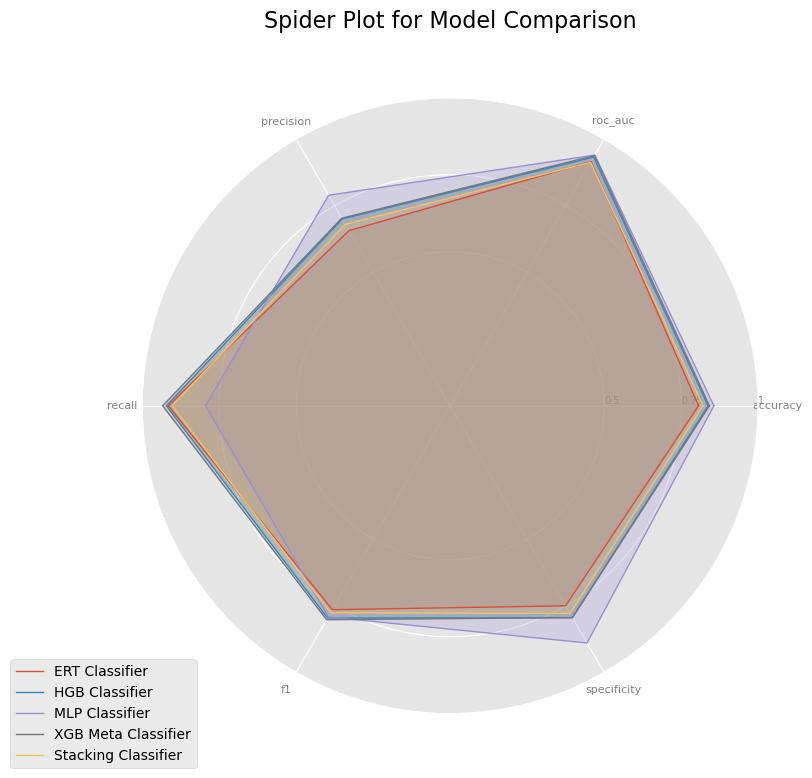

In [190]:
# Call the function
plot_spider_plot([test_metrics_df_ert, test_metrics_df_hgb, test_metrics_df_mlp, test_metrics_df_meta, test_metrics_df_stacked],
                    ['ERT Classifier', 'HGB Classifier', 'MLP Classifier', 'XGB Meta Classifier', 'Stacking Classifier'])